In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import statsmodels.tsa as tsa
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as tsaplots
import statsmodels.tsa.stattools as stattools
from scipy import stats
import seaborn as sns
import matplotlib

## Lectura del Dataset

In [370]:
df = pd.read_csv('Dataset/AEP_hourly.csv', sep=',')

In [371]:
df

Datetime   AEP_MW
0       2004-12-31 01:00:00  13478.0
1       2004-12-31 02:00:00  12865.0
2       2004-12-31 03:00:00  12577.0
3       2004-12-31 04:00:00  12517.0
4       2004-12-31 05:00:00  12670.0
...                     ...      ...
121268  2018-01-01 20:00:00  21089.0
121269  2018-01-01 21:00:00  20999.0
121270  2018-01-01 22:00:00  20820.0
121271  2018-01-01 23:00:00  20415.0
121272  2018-01-02 00:00:00  19993.0

[121273 rows x 2 columns]

Text(0.5, 1.0, 'Consumo de electricidad de la proveedora de energia American Electric Power Company, Inc ')

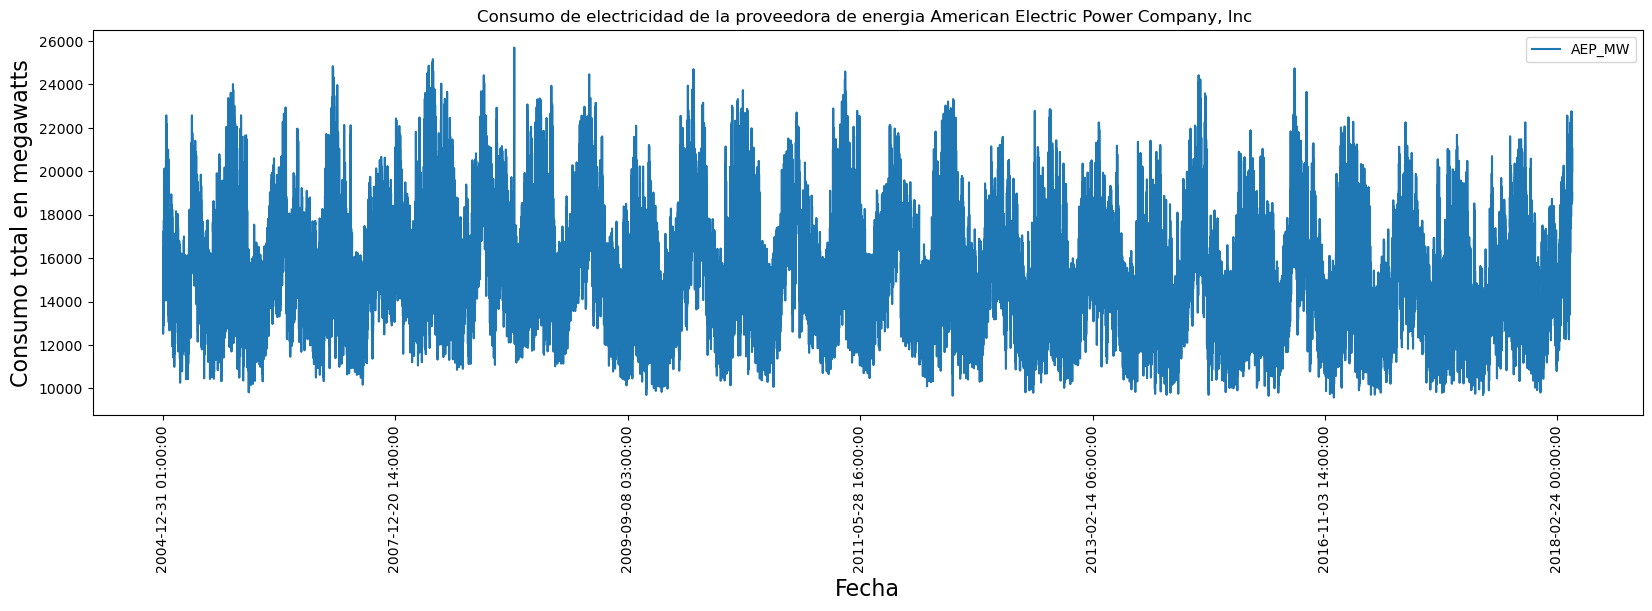

In [372]:
plt.rcParams["figure.figsize"] = (20,5)
ax = df.plot(x="Datetime",y='AEP_MW',rot=90)
ax.set_ylabel("Consumo total en megawatts", fontsize=16)
ax.set_xlabel("Fecha", fontsize=16)
ax.set_title("Consumo de electricidad de la proveedora de energia American Electric Power Company, Inc ")

In [373]:
df["Datetime2"] = pd.to_datetime(df["Datetime"])

In [374]:
df = df[df["Datetime2"]>=datetime.datetime(2005, 1, 1)]
df = df[df["Datetime2"]<=datetime.datetime(2018, 12, 31)]

Text(0.5, 1.0, 'Consumo de electricidad de la proveedora de energia American Electric Power Company, Inc ')

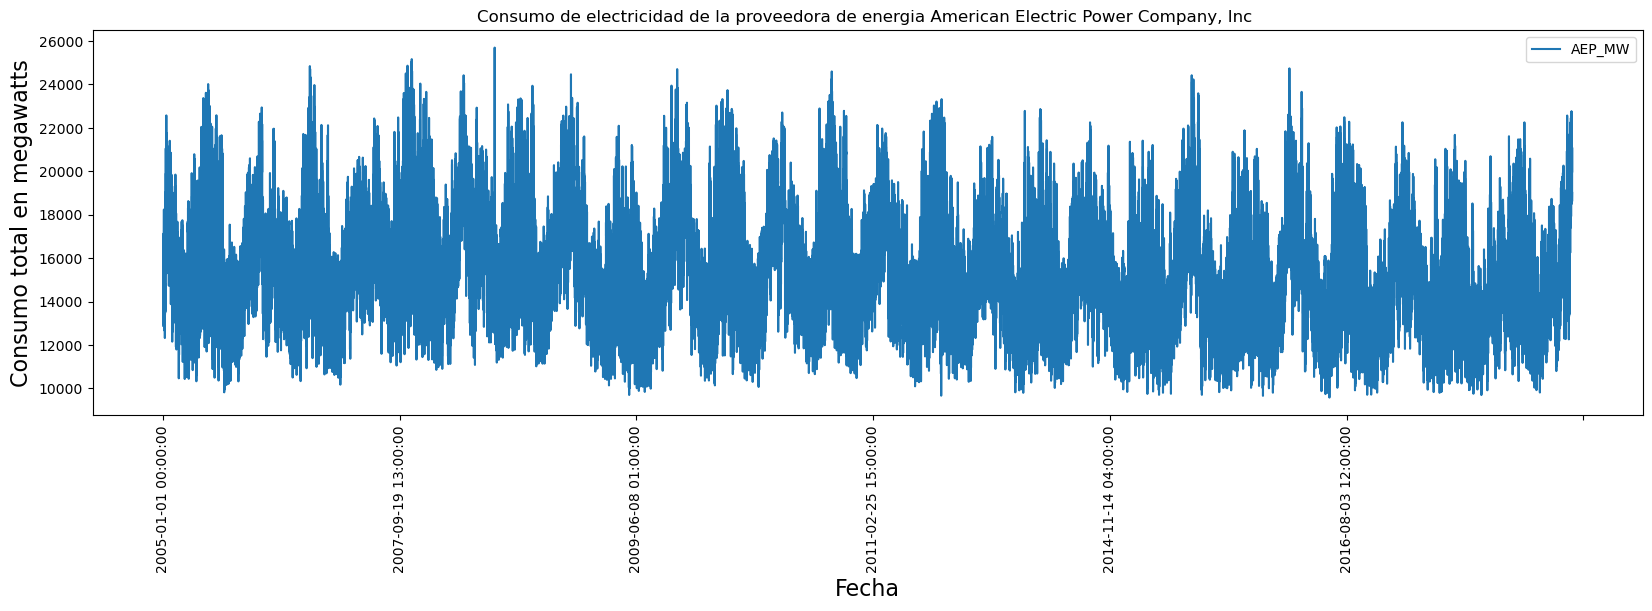

In [375]:
plt.rcParams["figure.figsize"] = (20,5)
ax = df.plot(x="Datetime",y='AEP_MW',rot=90)
ax.set_ylabel("Consumo total en megawatts", fontsize=16)
ax.set_xlabel("Fecha", fontsize=16)
ax.set_title("Consumo de electricidad de la proveedora de energia American Electric Power Company, Inc ")

In [376]:
df["Date"]=df["Datetime2"].dt.date

In [377]:
#Elimino dias de años bisiestos
df = df[df.Date != datetime.date(2008,2,29)]
df = df[df.Date != datetime.date(2012,2,29)]
df = df[df.Date != datetime.date(2016,2,29)]
df = df[df.Date != datetime.date(2020,2,29)]

In [378]:
df2 = df.groupby(["Date"]).agg({'AEP_MW': [np.max]})

In [379]:
df2["Date2"] = df2.index
df2 = df2.set_index(pd.Series(range(1,len(df2)+1)))
df2["Date"] = df2["Date2"]
df2 = df2.drop(columns=["Date2"])

In [380]:
df2

AEP_MW        Date
         amax            
1     14536.0  2005-01-01
2     15269.0  2005-01-02
3     17097.0  2005-01-03
4     17434.0  2005-01-04
5     18061.0  2005-01-05
...       ...         ...
4956  18262.0  2018-07-30
4957  16984.0  2018-07-31
4958  17204.0  2018-08-01
4959  18869.0  2018-08-02
4960  14809.0  2018-08-03

[4960 rows x 2 columns]

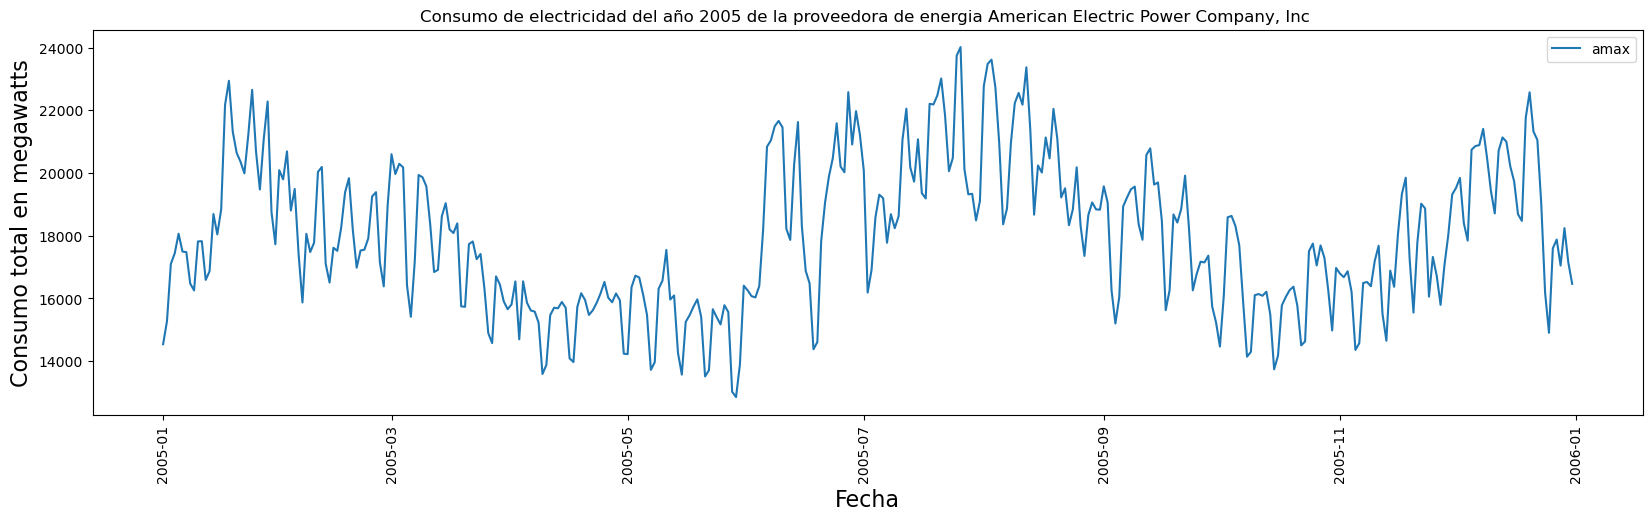

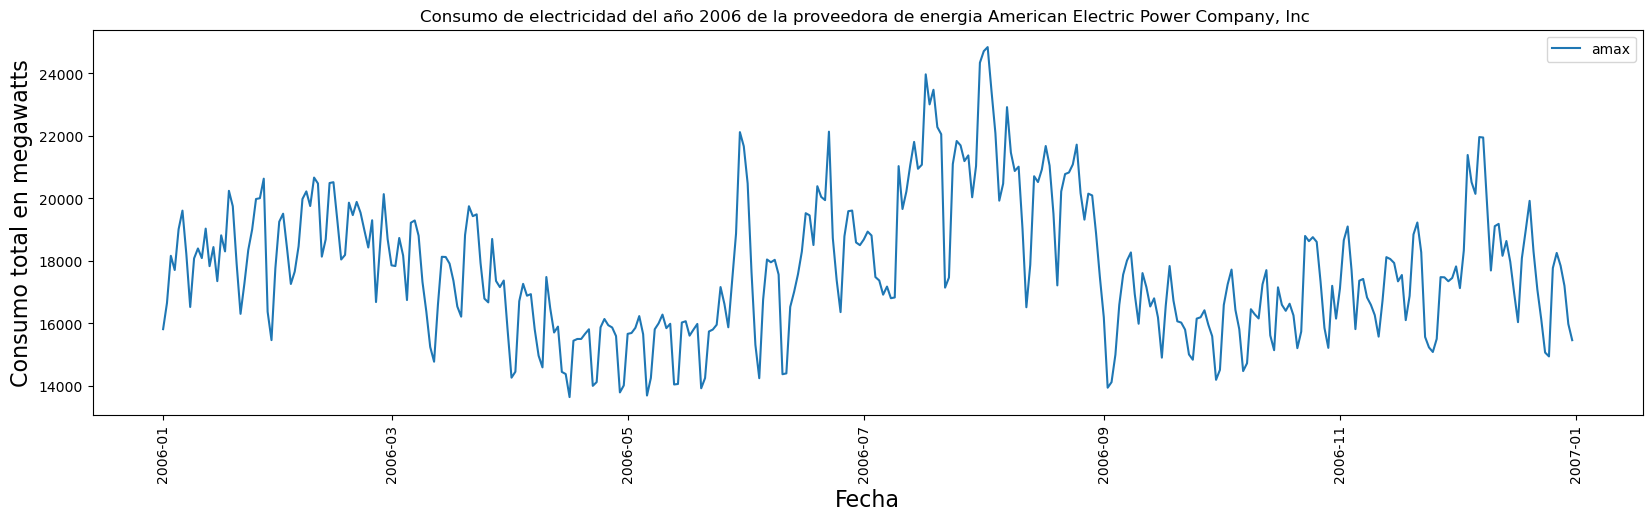

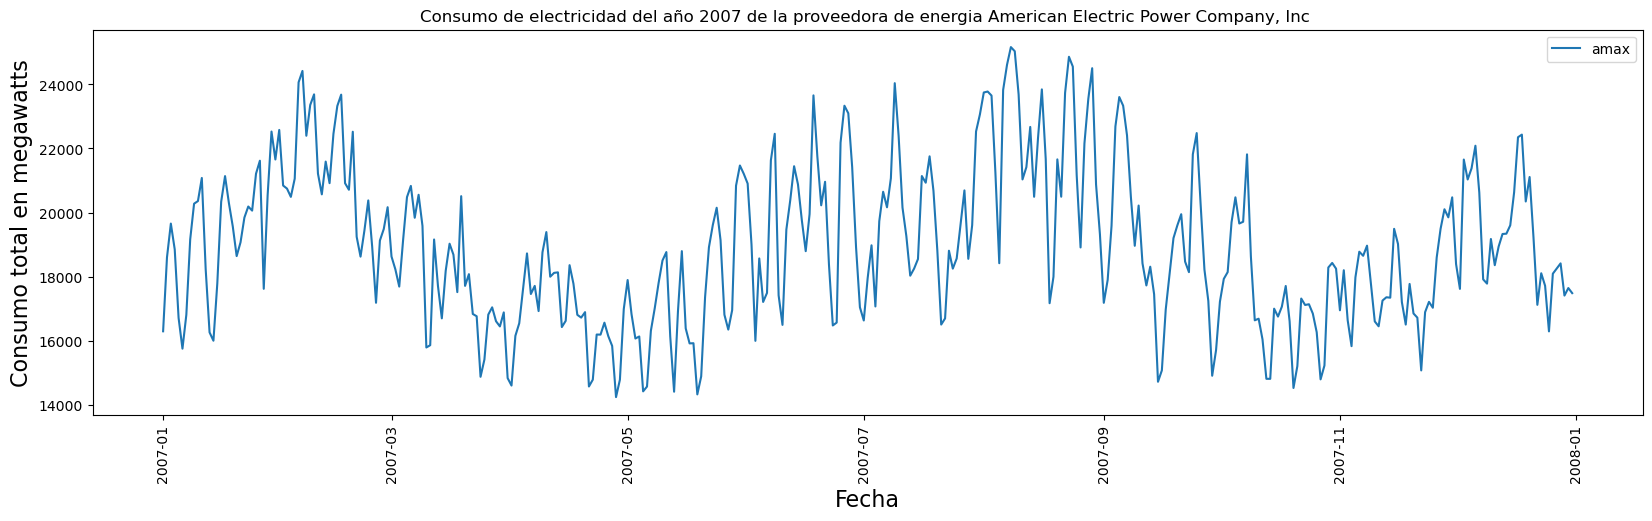

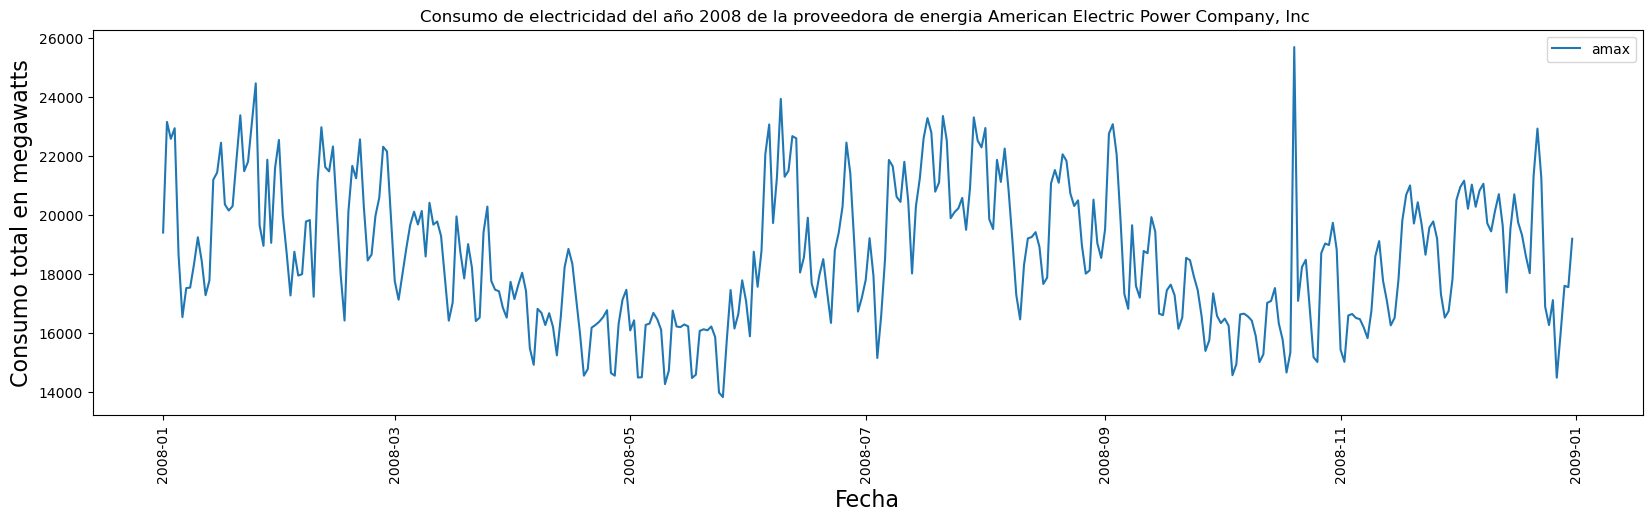

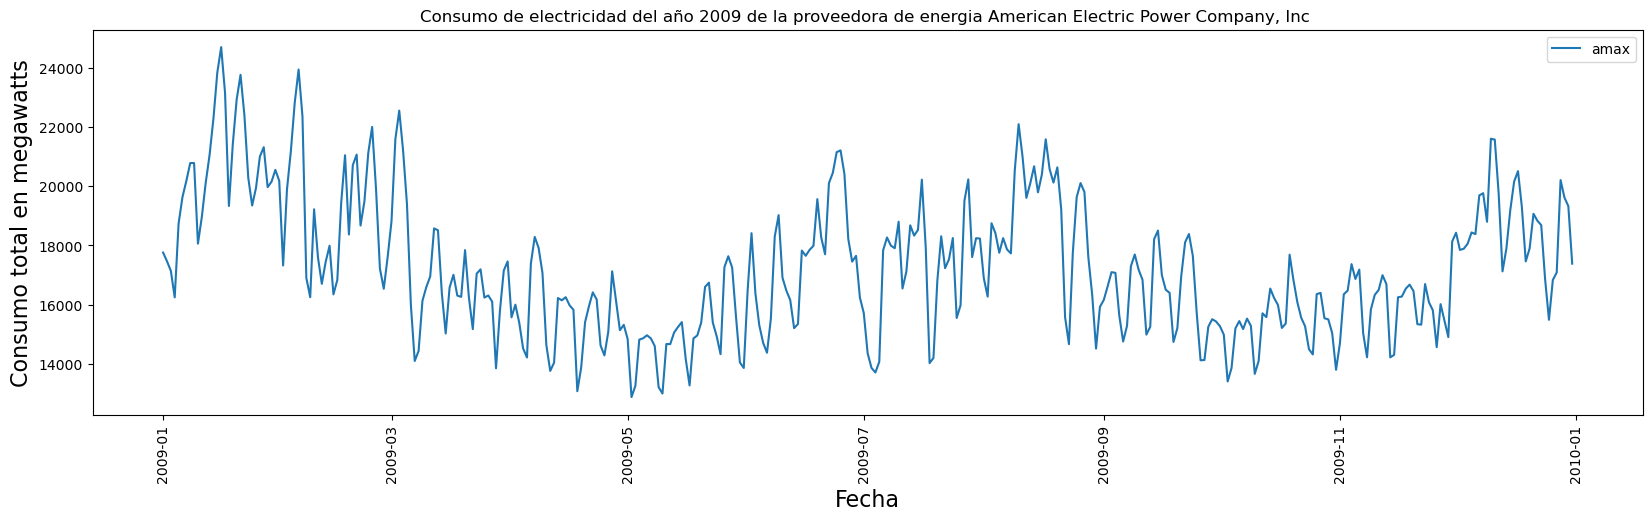

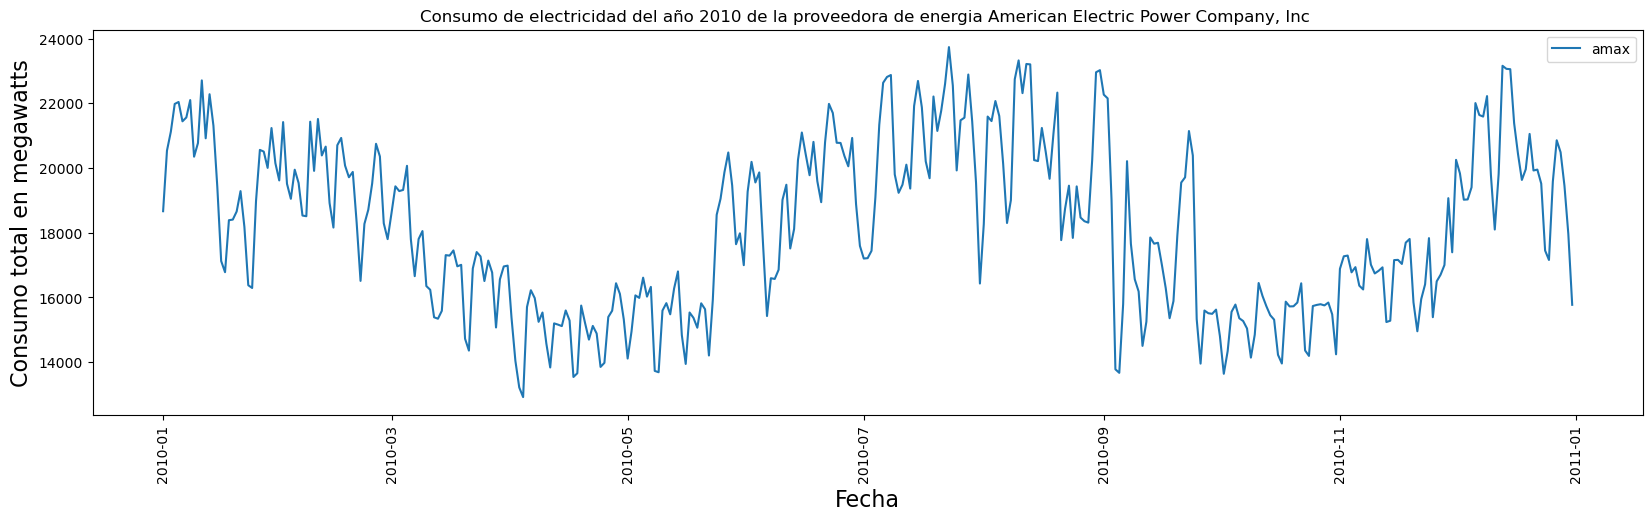

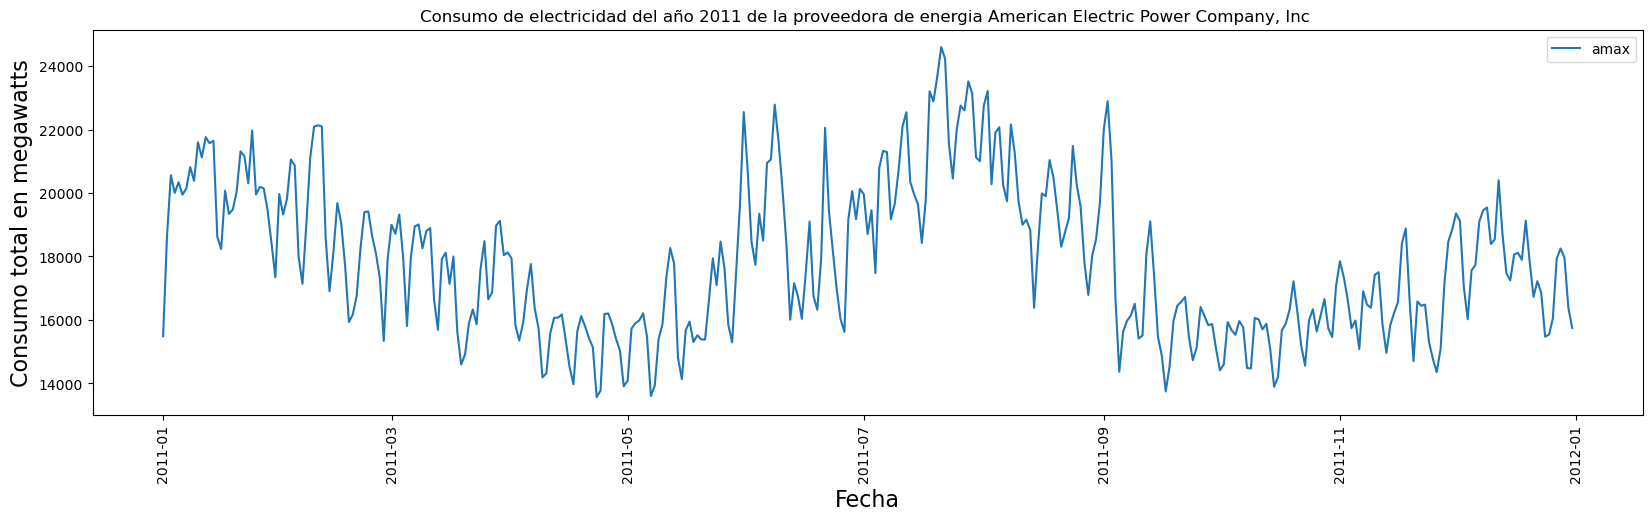

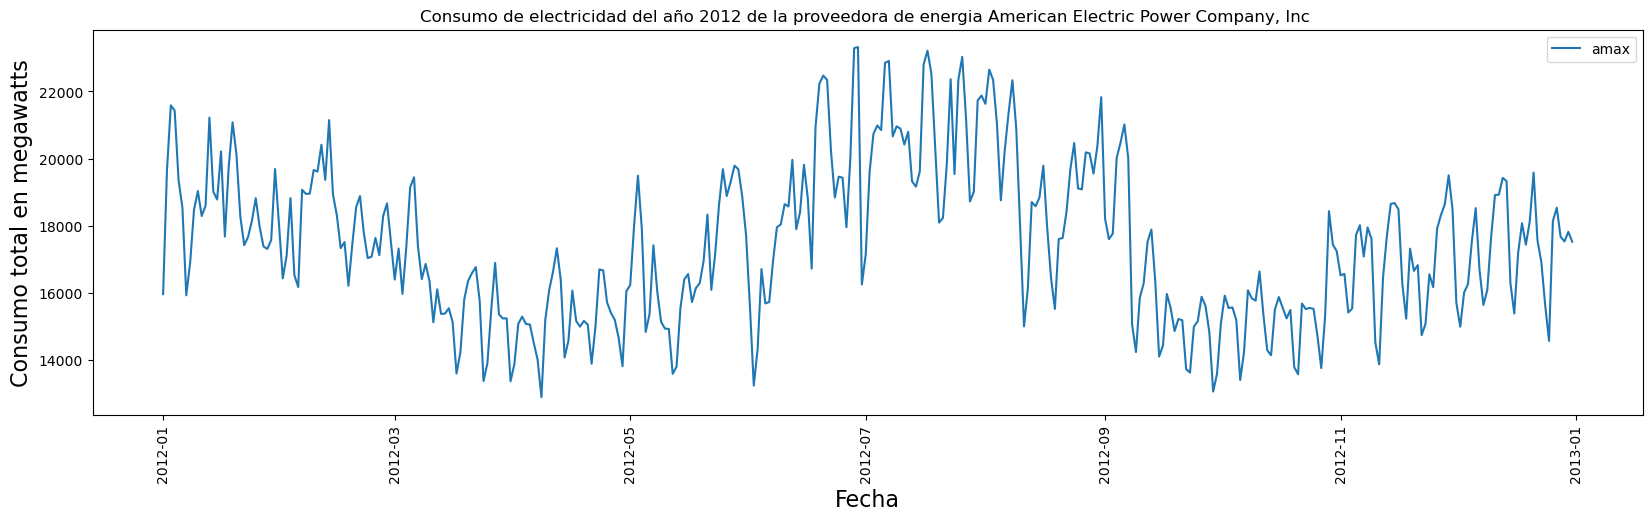

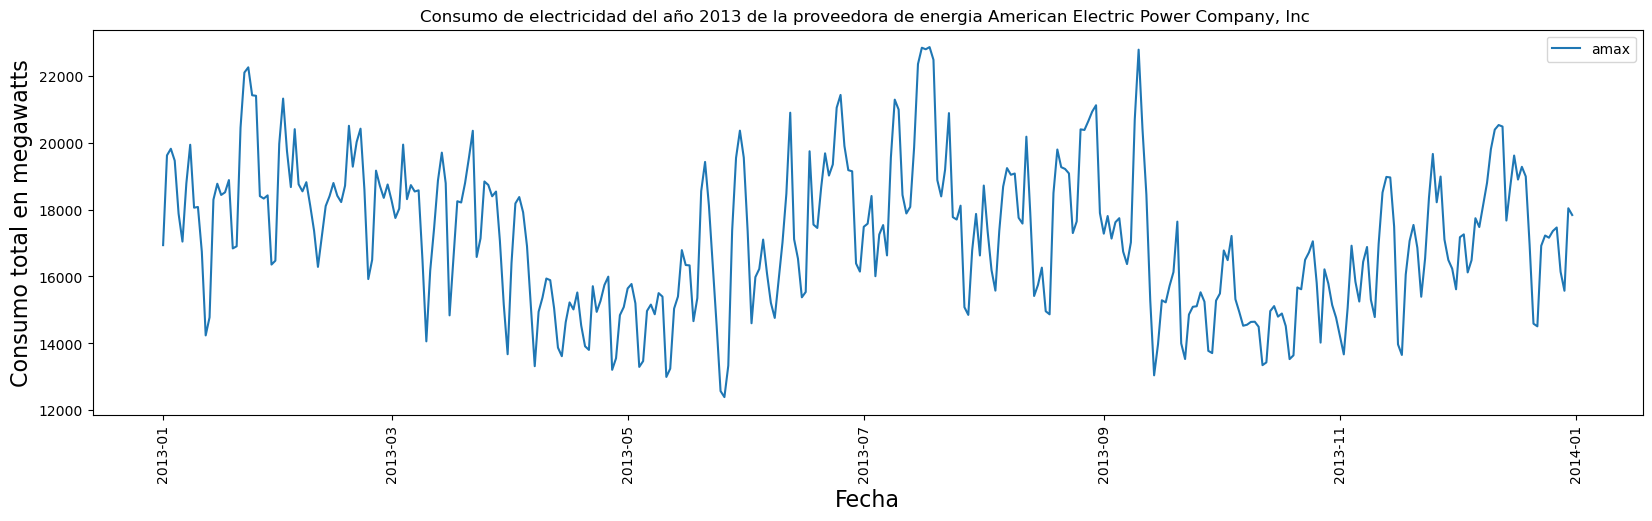

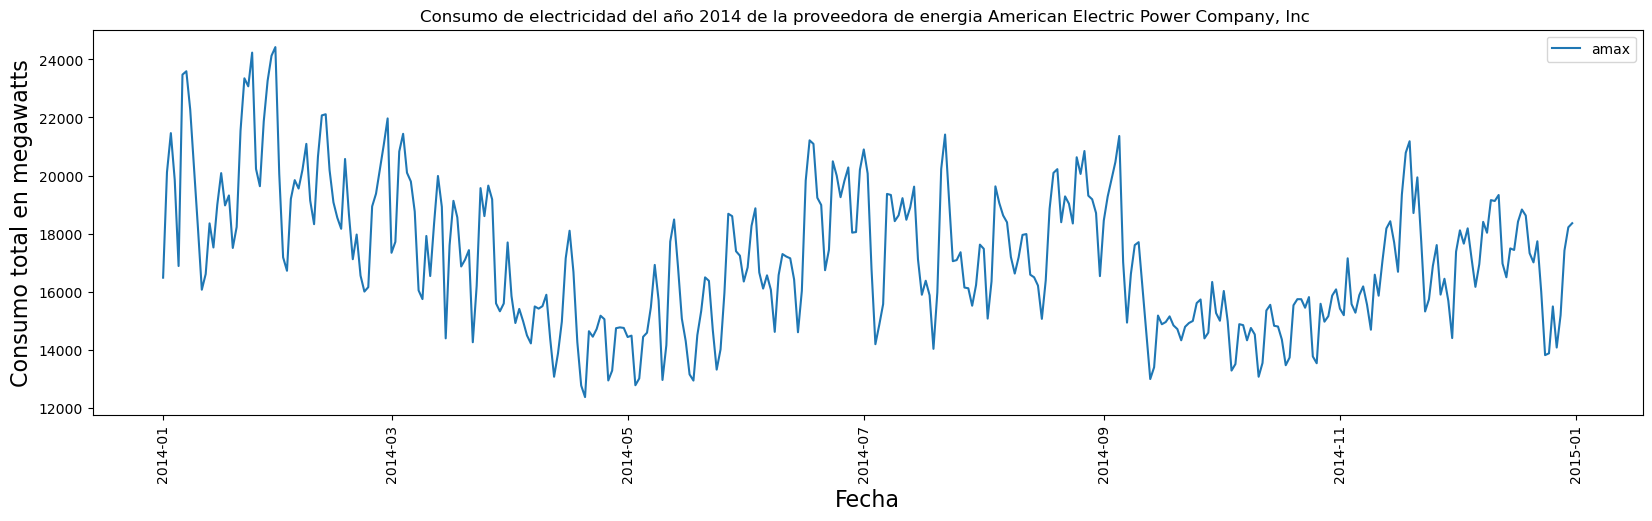

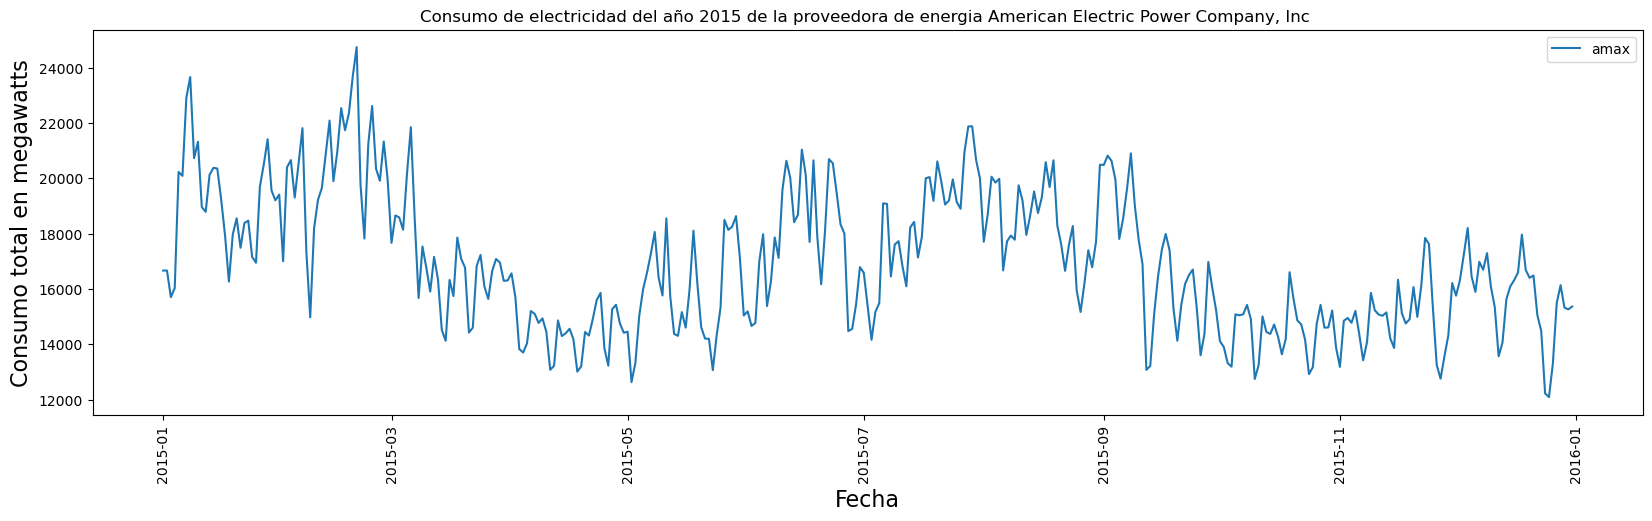

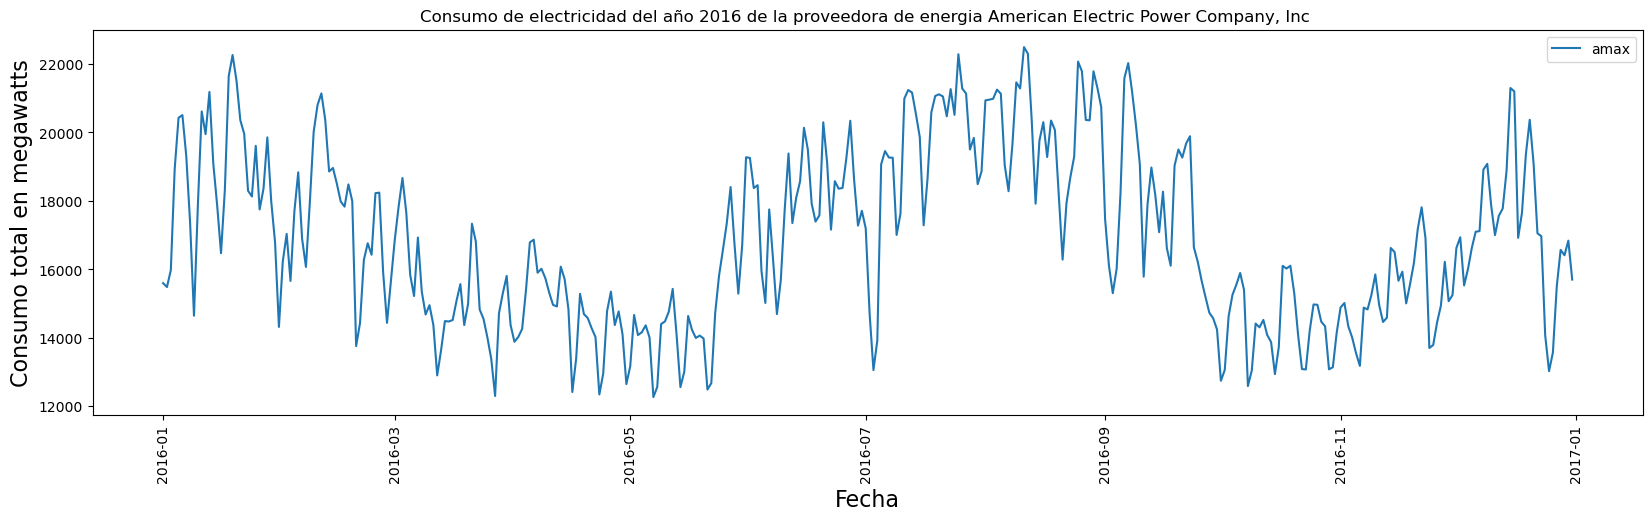

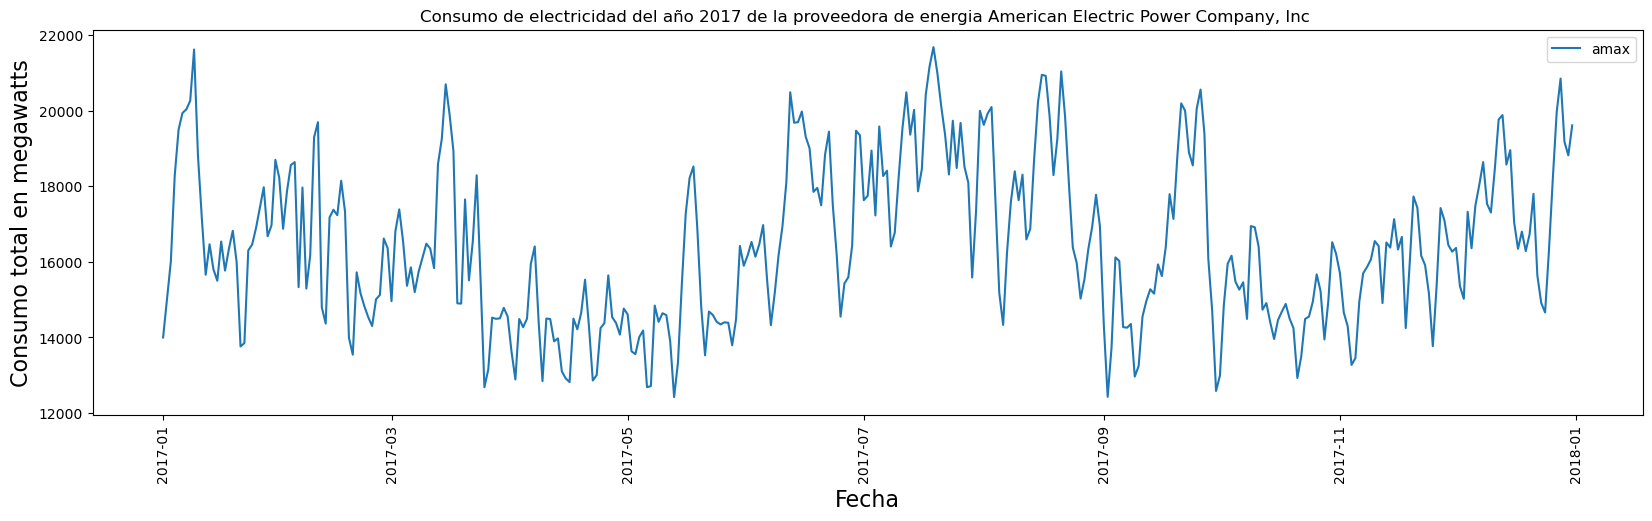

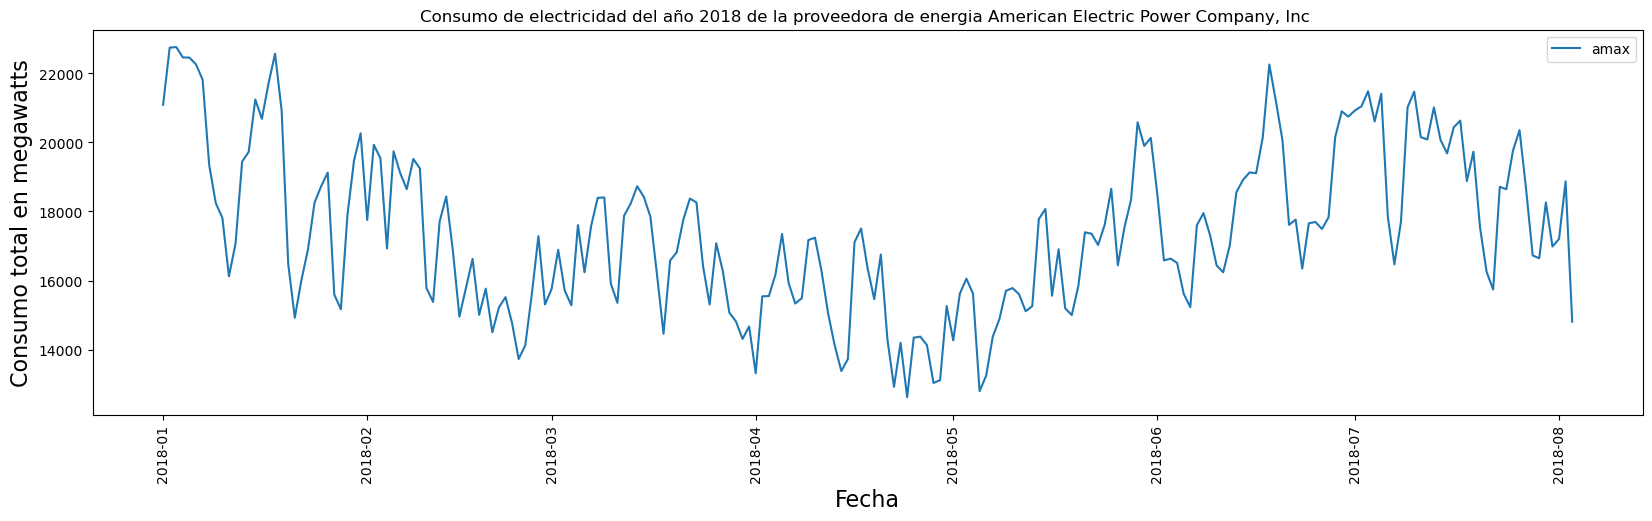

In [381]:
for i in range(14):
    dfx = df2[df2["Date"]>=datetime.date(2005+i, 1, 1)]
    dfx = dfx[dfx["Date"]<=datetime.date(2005+i, 12, 31)]
    ax = dfx.plot(x="Date",y='AEP_MW',rot=90)
    ax.set_ylabel("Consumo total en megawatts", fontsize=16)
    ax.set_xlabel("Fecha", fontsize=16)
    ax.set_title("Consumo de electricidad del año "+str(2005+i)+" de la proveedora de energia American Electric Power Company, Inc ")
    

In [382]:
years = [str(x) for x in list(range(2005,2018))]

In [383]:
import random
def randomColor():
    return ["#"+''.join([random.choice('ABCDEF0123456789') for i in range(6)])]

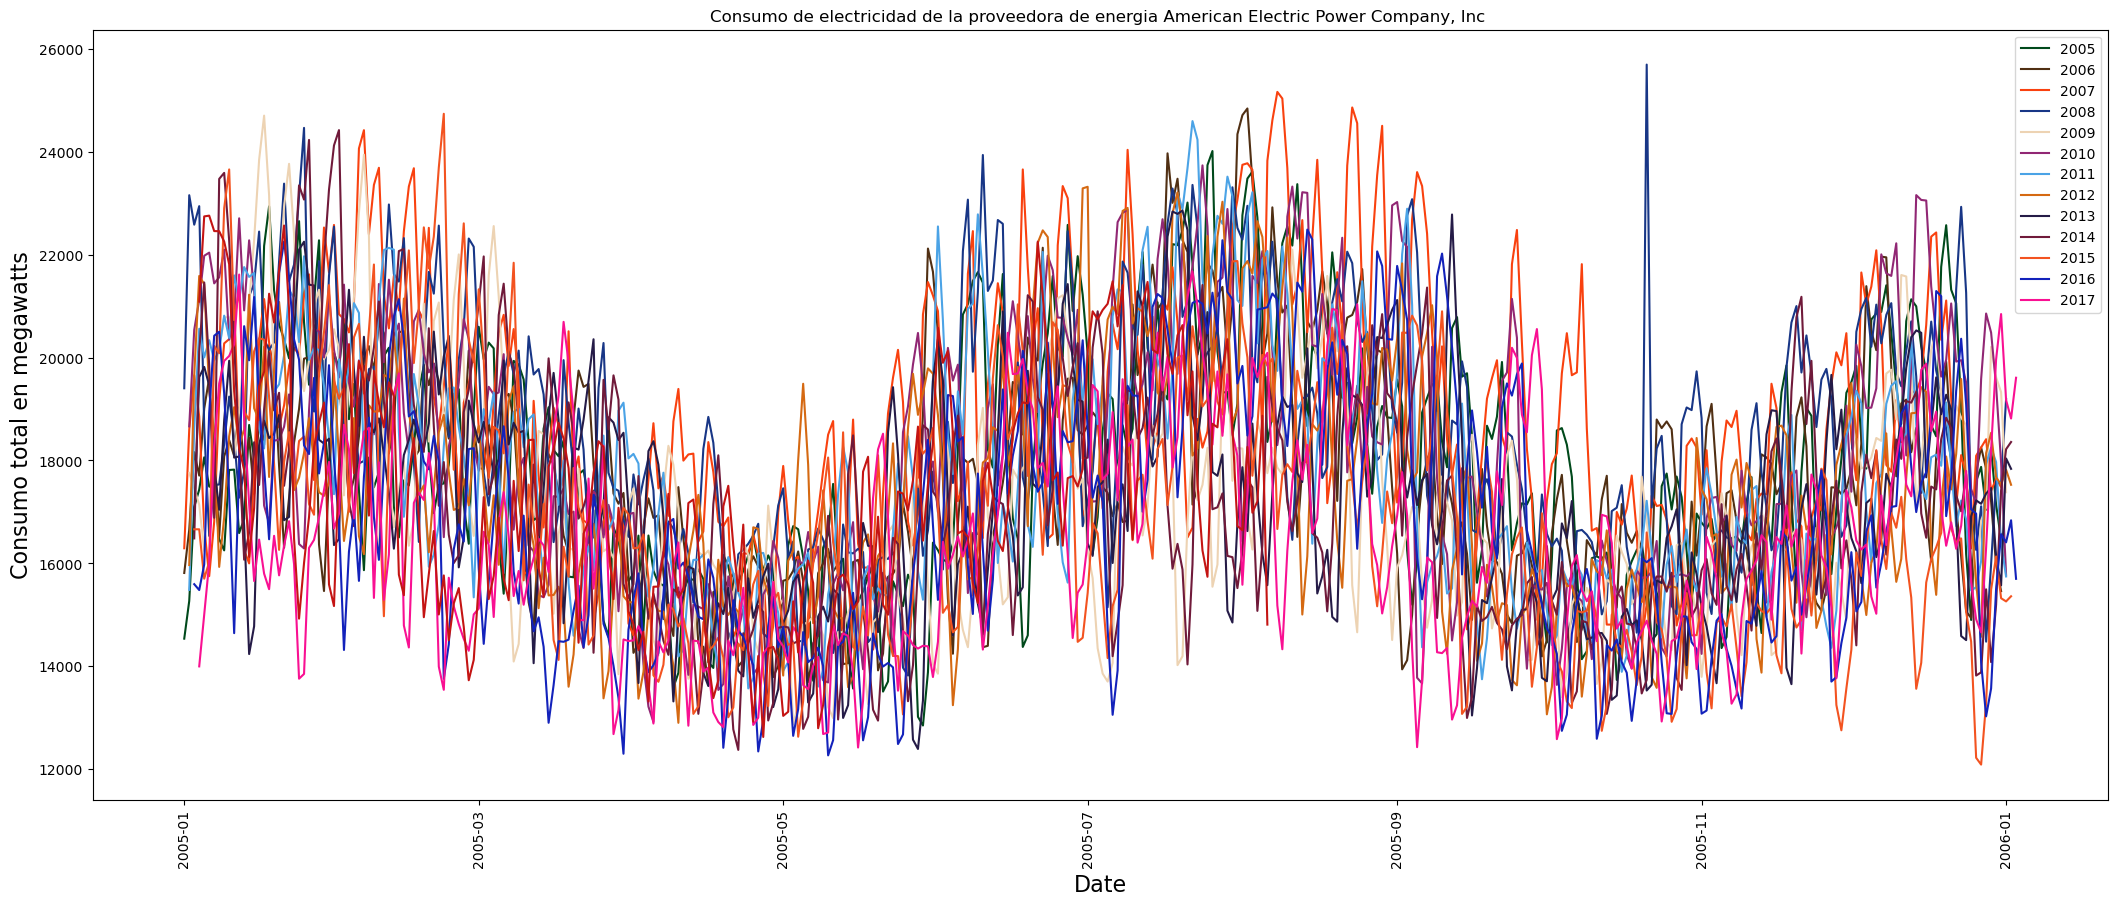

In [384]:
fig, ax = plt.subplots(1,1,figsize=(26,10))
ax.set_ylabel("Consumo total en megawatts", fontsize=16)
ax.set_xlabel("Fecha", fontsize=16)
ax.set_title("Consumo de electricidad de la proveedora de energia American Electric Power Company, Inc ")
for i in range(14):
    color=randomColor()
    dfx = df2[df2["Date"]>=datetime.date(2005+i, 1, 1)]
    dfx = dfx[dfx["Date"]<=datetime.date(2005+i, 12, 31)]
    dfx["Date"] = dfx["Date"] - datetime.timedelta(days=i*365)
    ax = dfx.plot(x="Date",y='AEP_MW',rot=90,color=color,ax=ax)
    ax.legend(years);

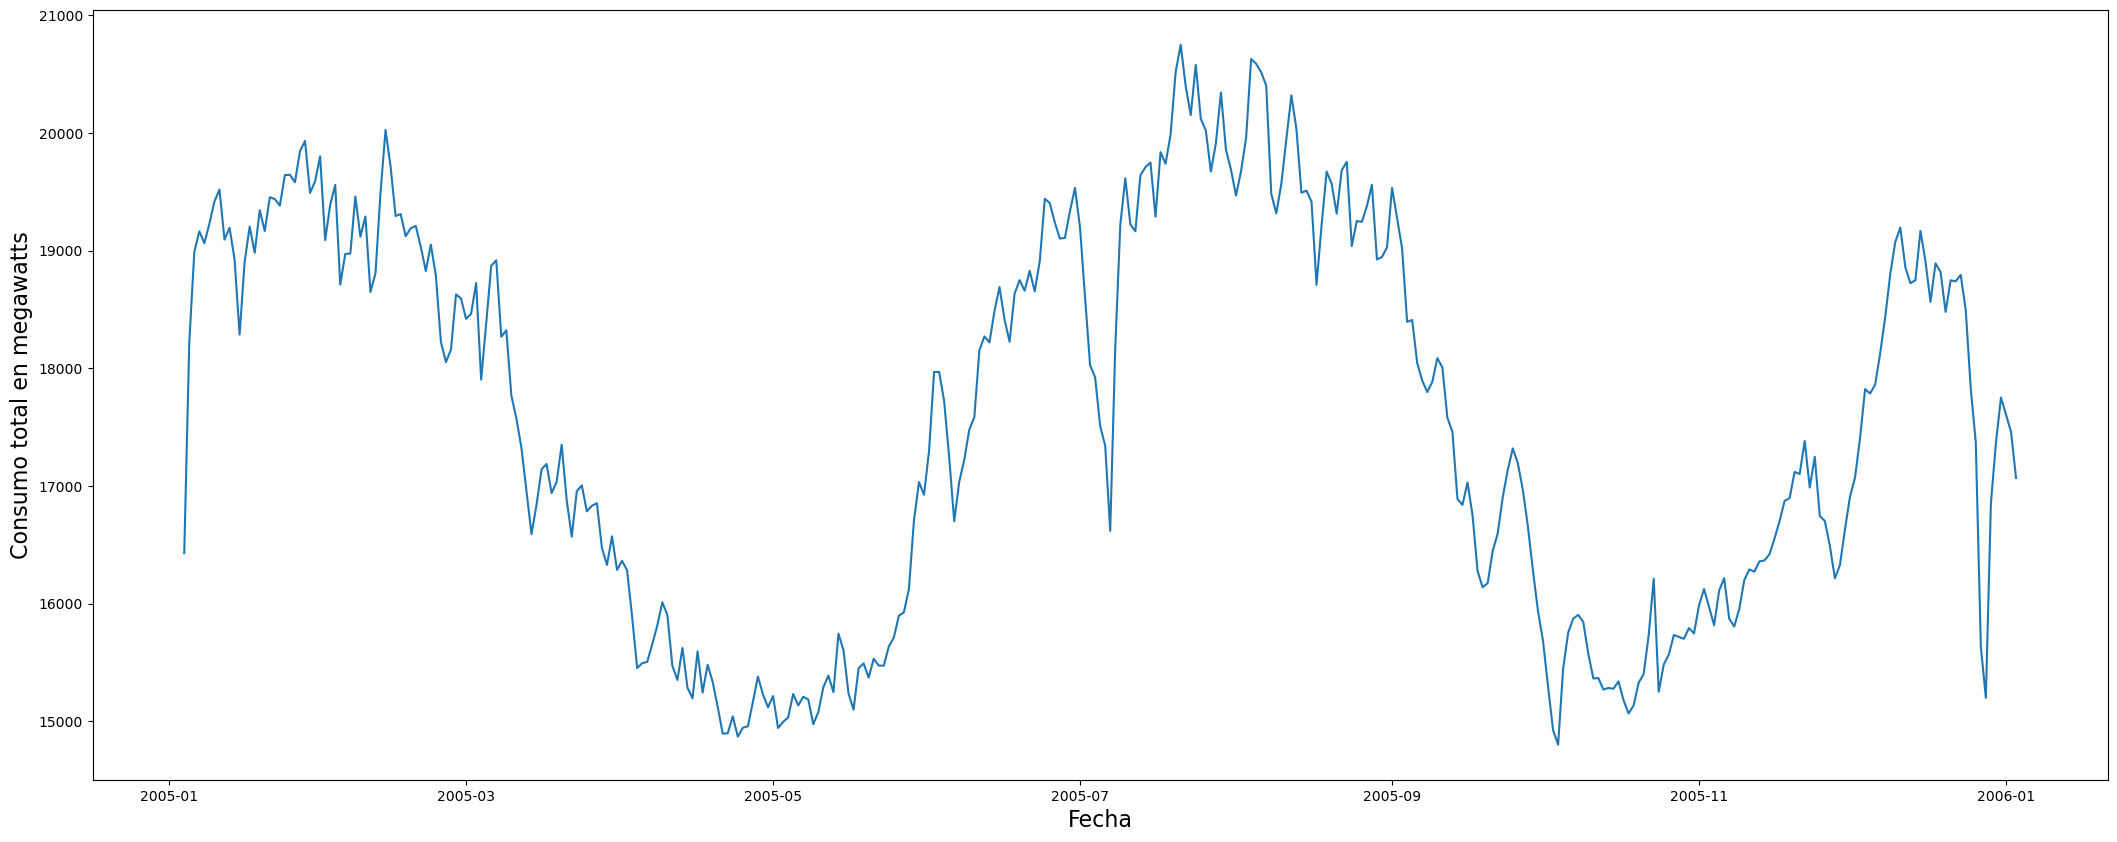

In [385]:
fig, ax = plt.subplots(1,1,figsize=(26,10))
ax.set_ylabel("Consumo total en megawatts", fontsize=16)
ax.set_xlabel("Fecha", fontsize=16)
listOfValues=np.array([])
for i in range(13):
    color=randomColor()
    dfx = df2[df2["Date"]>=datetime.date(2005+i, 1, 1)]
    dfx = dfx[dfx["Date"]<=datetime.date(2005+i, 12, 31)]
    dfx["Date"] = dfx["Date"] - datetime.timedelta(days=i*365)
    if(listOfValues.size==0):
        listOfValues=np.array(dfx["AEP_MW"]["amax"])
    else:
        listOfValues+=np.array(dfx["AEP_MW"]["amax"])
    
    #ax = dfx.plot(x="Date",y='AEP_MW',rot=90,color=color,ax=ax)
    #ax.legend(years);
    

plt.plot(dfx["Date"],listOfValues/13)




plt.show()

Viendo esta serie de tiempo podemos ver una estacionalidad a los largo del año, si bien tiene cambios, en general el consumo sube bastante durante tanto los meses mas calurosos del verano y los meses mas frios del invierno.

# Descompocision usando modelo aditivo

## Additive

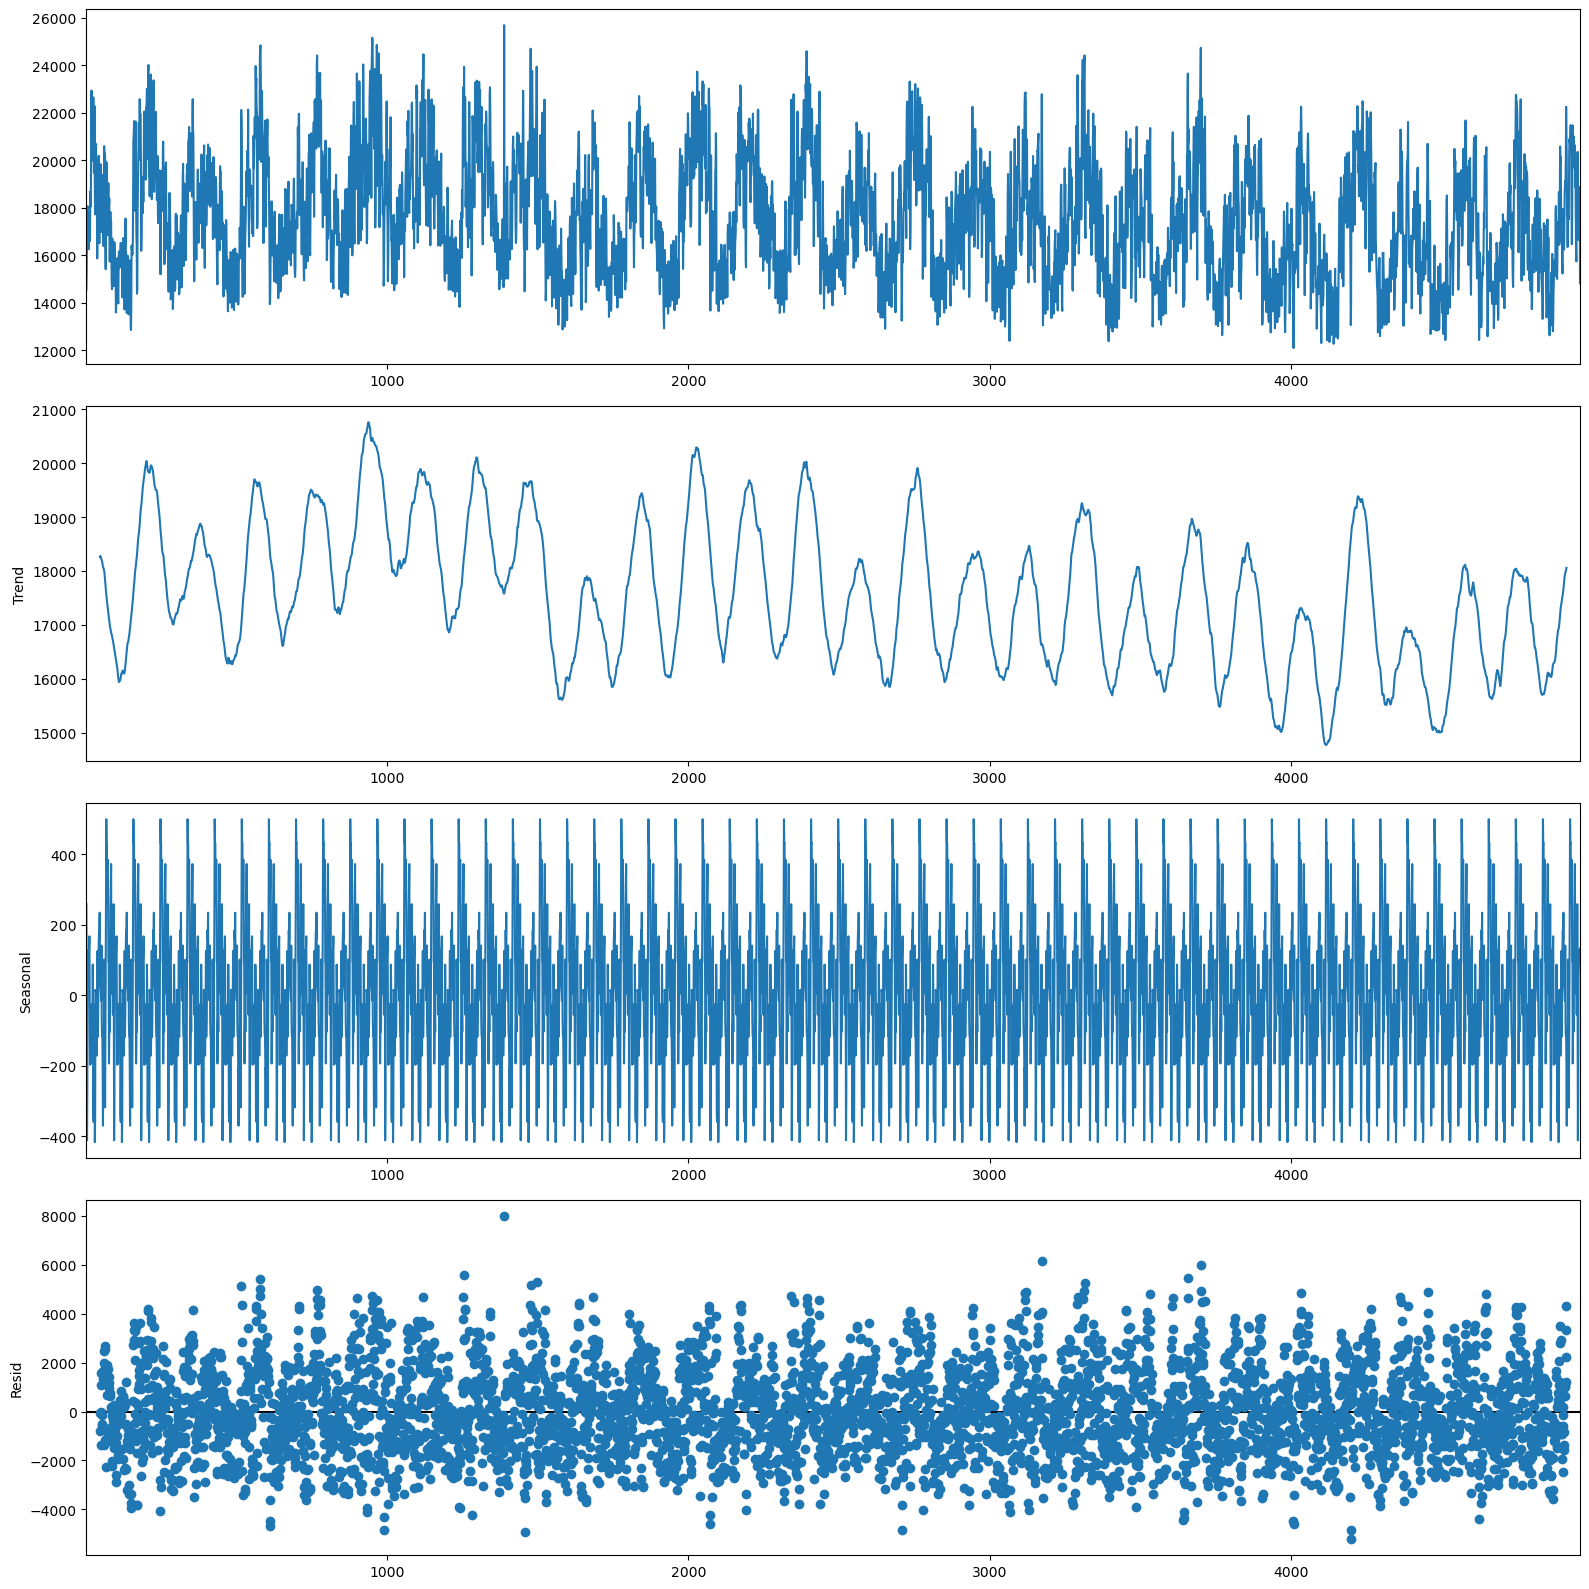

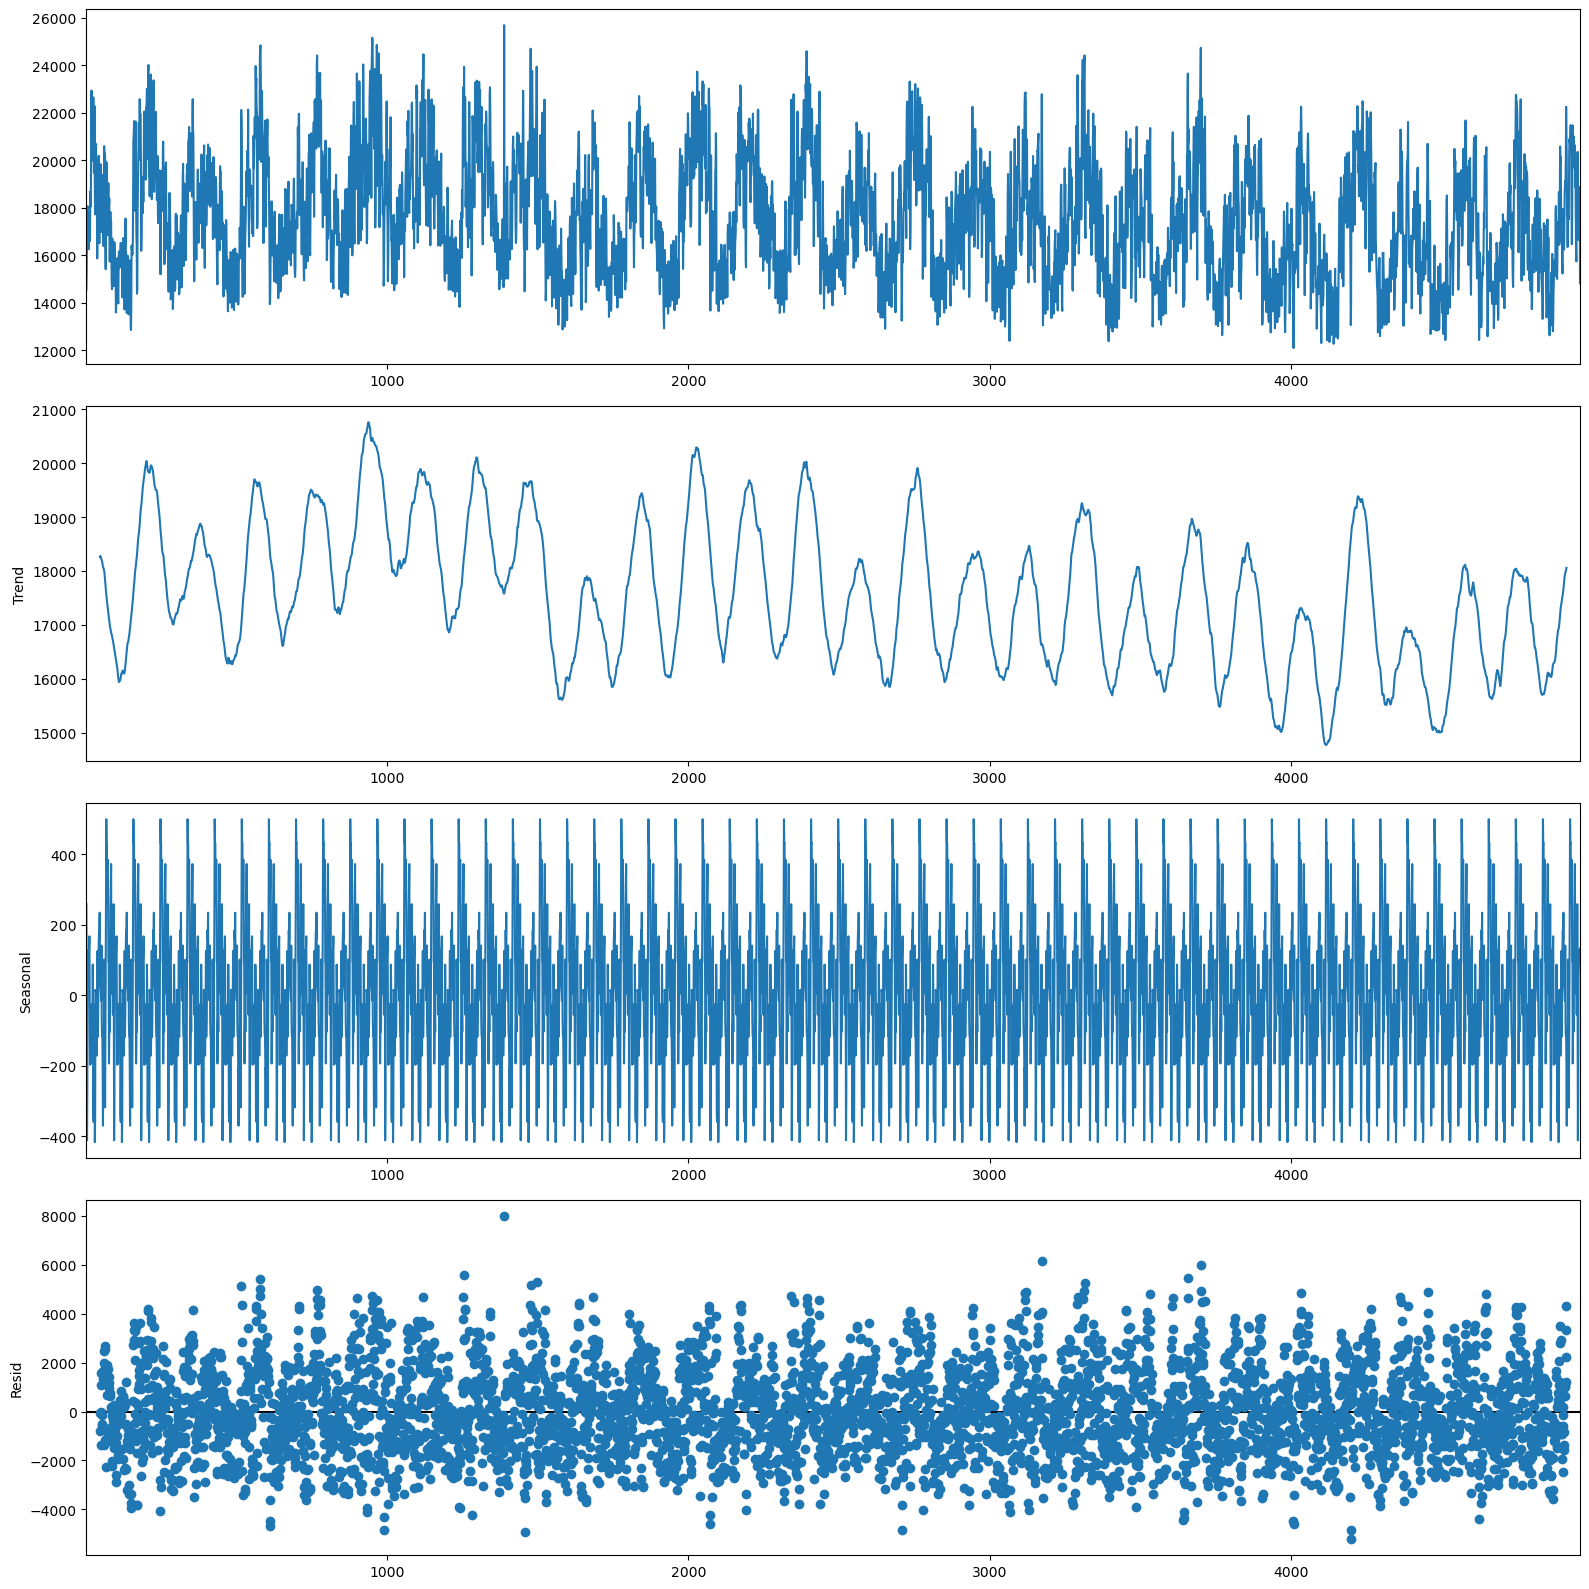

In [387]:
matplotlib.rcParams['figure.figsize'] = [16,16]
period=90
addit=sm.tsa.seasonal_decompose(df2["AEP_MW"], model='additive', period=period)
addit.plot()

## Multiplicative

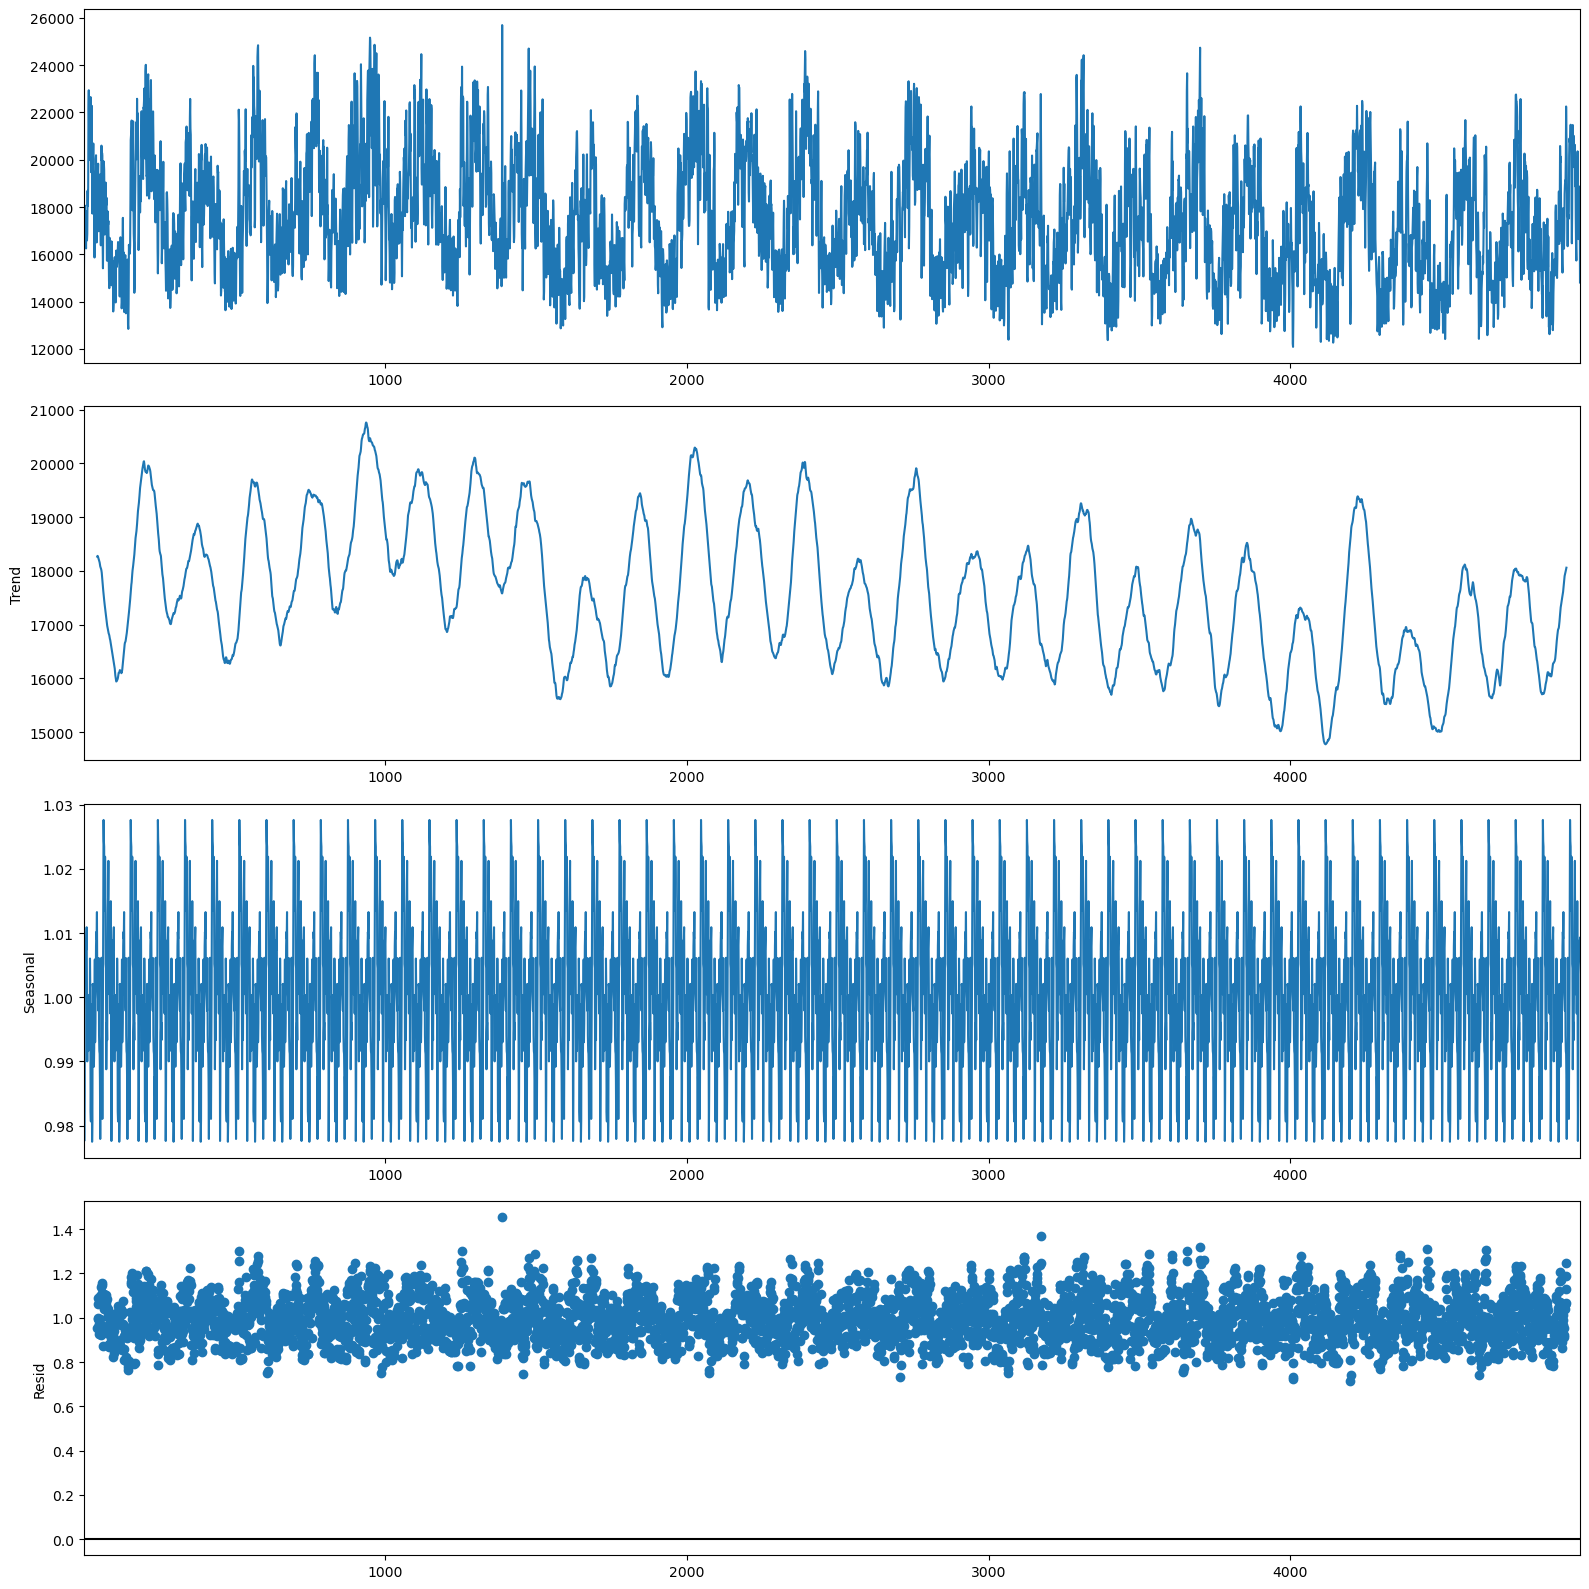

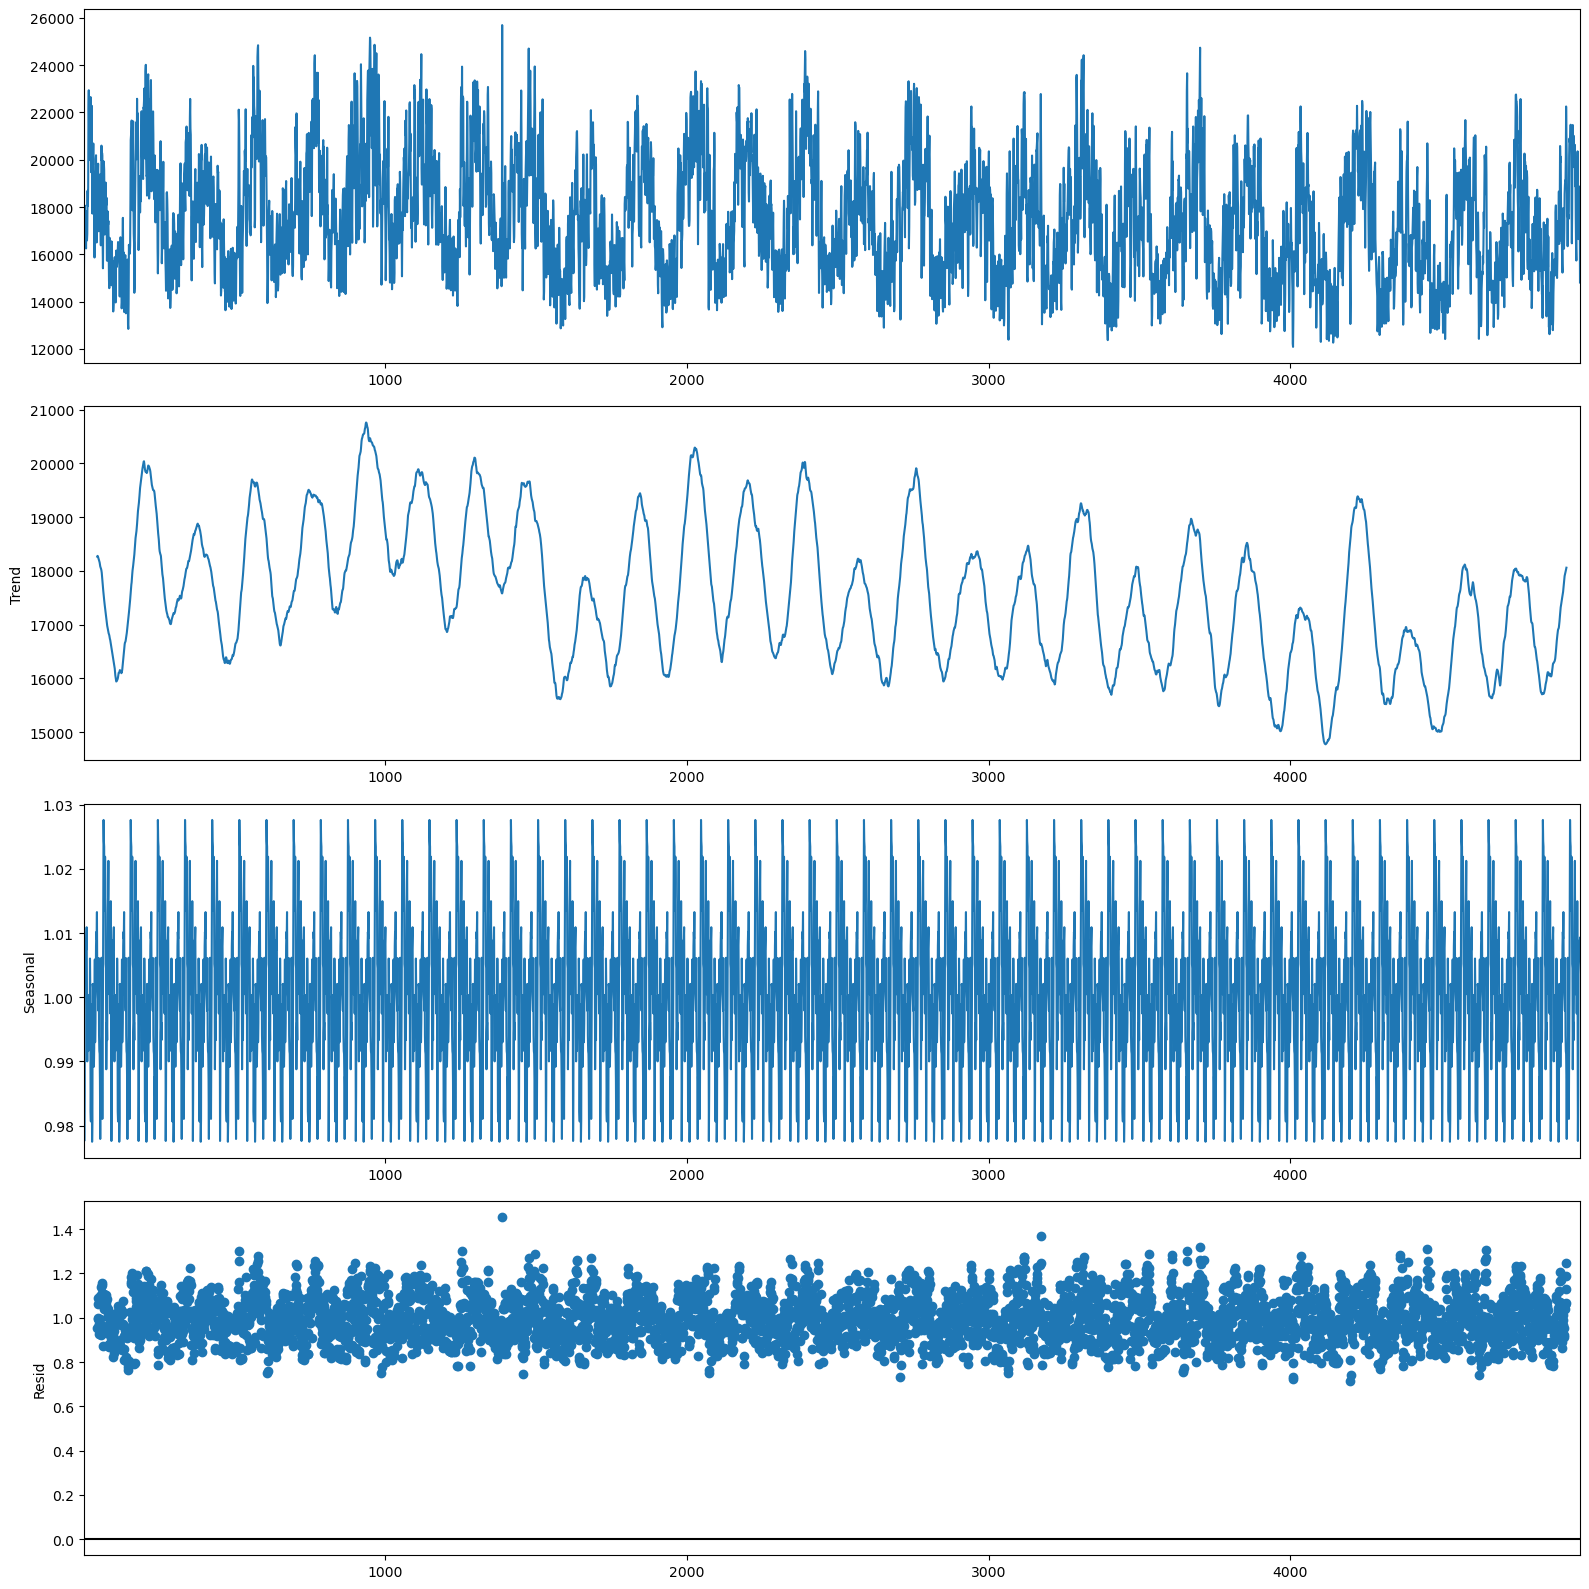

In [388]:
matplotlib.rcParams['figure.figsize'] = [16,16]
mult = sm.tsa.seasonal_decompose(df2["AEP_MW"] , model='multiplicative', period=period)
mult.plot()

# Extraer Tendendcia

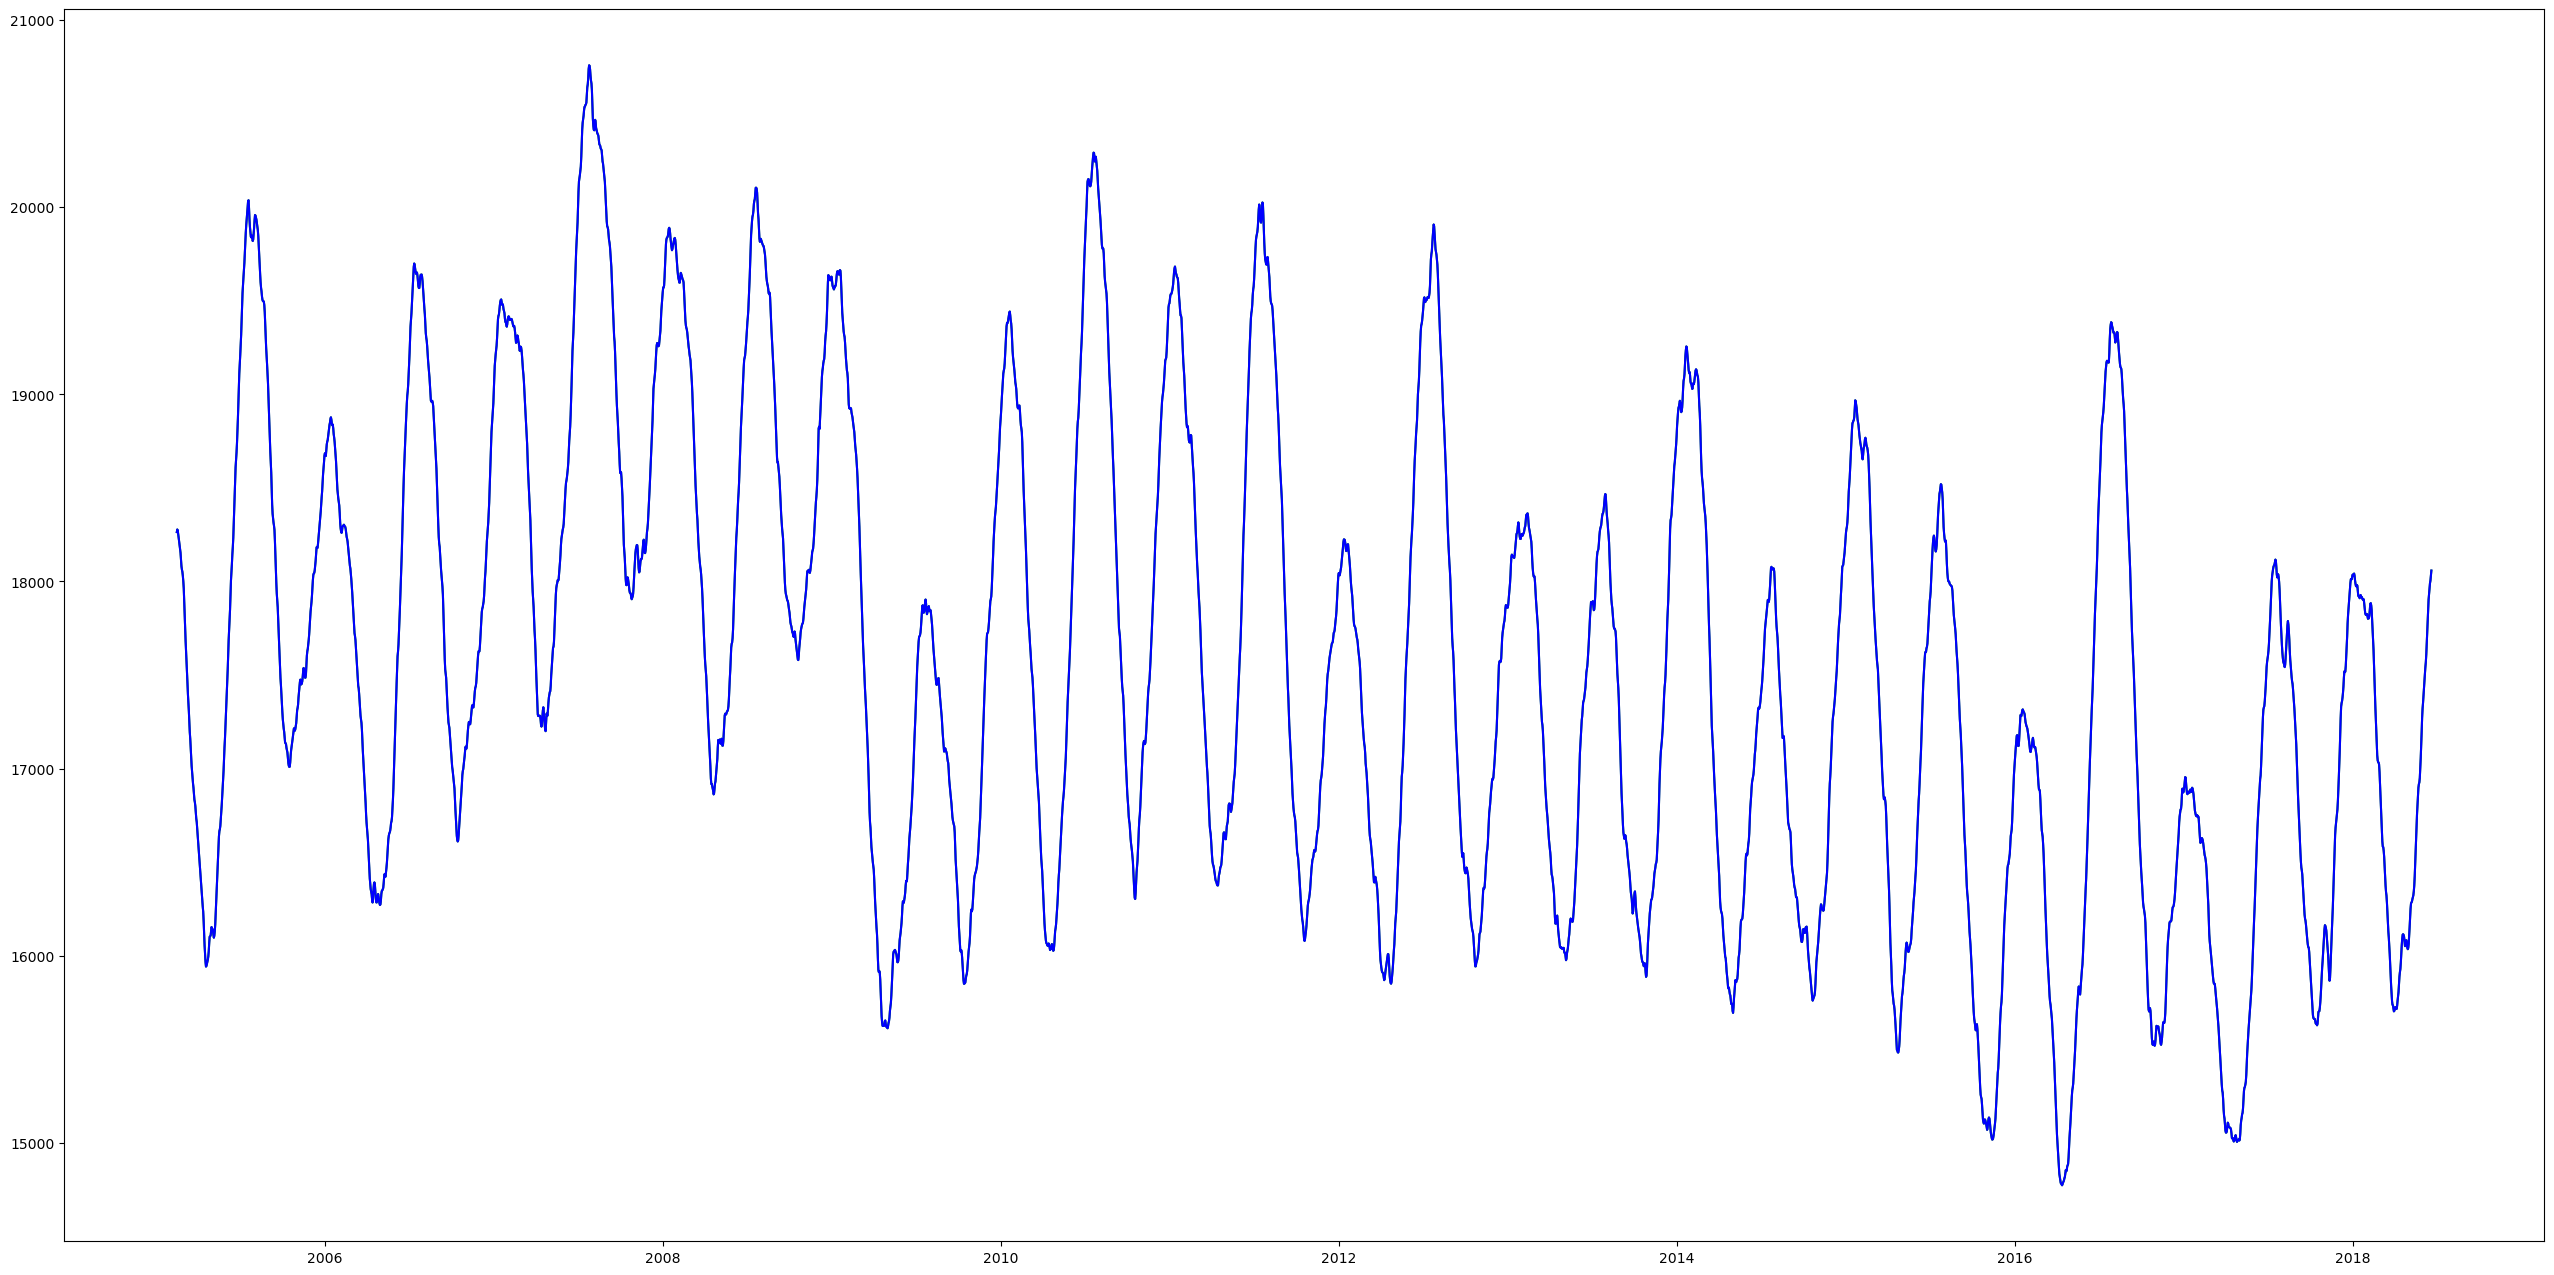

In [389]:
matplotlib.rcParams['figure.figsize'] = [32,16]
period=90
dfx = df2[df2["Date"]>=datetime.date(2006, 1, 1)]
dfx = dfx[dfx["Date"]<=datetime.date(2006, 12, 31)]
addit = sm.tsa.seasonal_decompose(df2["AEP_MW"], model='additive', period=period)
mult = sm.tsa.seasonal_decompose(df2["AEP_MW"], model='multiplicative', period=period)
plt.plot(df2["Date"],addit.trend, color="green")
plt.plot(df2["Date"],mult.trend, color="blue")
plt.show()

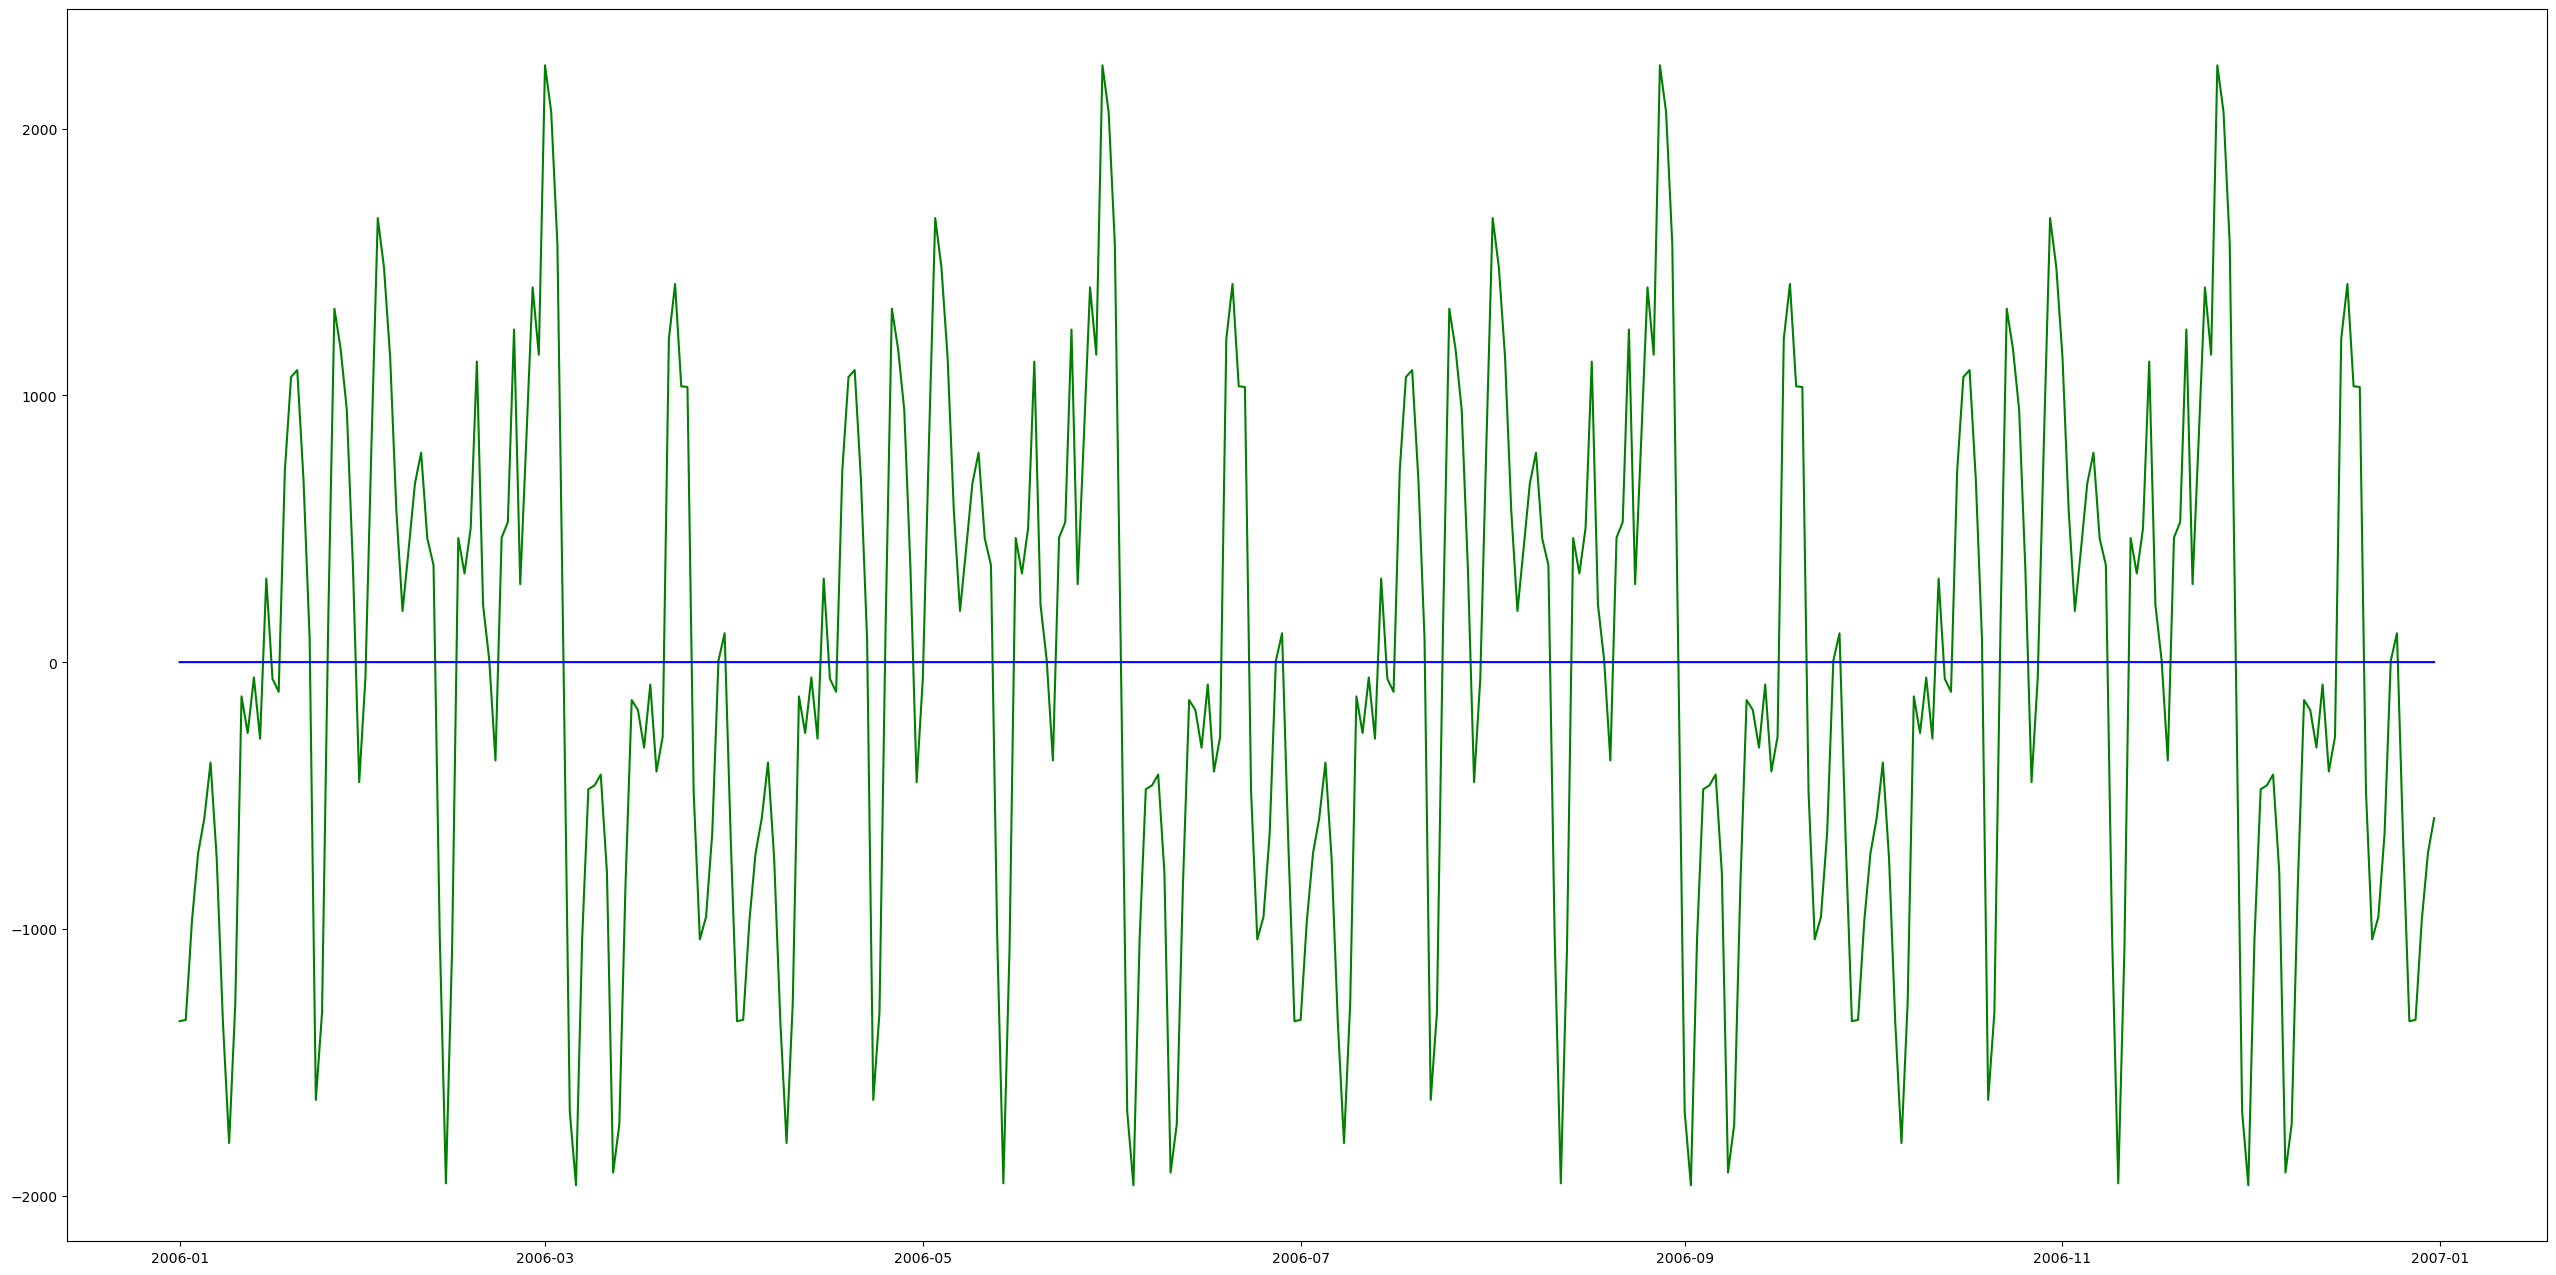

In [390]:
period=90
dfx = df2[df2["Date"]>=datetime.date(2006, 1, 1)]
dfx = dfx[dfx["Date"]<=datetime.date(2006, 12, 31)]
#dfx=df2
addit = sm.tsa.seasonal_decompose(dfx["AEP_MW"], model='additive', period=period)
mult = sm.tsa.seasonal_decompose(dfx["AEP_MW"], model='multiplicative', period=period)
plt.plot(dfx["Date"],addit.seasonal, color="green")
plt.plot(dfx["Date"],mult.seasonal, color="blue")
plt.show()

## Ajustar a un modelo deterministico

In [391]:
z  = np.polyfit(list(range(len(df2["AEP_MW"]))),list(df2["AEP_MW"]["amax"]), 30)

C:\Users\Colo\miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


In [393]:
p = np.poly1d(z)

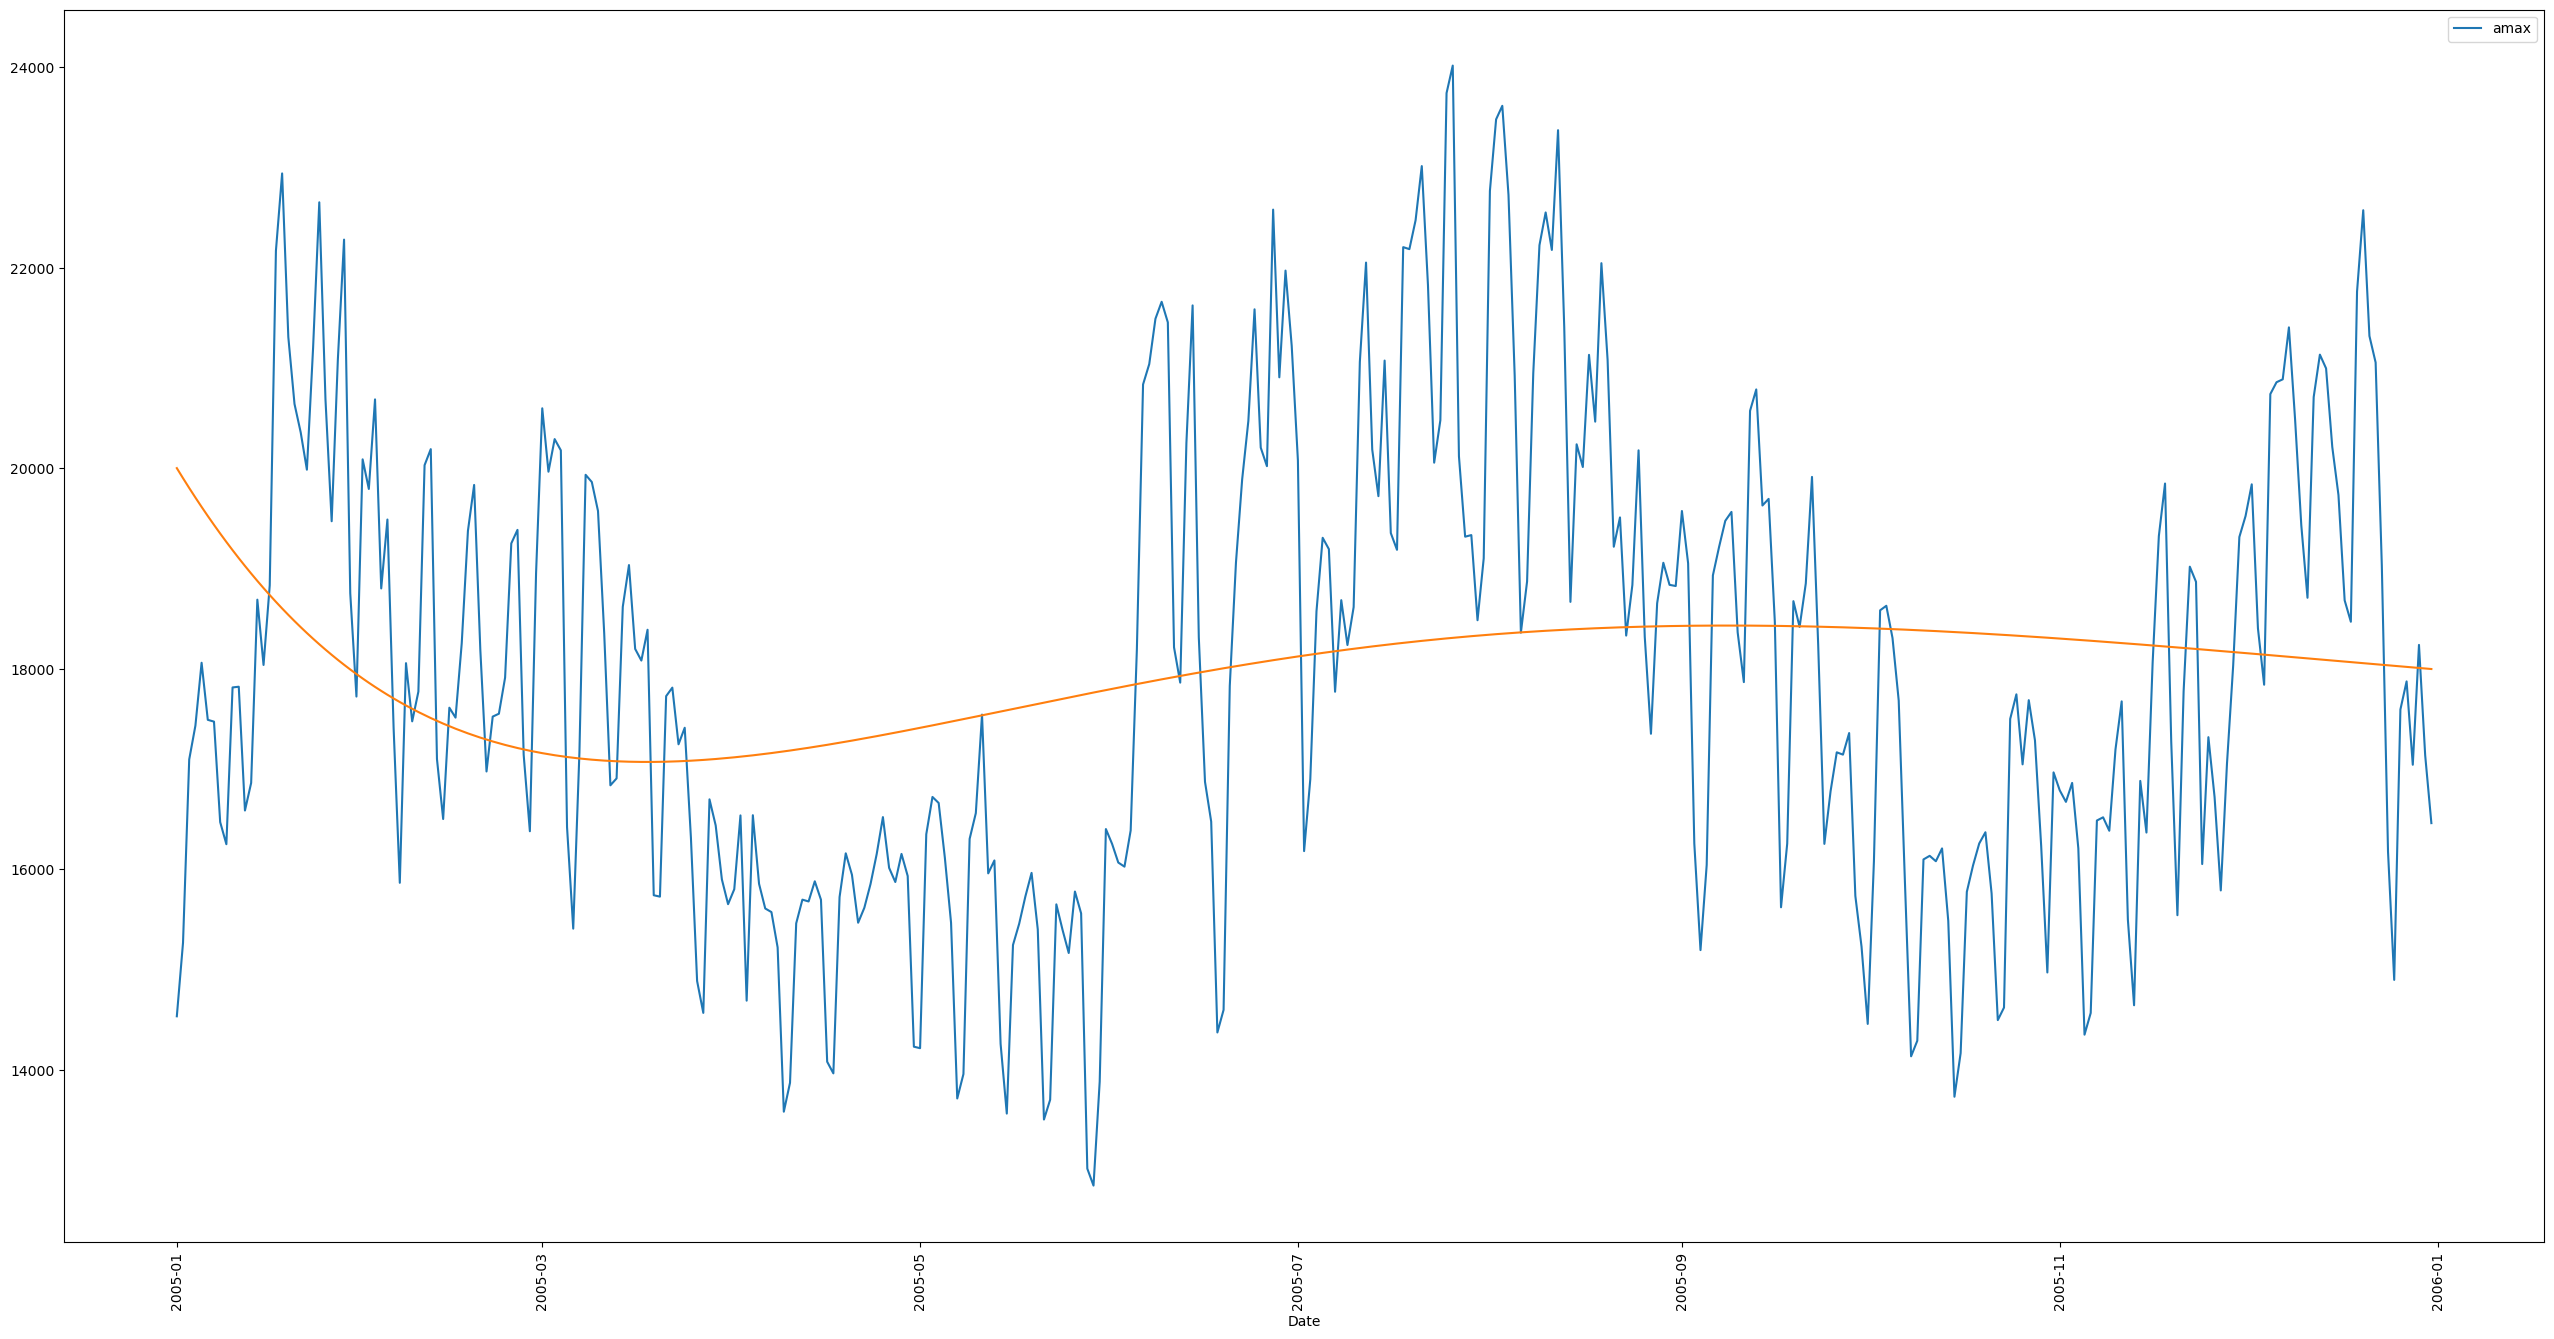

In [394]:
xp = np.linspace(0, 365, 365)


#dfx = df2[df2["Date"]>=datetime.date(2005+i, 1, 1)]
dfx = df2[0:365]
ax = dfx.plot(x="Date",y='AEP_MW',rot=90)
plt.plot(df2["Date"][0:365], p(xp))


plt.show()

In [395]:
arr = np.array(xp)
arr = arr = arr.astype('int')

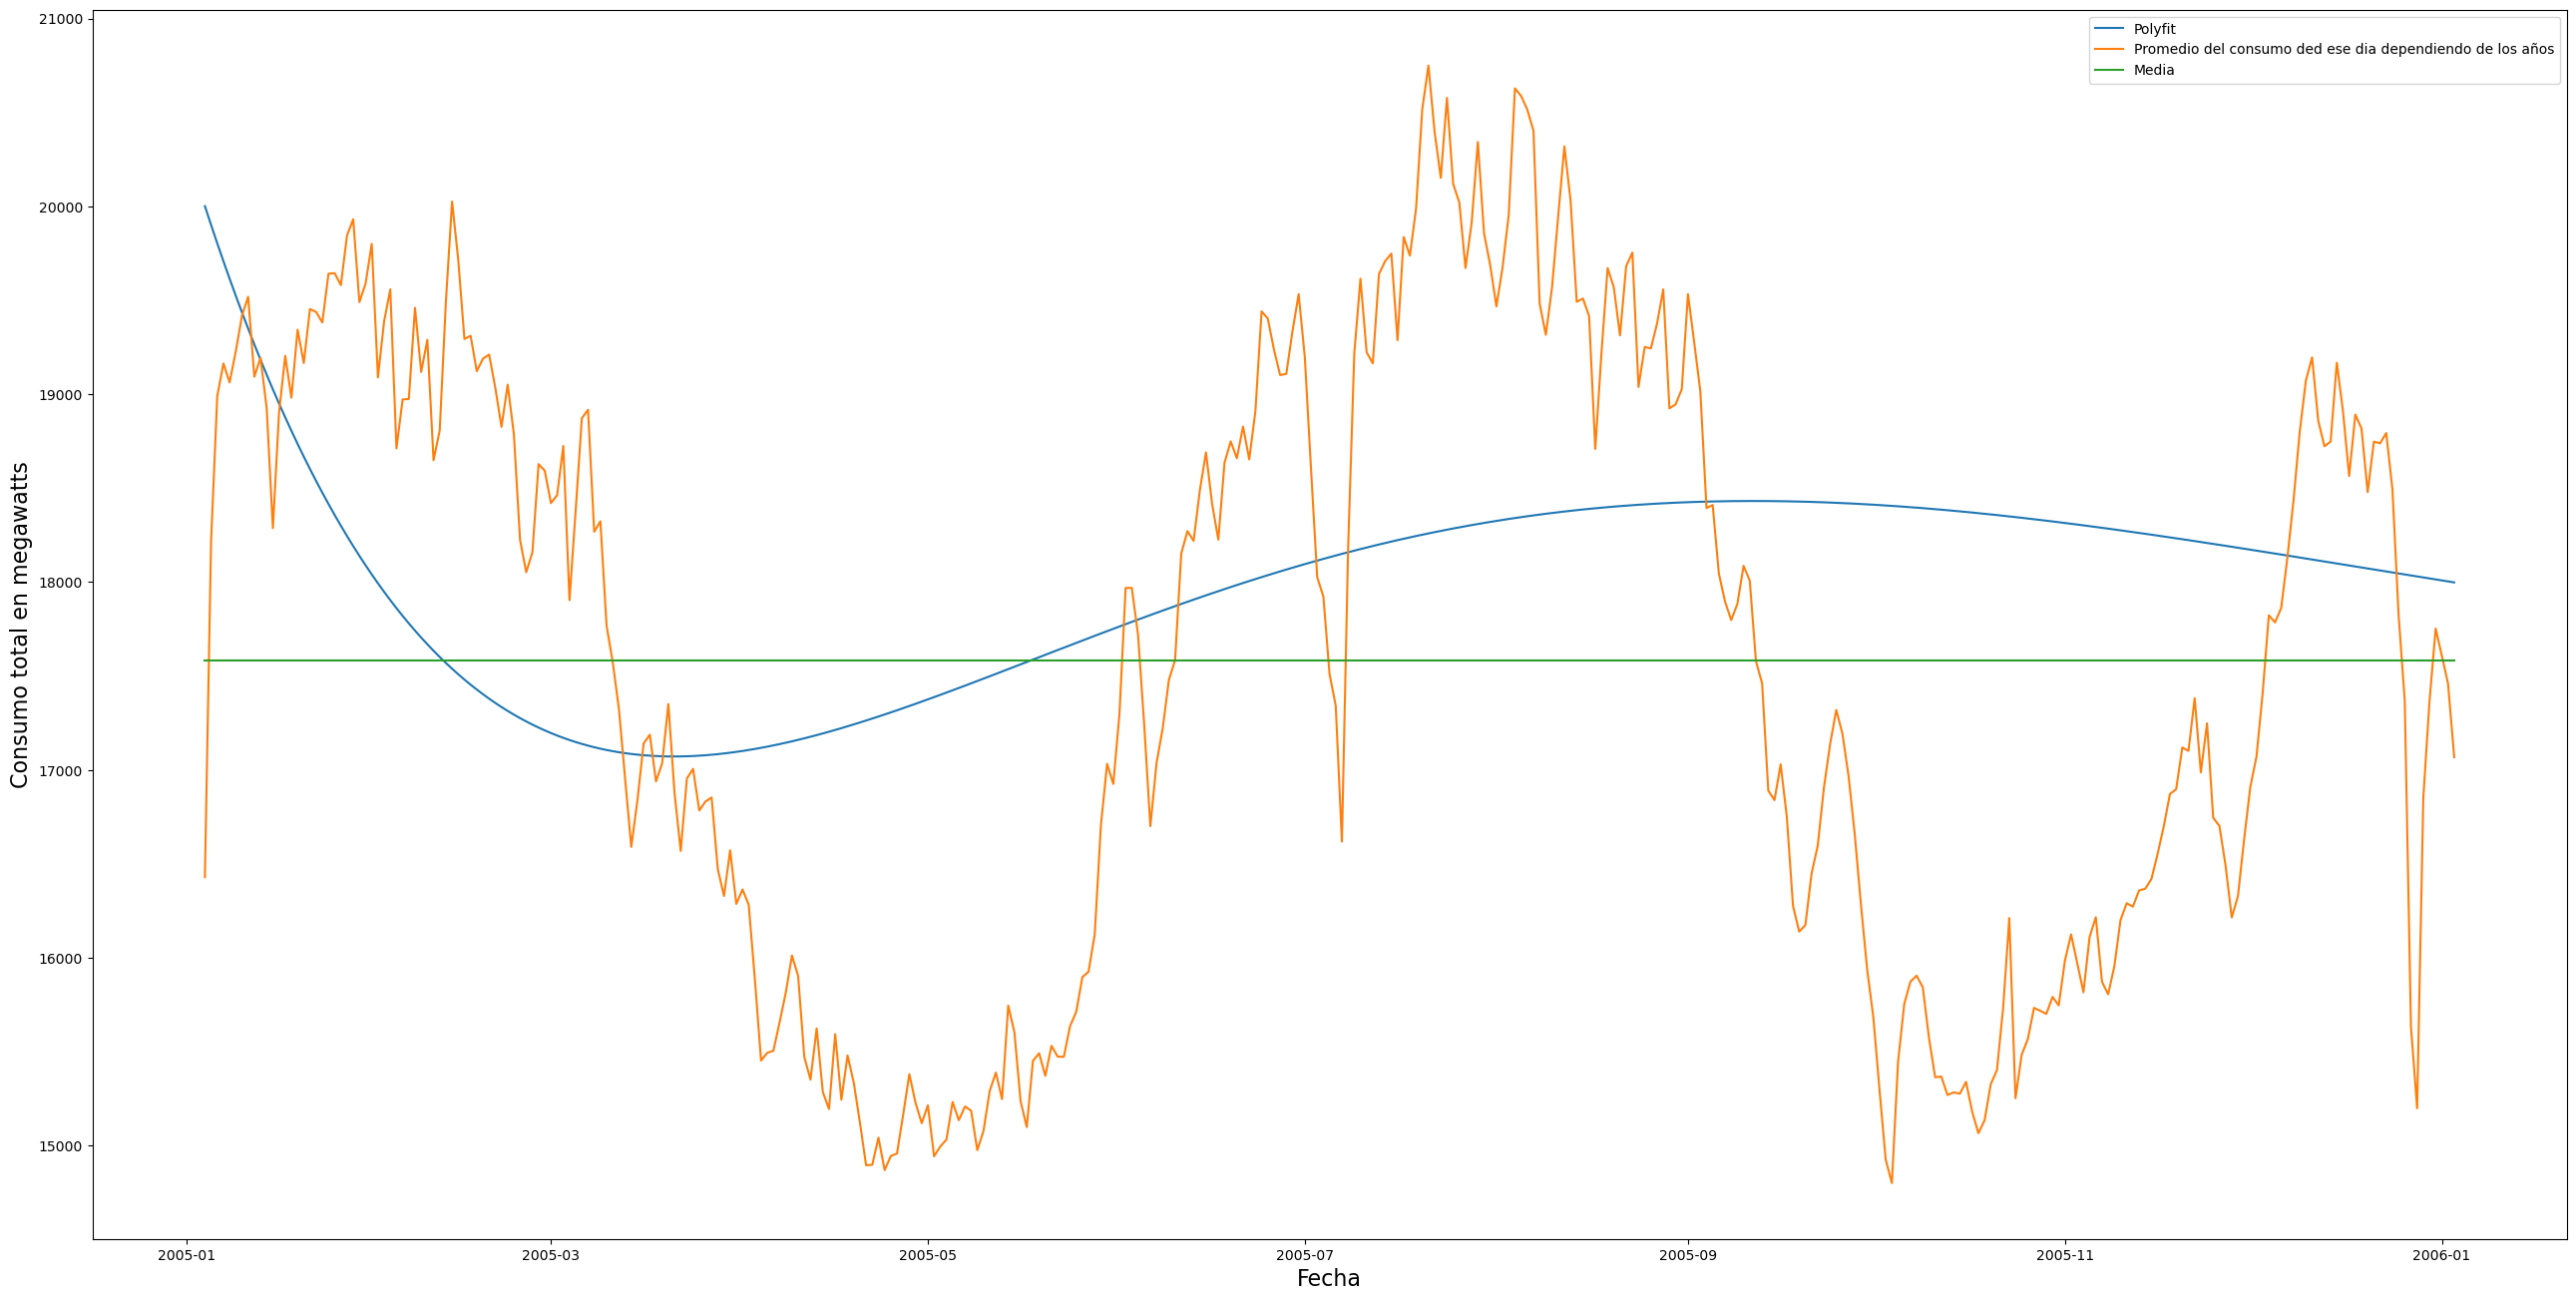

In [396]:
fig, ax = plt.subplots(1,1,figsize=(32,16))
#matplotlib.rcParams['figure.figsize'] = [32,16]
ax.set_ylabel("Consumo total en megawatts", fontsize=16)
ax.set_xlabel("Fecha", fontsize=16)
listOfValues=np.array([])
for i in range(13):
    color=randomColor()
    dfx = df2[df2["Date"]>=datetime.date(2005+i, 1, 1)]
    dfx = dfx[dfx["Date"]<=datetime.date(2005+i, 12, 31)]
    dfx["Date"] = dfx["Date"] - datetime.timedelta(days=i*365)
    if(listOfValues.size==0):
        listOfValues=np.array(dfx["AEP_MW"]["amax"])
    else:
        listOfValues+=np.array(dfx["AEP_MW"]["amax"])
    
    #ax = dfx.plot(x="Date",y='AEP_MW',rot=90,color=color,ax=ax)
    #ax.legend(years);
    

plt.plot(dfx["Date"], p(xp))
plt.plot(dfx["Date"], listOfValues/13)
plt.plot(dfx["Date"], np.ones(365)*np.sum(listOfValues/13)/365)
ax.legend(["Polyfit","Promedio del consumo ded ese dia dependiendo de los años","Media"]);


plt.show()

# Clase 4

## Tests de autocorrelacion

In [11]:
stattools.adfuller(df["Close"])

(2.9480813641719057,
 1.0,
 30,
 4850,
 {'1%': -3.4316990235892413,
  '5%': -2.8621361184931735,
  '10%': -2.5670873152938674},
 28460.730350878195)

Basado en el nivel de significancia de 0.05 y el p valor del test de dickey-fuller de 1, no podemos rechazar la hipotesis nula. Por lo tanto segun este test, la serie NO es estacionaria.

In [12]:
stattools.kpss(df["Close"])

C:\Users\Colo\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


(8.023649823699262,
 0.01,
 42,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Basado en el nivel de significancia de 0.05 y el p valor del test KPSS de 0.01,podemos rechazar la hipotesis nula. Por lo tanto segun este test, la serie NO es estacionaria.

De acuerdo a la docunmentacion de statsmodels, en este caso, la serie es difference stationary y por lo tanto, debemos aplicar diferenciacion para poder hacerla estacionaria.

In [13]:
#Aplicacmos differenciacion(el default esta en 1)
df_diff = tsa.statespace.tools.diff(df["Close"],2)

In [14]:
stattools.adfuller(df_diff)

(-23.66358493818111,
 0.0,
 31,
 4847,
 {'1%': -3.4316998589961156,
  '5%': -2.862136487566397,
  '10%': -2.567087511766811},
 28574.63825555409)

Basado en el nivel de significancia de 0.05 y el p valor del test de dickey-fuller de 0, podemos rechazar la hipotesis nula. Por lo tanto segun este test, la serie es estacionaria.

In [15]:
stattools.kpss(df_diff)

C:\Users\Colo\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


(0.040122751482903736,
 0.1,
 258,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Basado en el nivel de significancia de 0.05 y el p valor del test KPSS de 0.1,no podemos rechazar la hipotesis nula. Por lo tanto segun este test, la serie es estacionaria.

## Graficar autocorrelacion

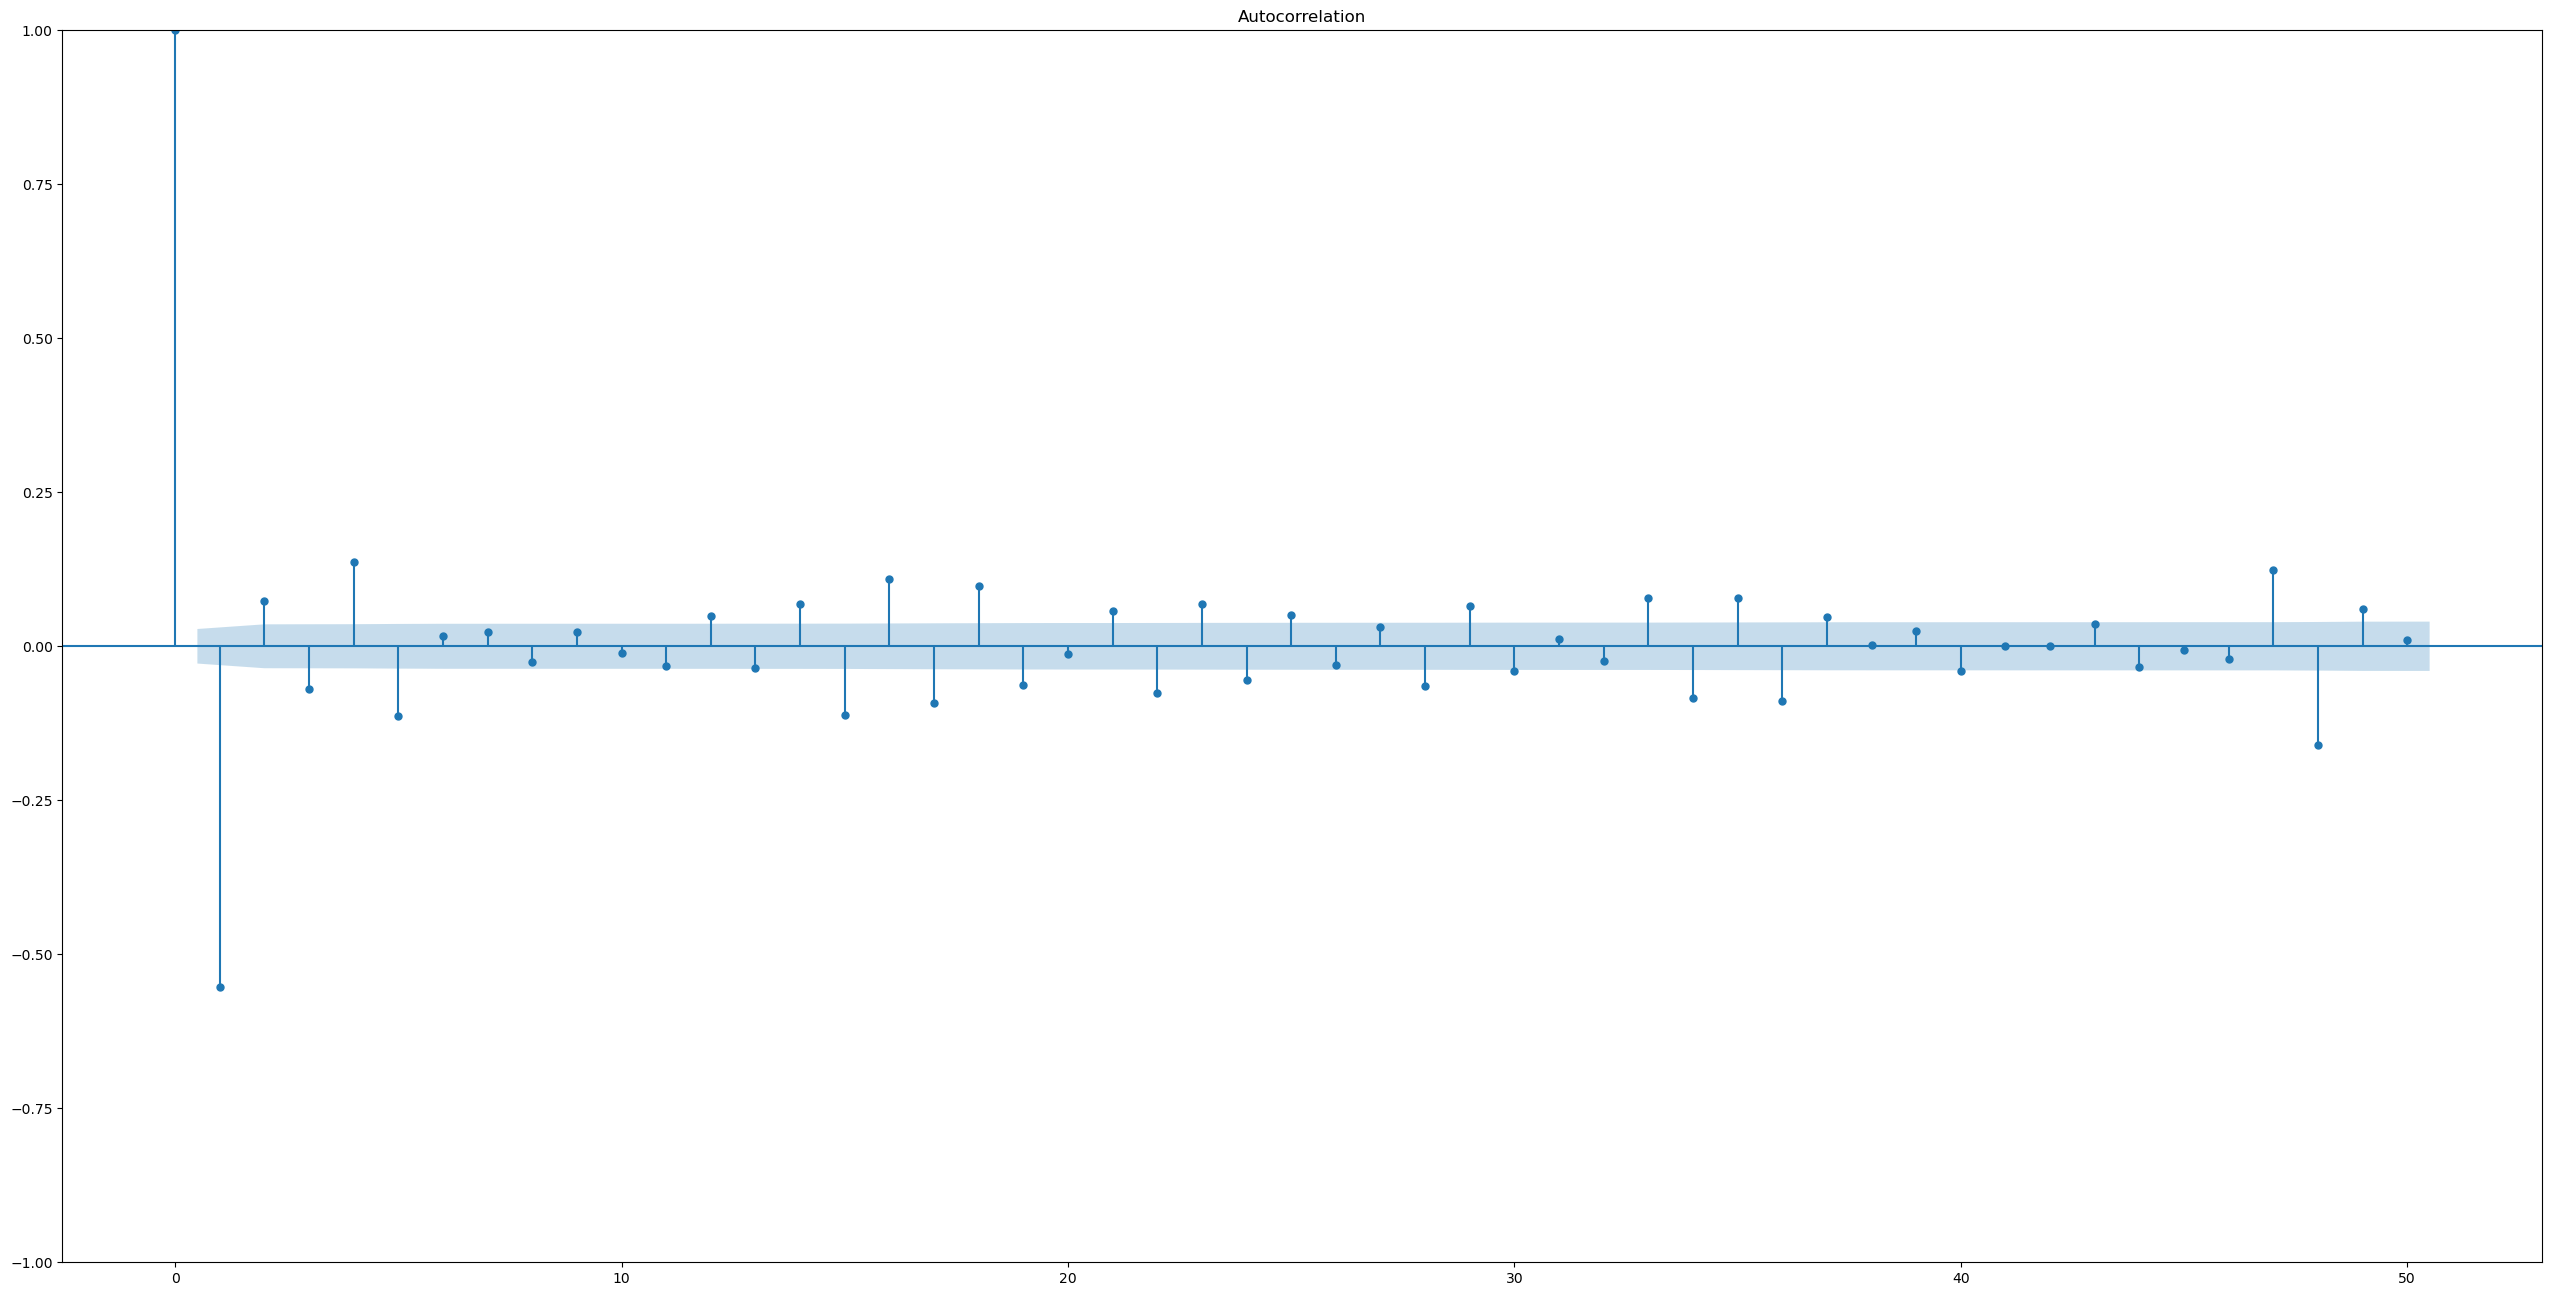

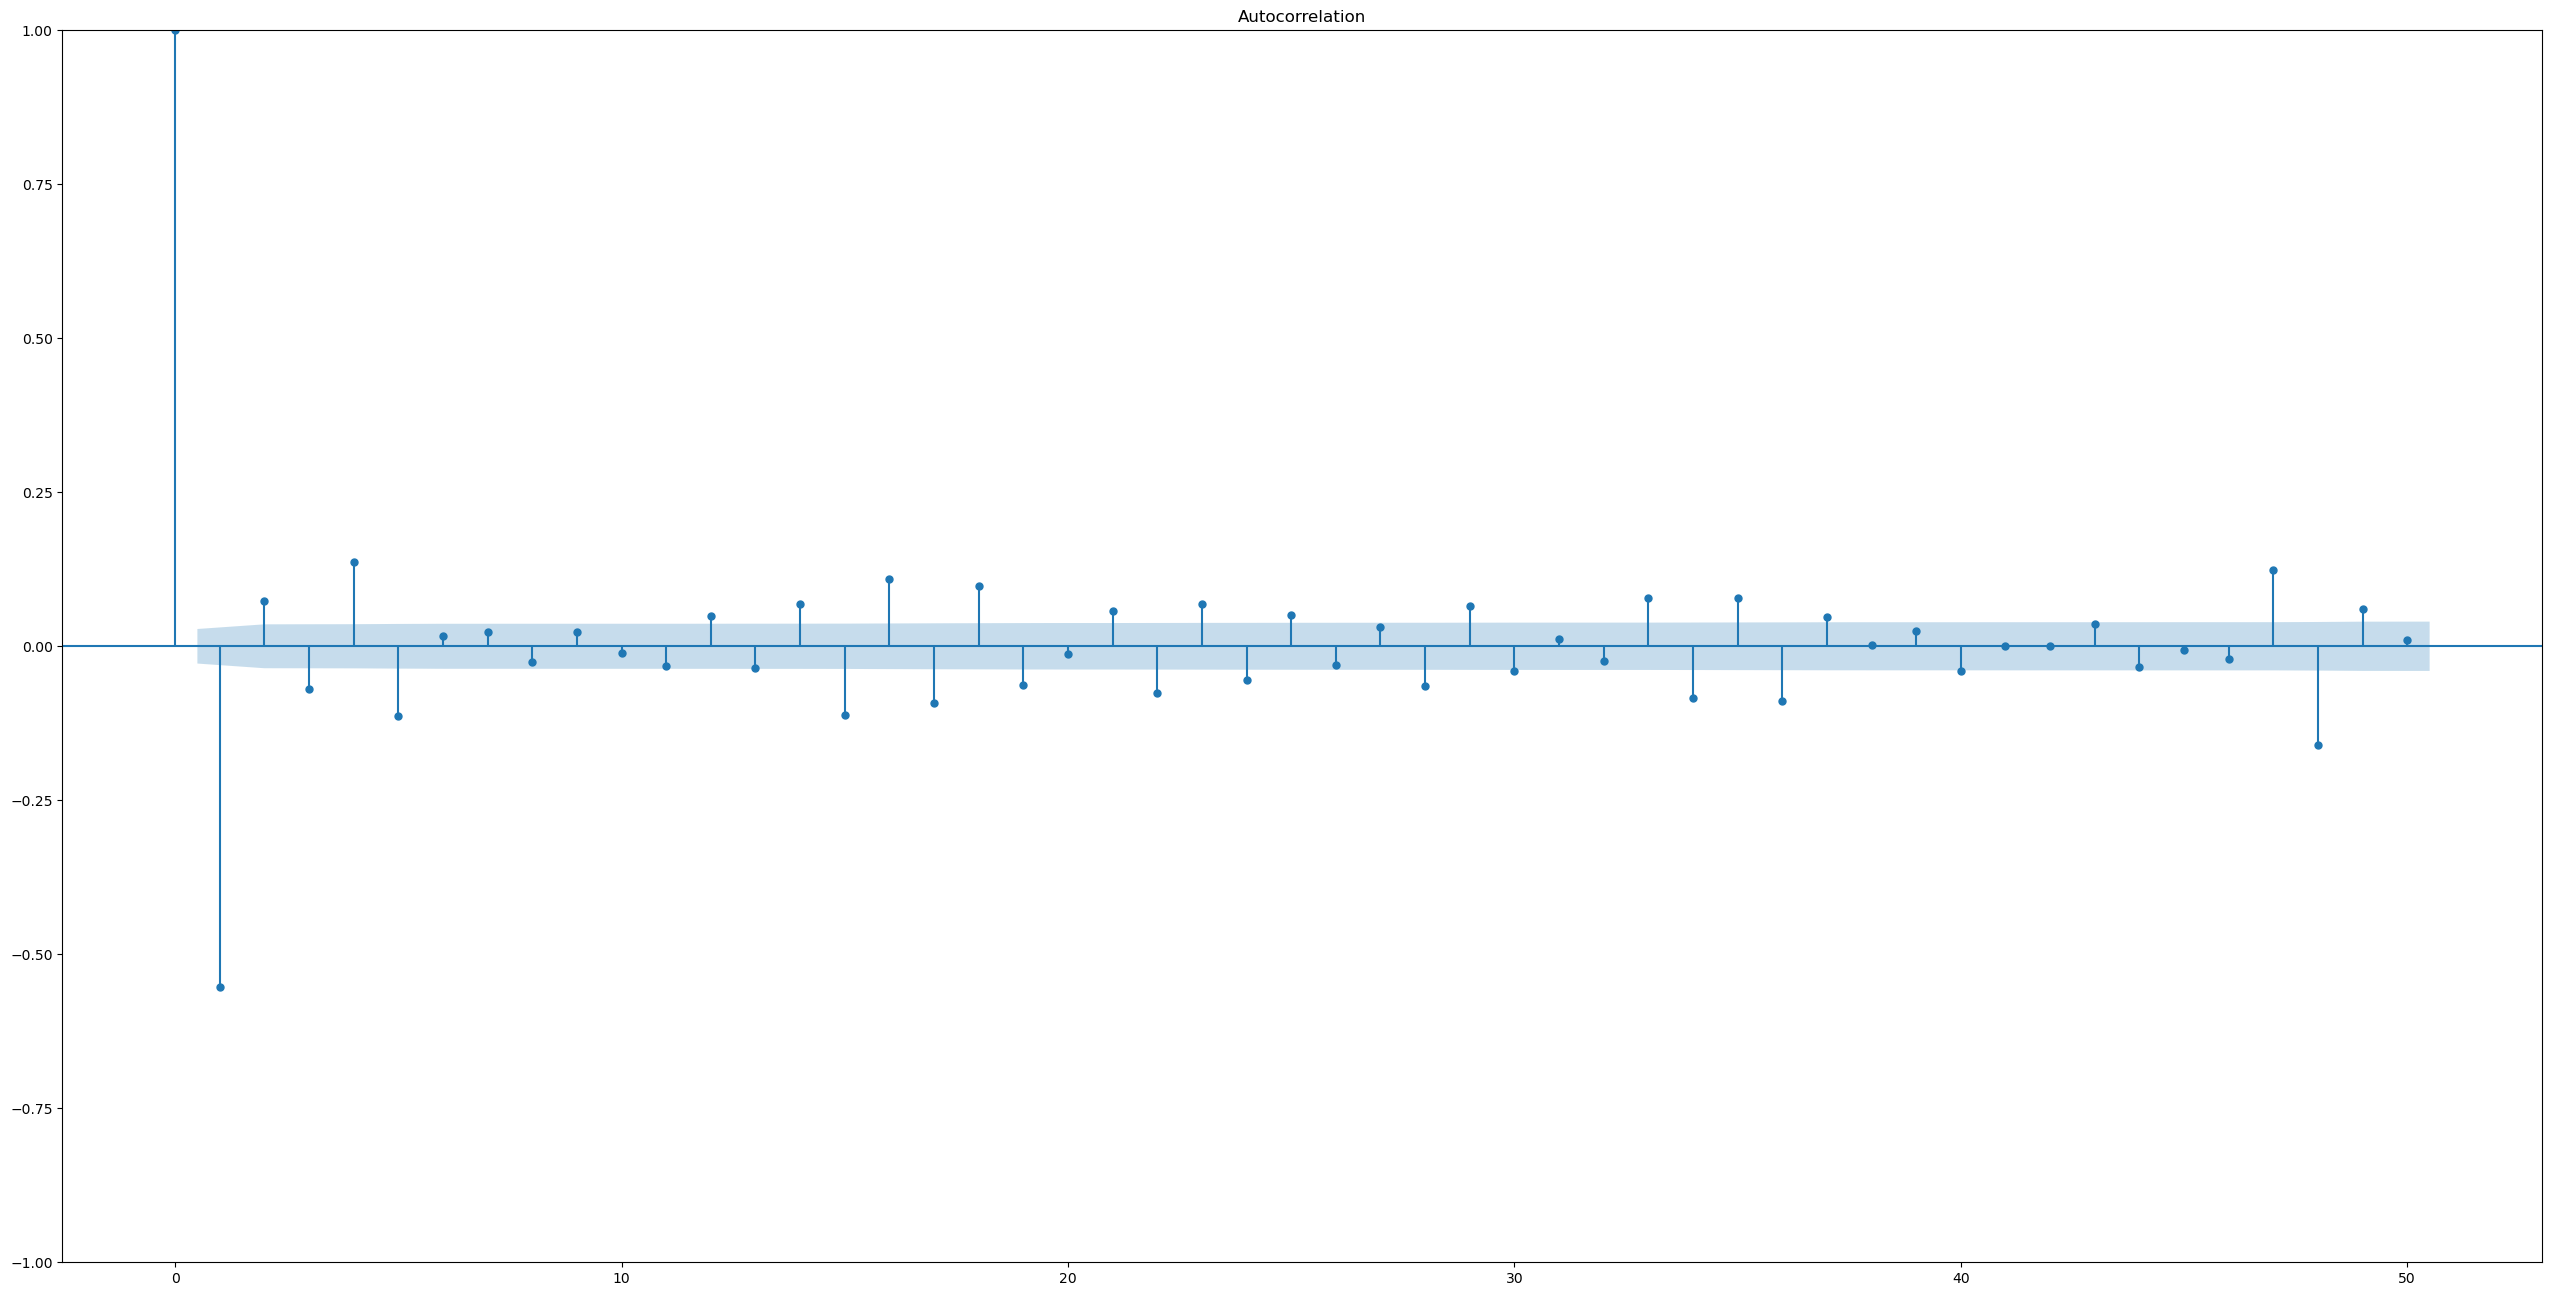

In [16]:
tsaplots.plot_acf(df_diff, lags=50)

C:\Users\Colo\miniconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


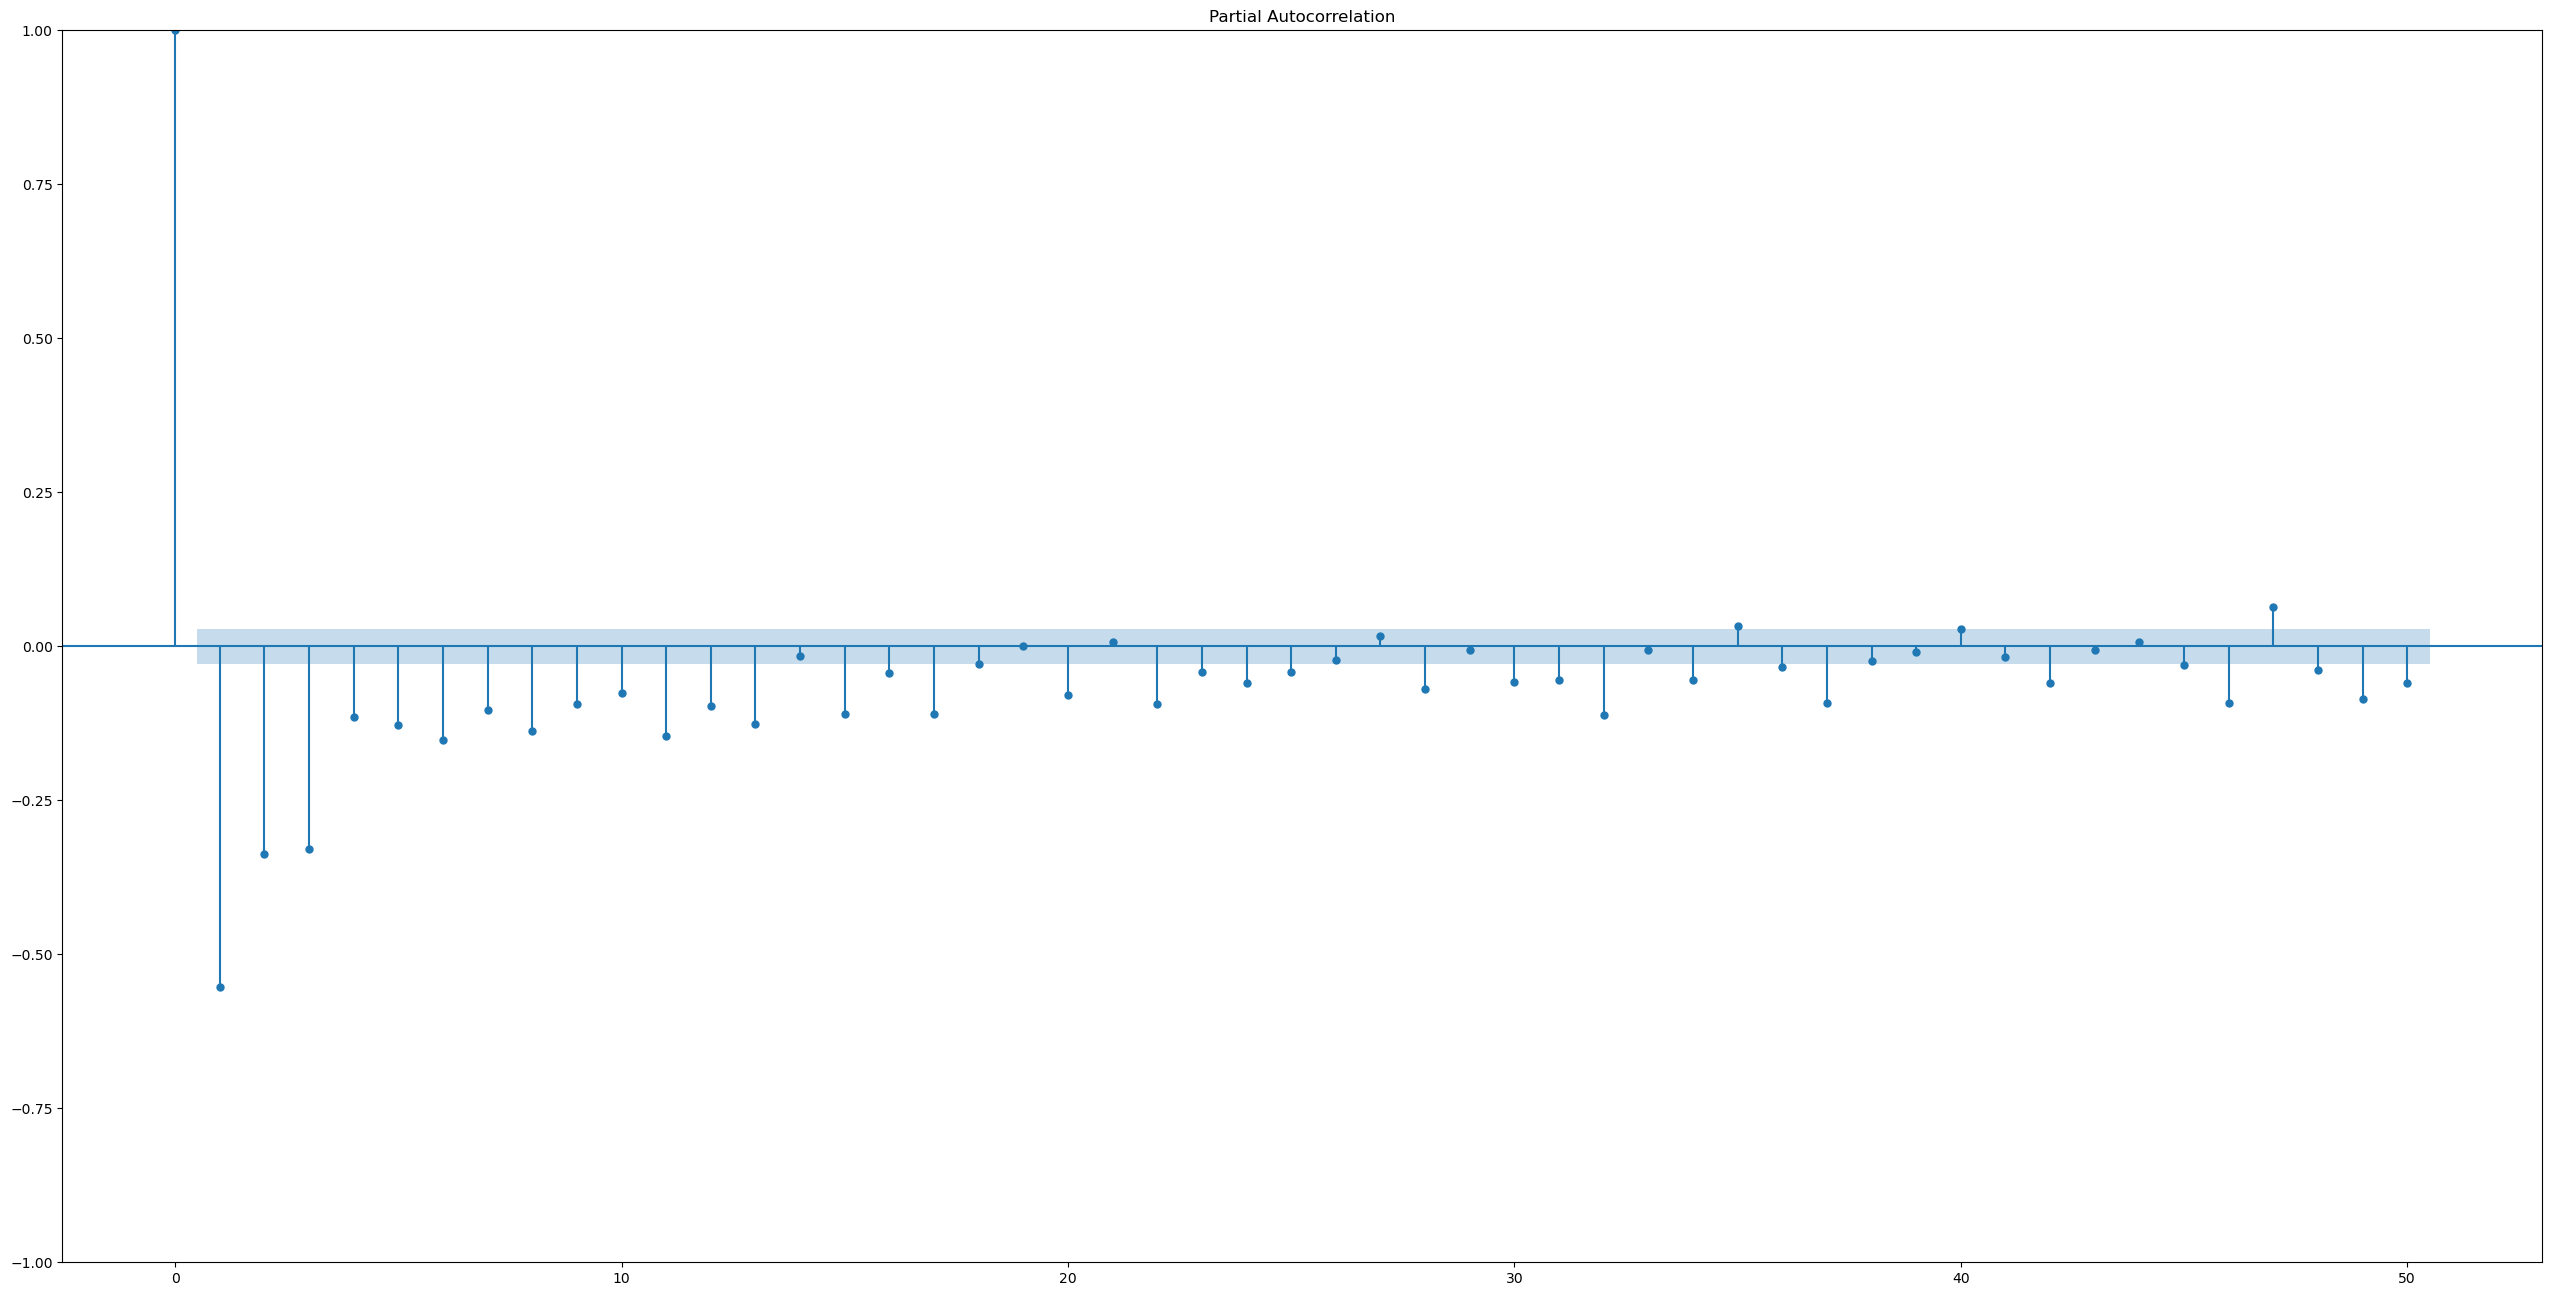

In [17]:
tsaplots.plot_pacf(df_diff, lags=50);

Usando este grafico de autocorrelacion y autocorrelacion parcial podemos notar que la serie de tiempo no es random y hay correlacion en el mismo.

# Clase 6

## Modelos

In [18]:
model1 = sm.tsa.statespace.SARIMAX(df_diff, order=(1,0,4), seasonal_order=(0,1,0,2))
fitted_model1 = model1.fit(disp=False)
fitted_model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Close   No. Observations:                 4879
Model:             SARIMAX(1, 0, 4)x(0, 1, [], 2)   Log Likelihood              -14407.706
Date:                            Sat, 08 Apr 2023   AIC                          28827.413
Time:                                    10:59:45   BIC                          28866.367
Sample:                                         0   HQIC                         28841.083
                                           - 4879                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8083      0.020    -40.453      0.000      -0.847      -0.769
ma.L1         -0.2559      0.027     -9.442      0.000      -0.309      -0.203
ma.L2         -1.7431      0.029    -60.444      0.000      -1.800      -1.687
ma.L3          0.2559      0.024     10.469      0.000       0.208       0.304
ma.L4          0.7431      0.026     28.941      0.000       0.693       0.793
sigma2        21.4213      0.298     71.974      0.000      20.838      22.005
===================================================================================
Ljung-Box (L1) (Q):                   3.21   Jarque-Bera (JB):            372222.63
Prob(Q):                              0.07   Prob(JB):                         0.00
Heteroskedasticity (H):            4141.91   Skew:                             0.75
Prob(H) (two-sided):                  0.00   Kurtosis:                        45.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

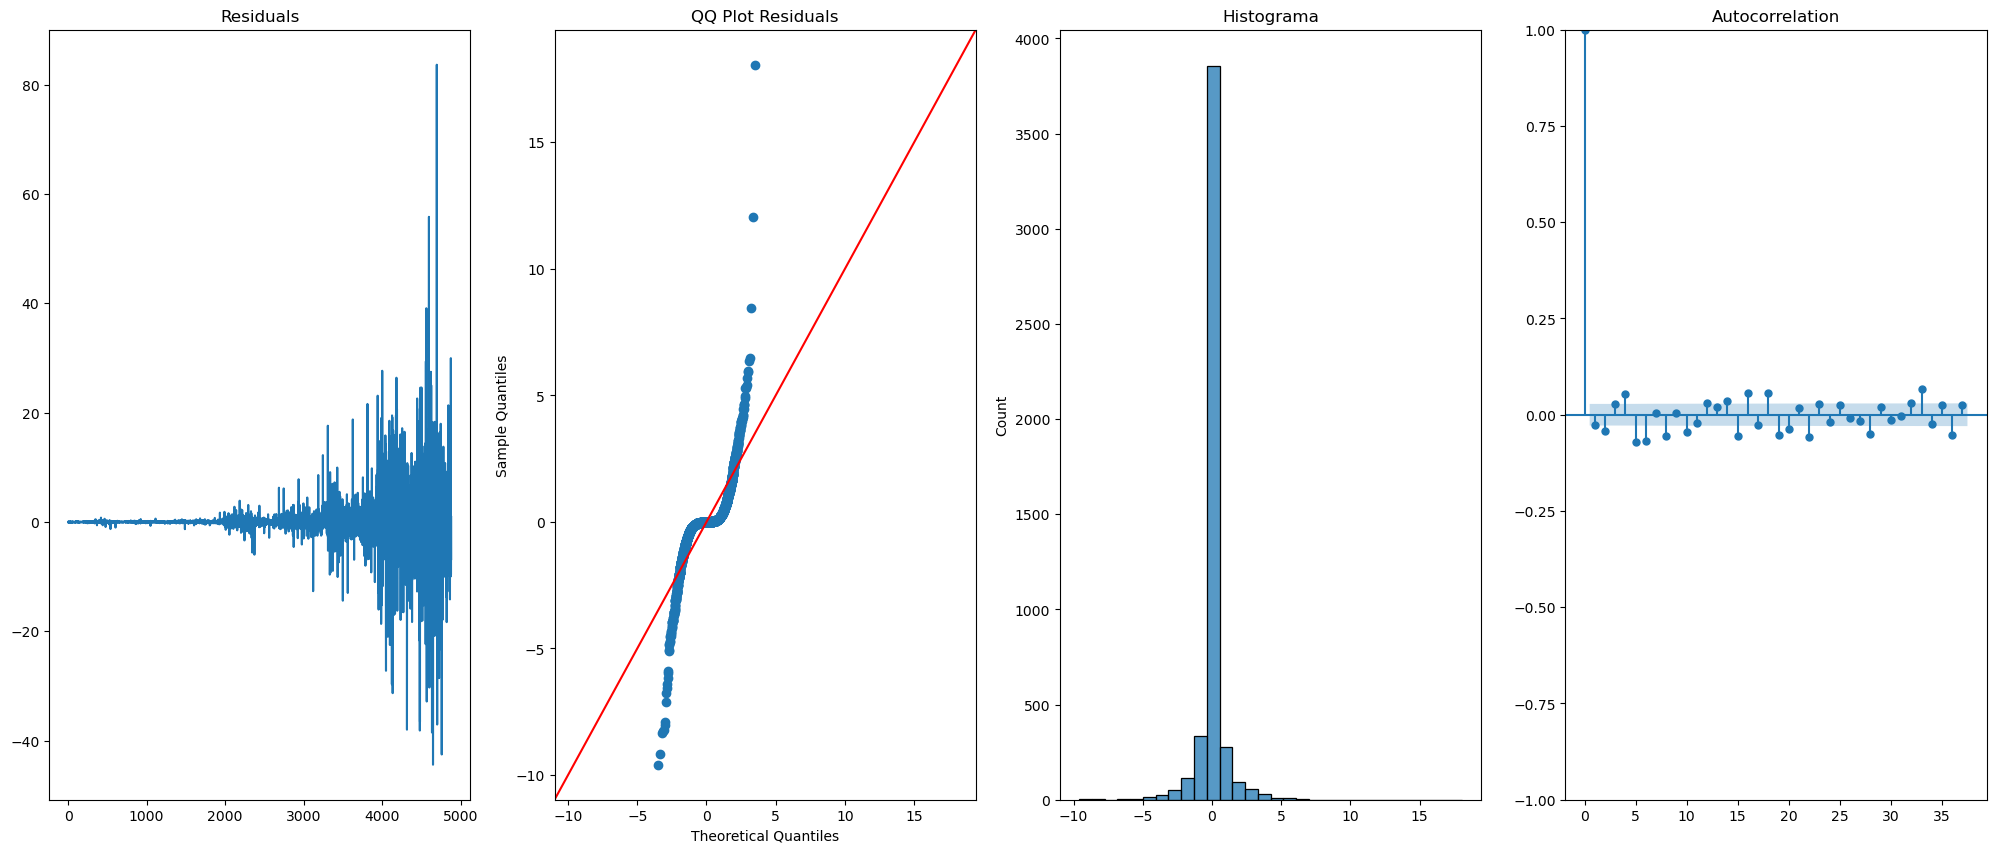

In [19]:

resid = fitted_model1.resid
resid_norm = (resid-resid.mean())/resid.std()
bins=30

#Plot
fig, ax = plt.subplots(1,4,figsize=(25,10))
resid.plot(ax=ax[0])
ax[0].set_title('Residuals')
sm.qqplot(resid_norm, scale=1, line="45", ax=ax[1])
ax[1].set_title('QQ Plot Residuals')
sm.graphics.tsa.plot_acf(resid, ax=ax[3])
sns.histplot(resid_norm, bins=bins, ax=ax[2])
ax[2].set_title(f'Histograma')

#plt.tight_layout()
plt.show()

In [20]:
model2 = sm.tsa.statespace.SARIMAX(df_diff, order=(1,0,3), seasonal_order=(0,1,0,2))
fitted_model2 = model2.fit(disp=False)
fitted_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Close   No. Observations:                 4879
Model:             SARIMAX(1, 0, 3)x(0, 1, [], 2)   Log Likelihood              -14416.407
Date:                            Sat, 08 Apr 2023   AIC                          28842.814
Time:                                    10:59:47   BIC                          28875.276
Sample:                                         0   HQIC                         28854.206
                                           - 4879                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0993      0.007    -14.531      0.000      -0.113      -0.086
ma.L1         -0.9979      0.252     -3.962      0.000      -1.492      -0.504
ma.L2         -1.0000      0.504     -1.984      0.047      -1.988      -0.012
ma.L3          0.9979      0.252      3.956      0.000       0.504       1.492
sigma2        21.5544      5.476      3.936      0.000      10.821      32.288
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):            389613.66
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):            4151.99   Skew:                             0.89
Prob(H) (two-sided):                  0.00   Kurtosis:                        46.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

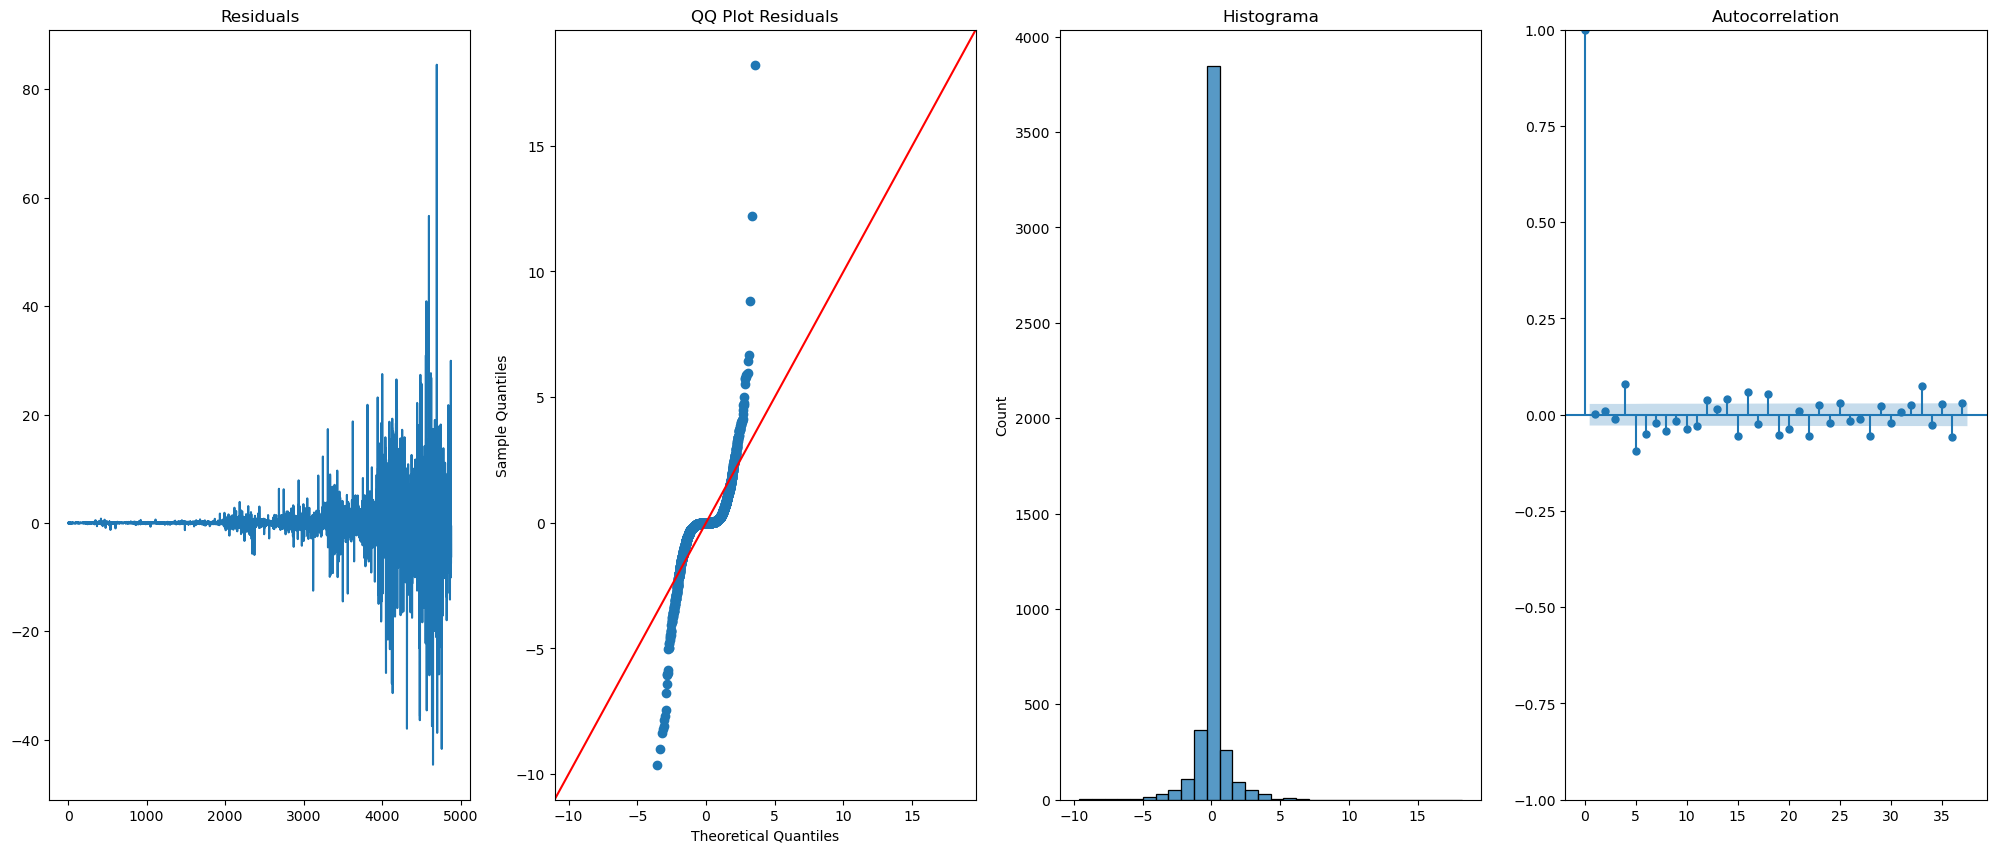

In [21]:

resid = fitted_model2.resid
resid_norm = (resid-resid.mean())/resid.std()
bins=30

#Plot
fig, ax = plt.subplots(1,4,figsize=(25,10))
resid.plot(ax=ax[0])
ax[0].set_title('Residuals')
sm.qqplot(resid_norm, scale=1, line="45", ax=ax[1])
ax[1].set_title('QQ Plot Residuals')
sm.graphics.tsa.plot_acf(resid, ax=ax[3])
sns.histplot(resid_norm, bins=bins, ax=ax[2])
ax[2].set_title(f'Histograma')

#plt.tight_layout()
plt.show()

In [22]:
model3 = sm.tsa.statespace.SARIMAX(df_diff, order=(1,0,1), seasonal_order=(0,1,0,2))
fitted_model3 = model3.fit(disp=False)
fitted_model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Close   No. Observations:                 4879
Model:             SARIMAX(1, 0, 1)x(0, 1, [], 2)   Log Likelihood              -16059.577
Date:                            Sat, 08 Apr 2023   AIC                          32125.155
Time:                                    10:59:49   BIC                          32144.632
Sample:                                         0   HQIC                         32131.990
                                           - 4879                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0380      0.007     -5.223      0.000      -0.052      -0.024
ma.L1         -0.9997      0.008   -123.904      0.000      -1.016      -0.984
sigma2        42.3673      0.405    104.681      0.000      41.574      43.161
===================================================================================
Ljung-Box (L1) (Q):                   2.08   Jarque-Bera (JB):            236001.33
Prob(Q):                              0.15   Prob(JB):                         0.00
Heteroskedasticity (H):            3952.67   Skew:                            -0.59
Prob(H) (two-sided):                  0.00   Kurtosis:                        37.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

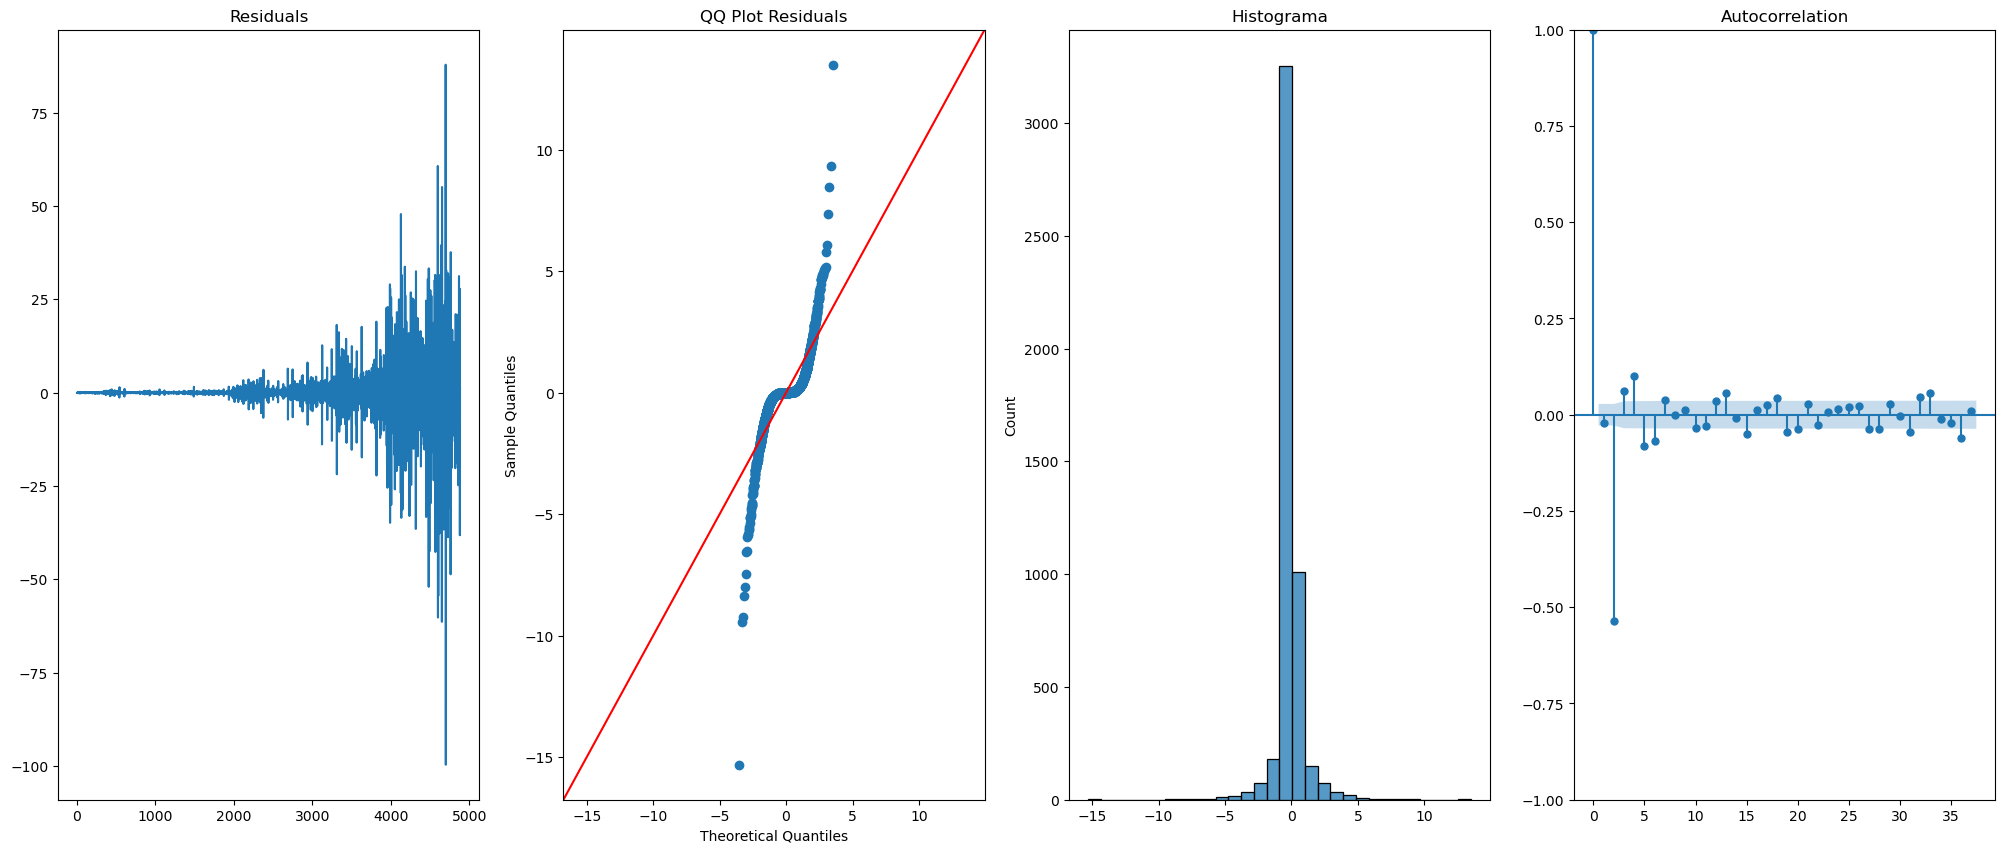

In [23]:

resid = fitted_model3.resid
resid_norm = (resid-resid.mean())/resid.std()
bins=30

#Plot
fig, ax = plt.subplots(1,4,figsize=(25,10))
resid.plot(ax=ax[0])
ax[0].set_title('Residuals')
sm.qqplot(resid_norm, scale=1, line="45", ax=ax[1])
ax[1].set_title('QQ Plot Residuals')
sm.graphics.tsa.plot_acf(resid, ax=ax[3])
sns.histplot(resid_norm, bins=bins, ax=ax[2])
ax[2].set_title(f'Histograma')

#plt.tight_layout()
plt.show()

## Predicciones

In [24]:
original_data = df
original_data = original_data.reset_index()

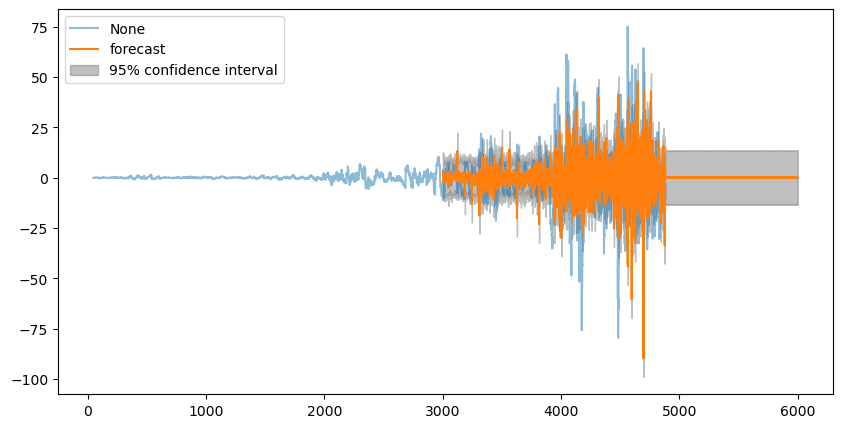

In [25]:
original_data = df["Close"]-mult.trend
fig, ax = plt.subplots(figsize=[10,5])
ax = original_data.plot(ax=ax, alpha=0.5)
fig = tsaplots.plot_predict(fitted_model1, start=3000, end=6000, ax=ax, plot_insample=False)
# fig = plot_predict(fitted_model2, start=pd.to_datetime('2016-04-26'), end=pd.to_datetime('2017-04-26'), ax=ax, plot_insample=False)

plt.show()

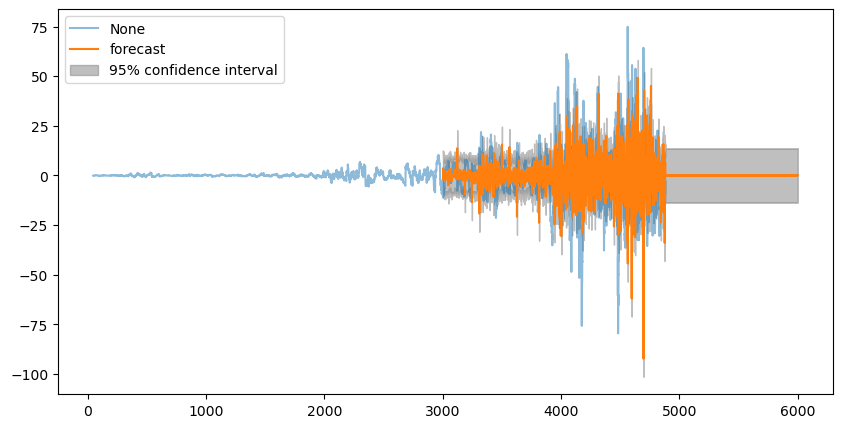

In [26]:
original_data = df["Close"]-mult.trend
fig, ax = plt.subplots(figsize=[10,5])
ax = original_data.plot(ax=ax, alpha=0.5)
fig = tsaplots.plot_predict(fitted_model2, start=3000, end=6000, ax=ax, plot_insample=False)
# fig = plot_predict(fitted_model2, start=pd.to_datetime('2016-04-26'), end=pd.to_datetime('2017-04-26'), ax=ax, plot_insample=False)

plt.show()

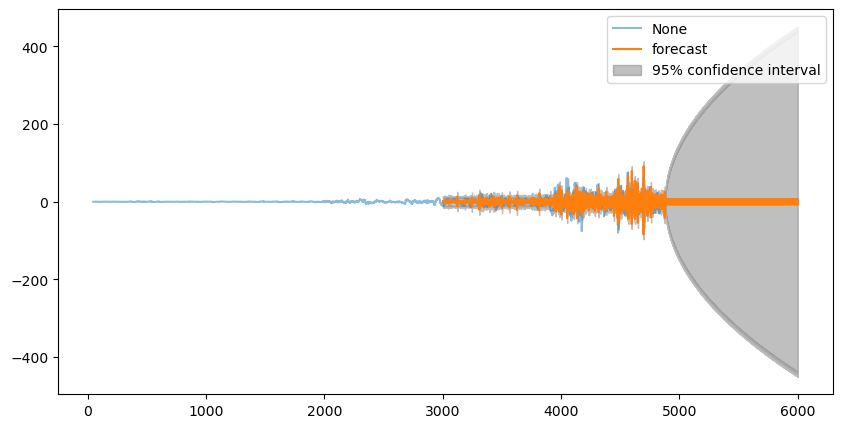

In [27]:
original_data = df["Close"]-mult.trend
fig, ax = plt.subplots(figsize=[10,5])
ax = original_data.plot(ax=ax, alpha=0.5)
fig = tsaplots.plot_predict(fitted_model3, start=3000, end=6000, ax=ax, plot_insample=False)
# fig = plot_predict(fitted_model2, start=pd.to_datetime('2016-04-26'), end=pd.to_datetime('2017-04-26'), ax=ax, plot_insample=False)

plt.show()

Se puede observar que todos los modelos ajustan bien a la serie, lo unico es que en el modelo 3, el intervalo de confianza del 95% crece de manera desmedida, por lo tanto, probablemente sea el unico que no recomendaria usar.

## LSTM

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 

In [34]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [362]:
lookBehind=15

In [363]:
train_df = df['Close']

X_train = []
y_train = []

X_test = []
y_test = []

for i in range(lookBehind, len(train_df)-500):
  X_train.append(train_df[i-lookBehind:i])
  y_train.append(train_df[i])
    
for i in range(len(train_df)-500, len(train_df)):
  X_test.append(train_df[i-lookBehind:i])
  y_test.append(train_df[i])

In [364]:
X_train, y_train= np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [365]:
X_test, y_test= np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [366]:
len(y_train)

4366

In [367]:
model=Sequential()
model.add(LSTM(50,activation='relu', input_shape=(lookBehind, 1)))
model.add(Dense(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
optimizer.learning_rate.assign(0.0001)
model.summary()

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(X_train, y_train, epochs=500, batch_size=32, verbose=True, validation_split=0.1, callbacks=[callback] )

Model: "sequential_69"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_71 (LSTM)              (None, 50)                10400     
                                                                 
 dense_133 (Dense)           (None, 50)                2550      
                                                                 
 dense_134 (Dense)           (None, 1)                 51        
                                                                 
Total params: 13,001
Trainable params: 13,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
123/123 [==============================] - 1s 5ms/step - loss: 23.8549 - val_loss: 373.7742
Epoch 2/500
123/123 [==============================] - 0s 4ms/step - loss: 9.0189 - val_loss: 312.6329
Epoch 3/500
123/123 [==============================] - 0s 4ms/step - loss: 6.4819 - val_loss: 121.6001
Epo

16/16 [==============================] - 0s 2ms/step


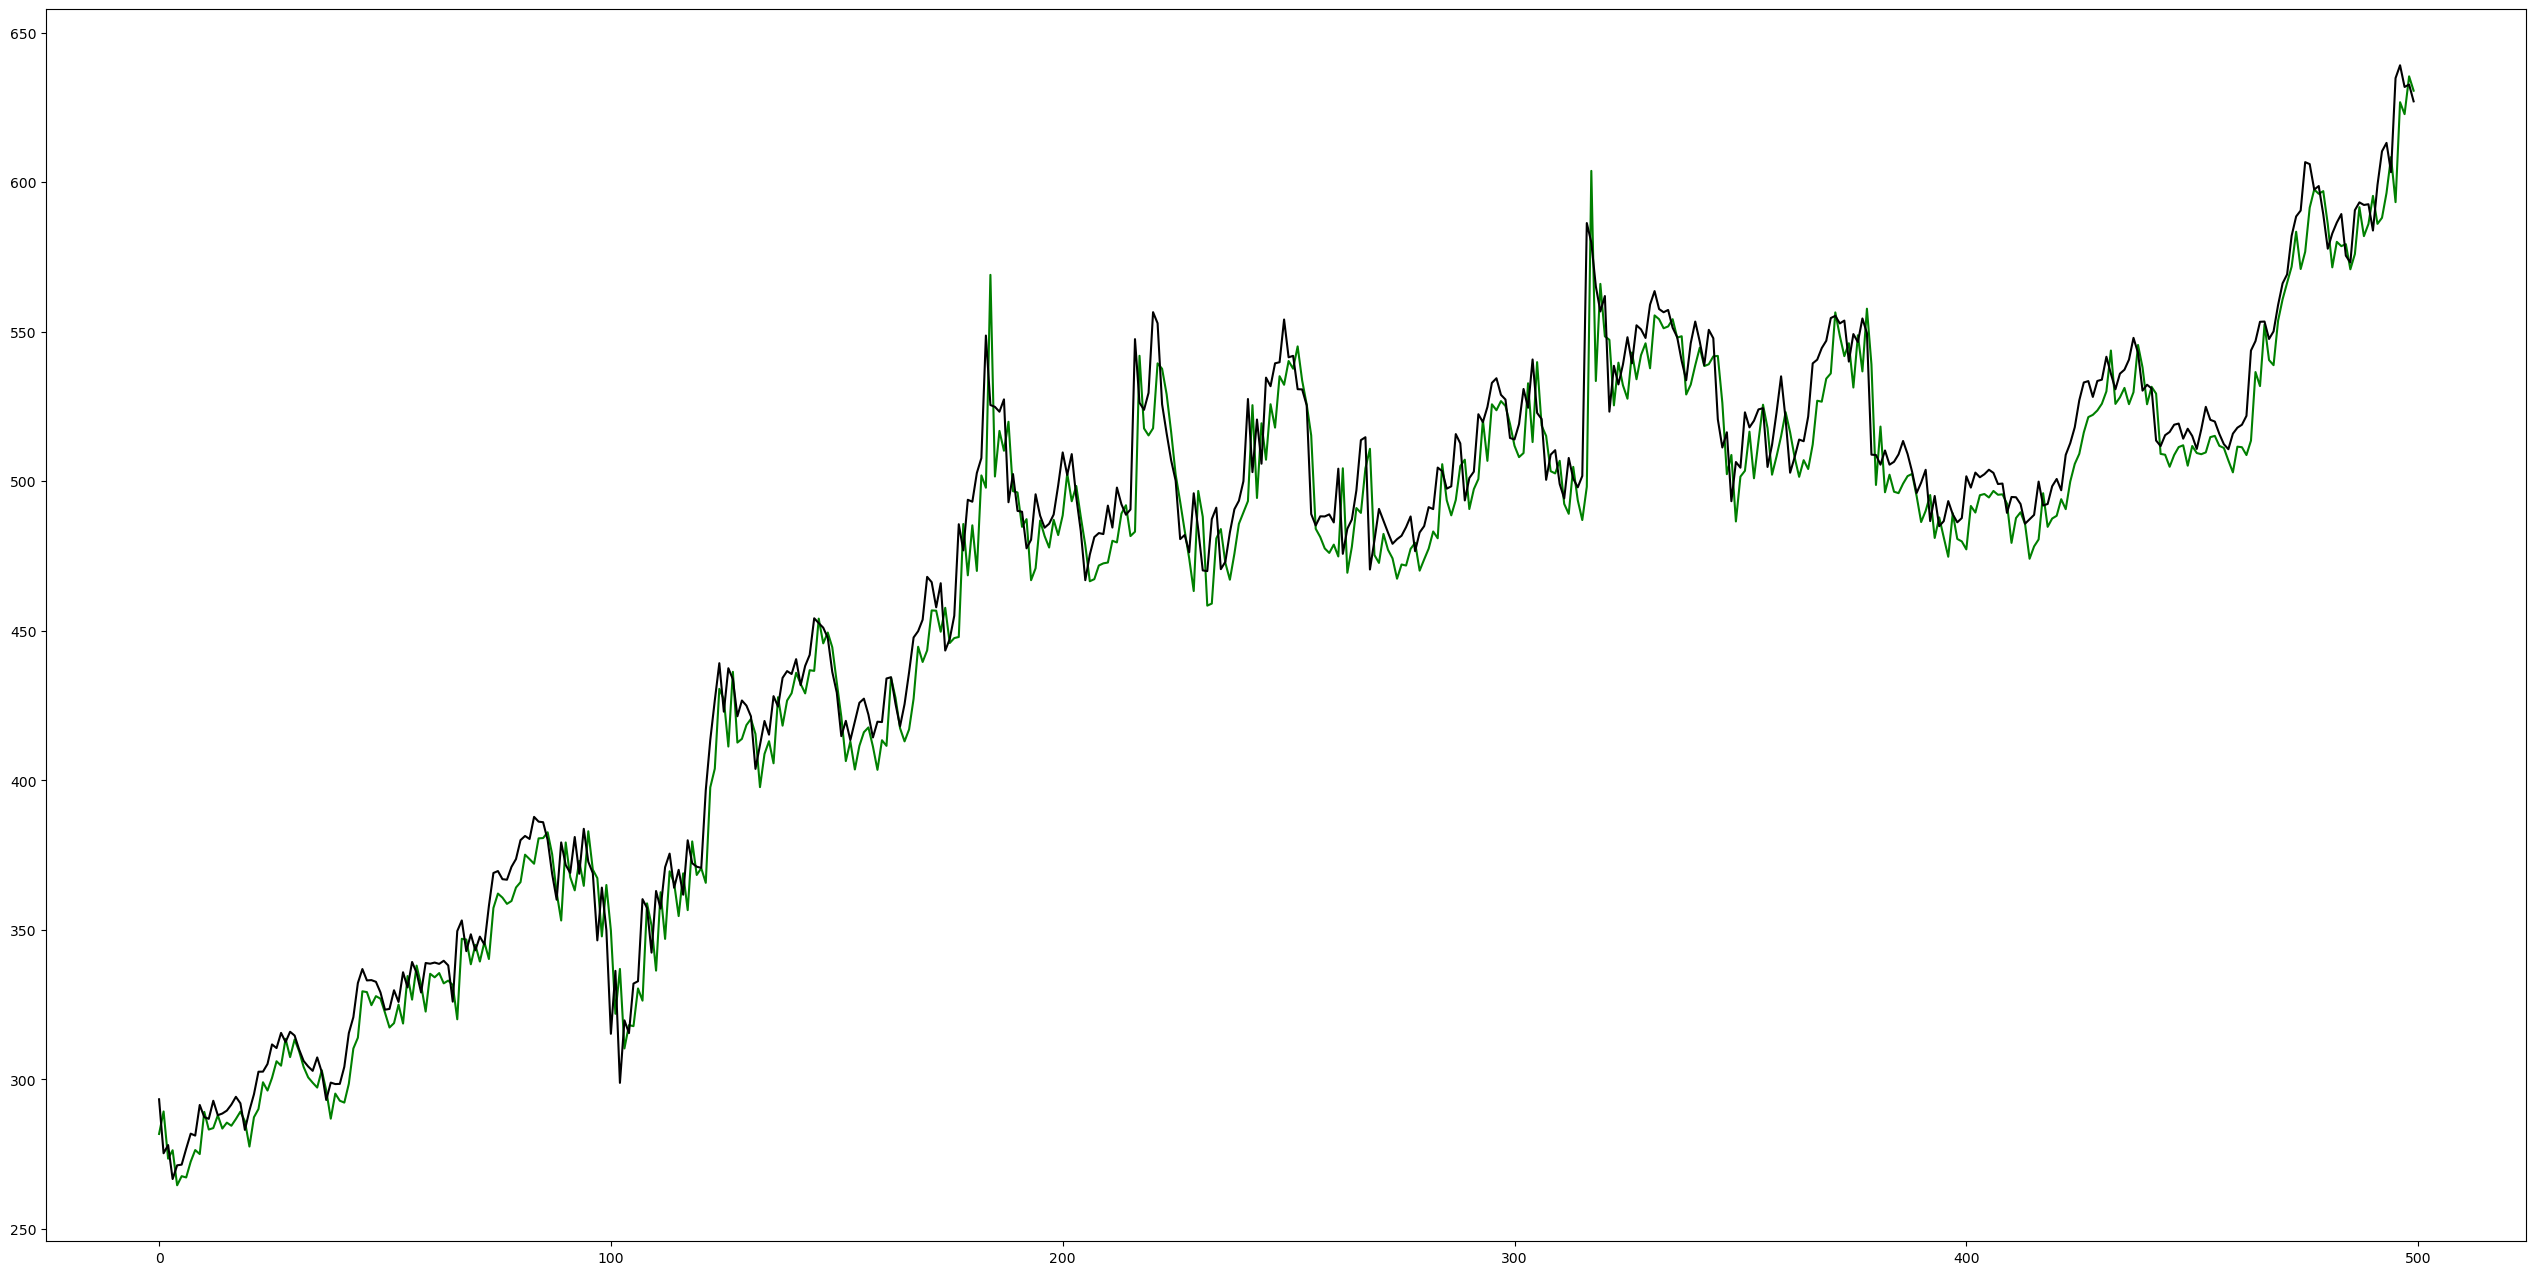

In [368]:
test_results = model.predict(X_test)
plt.plot(test_results.reshape(-1,1) , color="green")
plt.plot(y_test.reshape(-1,1), color="black")

137/137 [==============================] - 0s 2ms/step


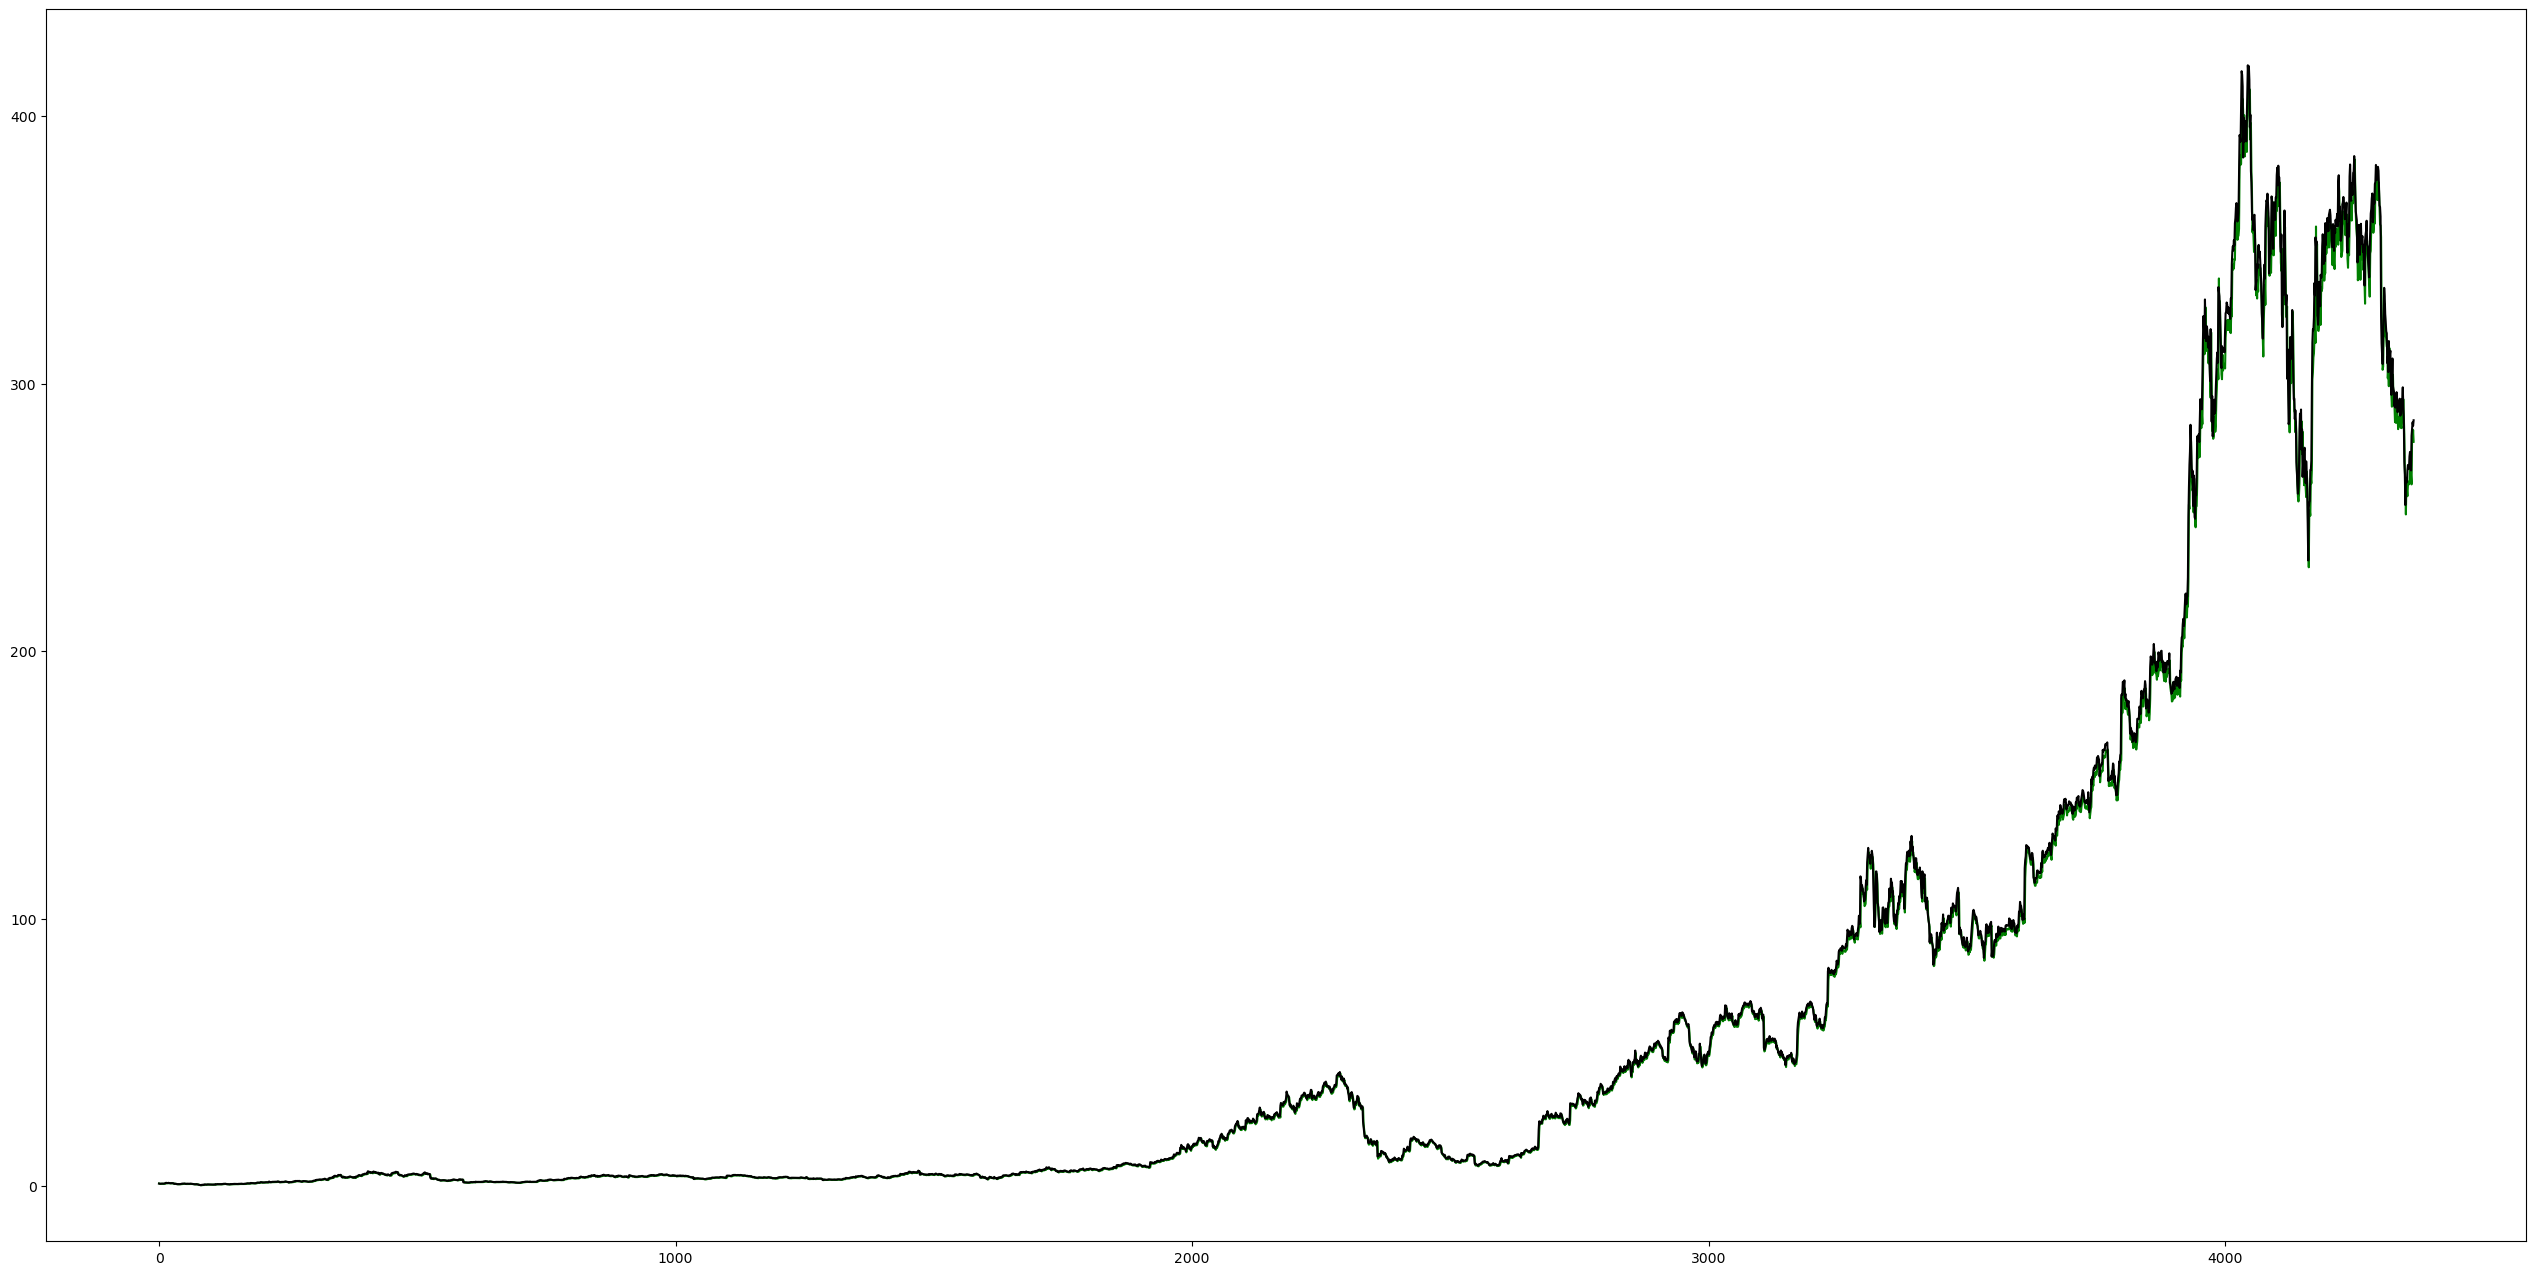

In [369]:
test_results = model.predict(X_train)
plt.plot(test_results.reshape(-1,1),color="green")
plt.plot(y_train.reshape(-1,1),color="black")

El LSTM tiene un fit bastante superior a los modelos SARIMA y el entrenamiento se puede realizar de manera rapida. No recomendaria usar los modelos clasicos.

## Analisis espectral

In [45]:
from scipy import signal

Text(0, 0.5, 'Densidad Espectral de Potencia')

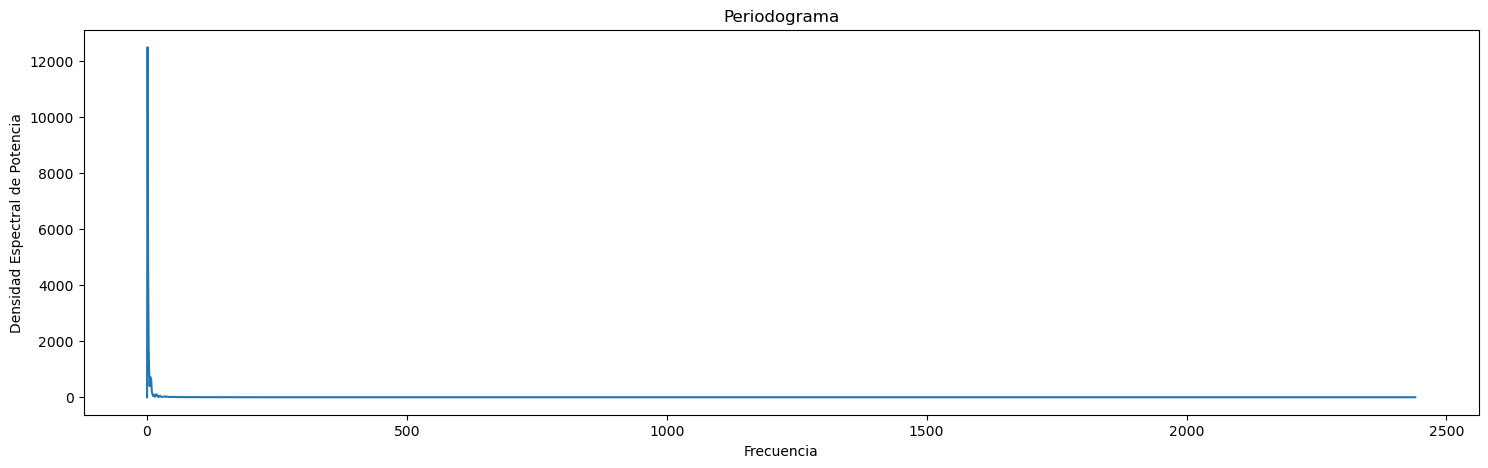

In [46]:
f, px = signal.periodogram(df["Close"],len(df))
plt.figure(figsize=(18,5))
plt.plot(f, px)
plt.title('Periodograma')
plt.xlabel('Frecuencia')
plt.ylabel('Densidad Espectral de Potencia')

Text(0, 0.5, 'Densidad Espectral de Potencia')

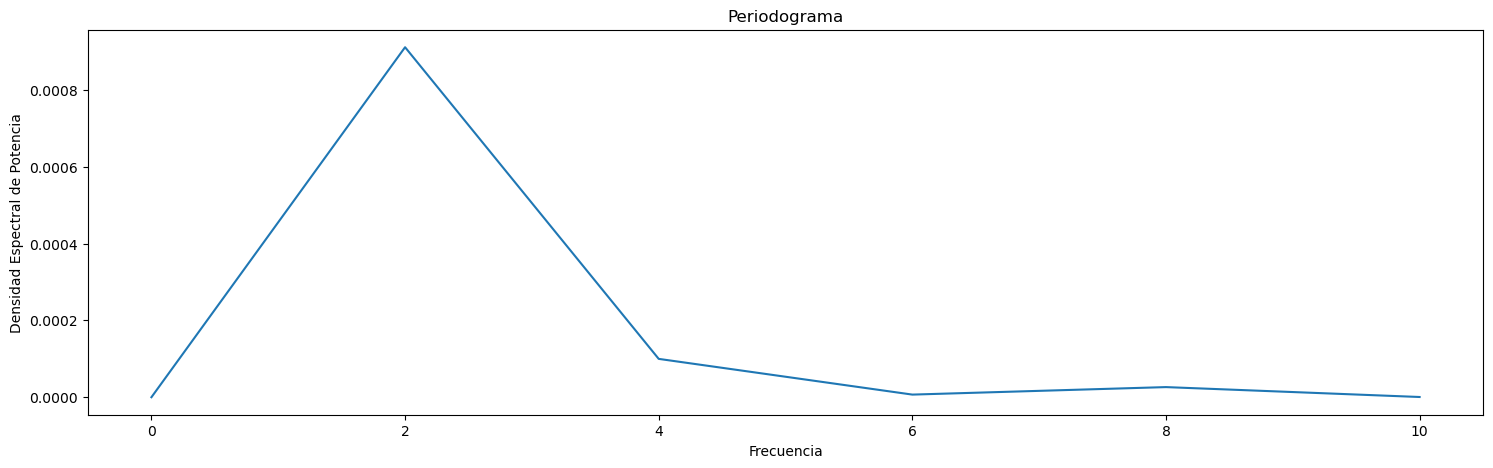

In [47]:
N = 20
f, px = signal.periodogram(df["Close"][0:10], N)
plt.figure(figsize=(18,5))
plt.plot(f, px)
plt.title('Periodograma')
plt.xlabel('Frecuencia')
plt.ylabel('Densidad Espectral de Potencia')